In [1]:
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer, AutoModel, AutoFeatureExtractor
from transformers import AutoFeatureExtractor, ASTFeatureExtractor, ASTForAudioClassification, ASTModel, ClapAudioModel, ClapAudioModelWithProjection, ClapFeatureExtractor
from IPython.display import Audio, display
import librosa
import soundfile as sf
import os
import faiss
import pickle
import traceback

In [2]:
# Load the Wav2Vec2.0 tokenizer and model
model = AutoModel.from_pretrained('facebook/wav2vec2-base-960h')
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

feature_extractor_ast = AutoFeatureExtractor.from_pretrained('MIT/ast-finetuned-audioset-10-10-0.4593')
model_ast = ASTModel.from_pretrained('MIT/ast-finetuned-audioset-10-10-0.4593')


model_clap = ClapAudioModelWithProjection.from_pretrained("laion/clap-htsat-fused")
feature_extractor_clap = ClapFeatureExtractor.from_pretrained("laion/clap-htsat-fused")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 were not used when initializing ASTModel: ['classifier.dense.bias', 'classifier.layernorm.weight', 'classifier.layernorm.bias', 'classifier.dense.weight']
- This IS expected if you are initializing ASTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing

In [3]:
model.to('cuda:0')
model_ast.to('cuda:0')
model_clap.to('cuda:0')

ClapAudioModelWithProjection(
  (audio_model): ClapAudioModel(
    (audio_encoder): ClapAudioEncoder(
      (patch_embed): ClapAudioPatchEmbed(
        (proj): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (fusion_model): ClapAudioAFFBlock(
          (local_att): Sequential(
            (0): Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1))
            (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(24, 96, kernel_size=(1, 1), stride=(1, 1))
            (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (global_att): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1))
            (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): R

## Resampling the songs to 16000 sample rate and splitting the track into 10 second small tracks

In [26]:
sample_rate = 16000
number_of_seconds = 10
dir_name = 'wav_files'
dest_dir = 'wav_files/10_seconds_samples/'
dest_dir_clap_sr = 'wav_files/10_seconds_samples/48000/'

## Splitting files and subsampling to 16000 to support wav2vec and AST

In [ ]:

for files in os.listdir(dir_name):
    if '.wav' in files:
        file_path = os.path.join(dir_name,files)
        x, sr = librosa.load(file_path, sr=16000)
        print("Splitting file {} with sample rate {}".format(files, sr))
        initial_seconds = number_of_seconds
        for i in range(0, len(x), number_of_seconds * sr):
            y = x[i: number_of_seconds * sr + (i)]
            out_file = str(initial_seconds) + "_" + files
            initial_seconds = initial_seconds + number_of_seconds
            sf.write(os.path.join(dest_dir,out_file), y, sr)
            


## Splitting files and subsampling to 48000 to support clap

In [26]:
for files in os.listdir(dir_name):
    if '.wav' in files:
        file_path = os.path.join(dir_name,files)
        x, sr = librosa.load(file_path, sr=48000)
        print("Splitting file {} with sample rate {}".format(files, sr))
        initial_seconds = number_of_seconds
        for i in range(0, len(x), number_of_seconds * sr):
            y = x[i: number_of_seconds * sr + (i)]
            out_file = str(initial_seconds) + "_" + files
            initial_seconds = initial_seconds + number_of_seconds
            file_path = os.path.join(dest_dir_clap_sr,out_file)
            isExist = os.path.exists(dest_dir_clap_sr)
            if not isExist:
               # Create a new directory because it does not exist
               os.makedirs(dest_dir_clap_sr)
            
            sf.write(file_path, y, sr)

Splitting file Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 48000
Splitting file Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 48000
Splitting file Trinidad Dreams.mp3.wav with sample rate 48000
Splitting file Kerala.mp3.wav with sample rate 48000
Splitting file B2 Jon Hester - Horizon (Snippet).mp3.wav with sample rate 48000
Splitting file Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 48000
Splitting file Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 48000
Splitting file AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 48000
Splitting file SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 48000
Splitting file Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 48000
Splitting file Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 48000
Splitting file P

Splitting file B2. Jon Hester - Neurons.mp3.wav with sample rate 48000
Splitting file Recondite Levo (Club Edit).mp3.wav with sample rate 48000
Splitting file Metodi Hristov - Breaking News.mp3.wav with sample rate 48000
Splitting file together.mp3.wav with sample rate 48000
Splitting file Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 48000
Splitting file Thomas Lizzara - Pilatus.mp3.wav with sample rate 48000
Splitting file Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with sample rate 48000
Splitting file Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 48000
Splitting file 07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 48000
Splitting file D&S - Affiliation (Jon Hester remix) (Snippet).mp3.wav with sample rate 48000
Splitting file Inside My Brain.mp3.wav with sample rate 48000
Splitting file Jon Hester - Shadows.mp3.wav with sample rate 48000
Splitting file ANASTASiiA - Obsidian.mp3.wav with sample rate 48000

Splitting file HOSH - Karma.mp3.wav with sample rate 48000
Splitting file TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 48000
Splitting file Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 48000
Splitting file Free (Short Edit).mp3.wav with sample rate 48000
Splitting file Love Temple (Copini Remix).mp3.wav with sample rate 48000
Splitting file B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 48000
Splitting file Jon Hester - Blinker.mp3.wav with sample rate 48000
Splitting file Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 48000
Splitting file Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 48000
Splitting file Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 48000
Splitting file CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 48000
Splitting file Jon Hester - Flex.mp3.wav with sample r

In [27]:
x, sr = librosa.load('wav_files/10_seconds_samples/1000_KW20 - Various Artists.mp3.wav', sr=16000)

In [28]:
sr

16000

In [29]:
waveform, sample_rate = torchaudio.load('wav_files/10_seconds_samples/1000_KW20 - Various Artists.mp3.wav')
waveform = waveform.squeeze().numpy()

print(sample_rate)

16000


In [30]:
display(Audio(waveform, rate=sample_rate))
print()

## Embeddings generator

In [31]:
input_values = feature_extractor_ast(waveform, return_tensors="pt", sampling_rate=sample_rate).to('cuda:0')

In [32]:
with torch.no_grad():
    embeddings = model_ast(**input_values).last_hidden_state
    embeddings = embeddings.mean(dim=1)
    print(embeddings.shape)

torch.Size([1, 768])


In [33]:
embeddings.shape[1]

768

In [34]:
embeddings.to('cpu').detach().numpy()

array([[ 1.11579025e+00, -1.80061743e-01,  1.04540162e-01,
         1.41995698e-01,  3.42160702e-01, -2.88645744e-01,
         2.58681804e-01, -1.19933501e-01, -7.91276634e-01,
        -5.57248771e-01, -1.25762790e-01,  1.52703476e+00,
         8.19049656e-01,  1.50922430e+00, -5.16620994e-01,
         1.18071878e+00, -3.63342643e-01,  5.12535155e-01,
         5.94076157e-01, -2.73940200e-03,  2.67775267e-01,
         2.33140111e-01,  1.07664001e+00, -3.11764061e-01,
         4.29384448e-02,  2.09366709e-01, -2.75161296e-01,
        -1.66990608e-01, -6.85749575e-02, -2.53862768e-01,
        -1.93084985e-01,  1.37052834e-01,  2.43600440e+00,
         6.49903476e-01,  1.13254450e-01,  6.63256764e-01,
         1.08364928e+00, -2.81451285e-01,  8.15186596e+00,
         1.07710516e+00, -1.69063099e-02,  8.95311892e-01,
         1.79135680e-01, -5.48035622e+00,  3.62935334e-01,
         9.73390974e-03, -3.31320092e-02,  1.47846437e+00,
         7.01988518e-01, -1.38272393e+00, -9.09972936e-0

In [52]:
        
waveform_clap, sr = torchaudio.load(os.path.join(dest_dir_clap_sr, files))
print(waveform_clap)
waveform_clap = waveform_clap.squeeze().numpy()
input_values = feature_extractor_clap(waveform_clap, return_tensors="pt", sampling_rate=48000).to('cuda:0')
embeddings = model_clap(**input_values).audio_embeds
print(embeddings[0].shape)

tensor([[-0.0464, -0.0421, -0.0544,  ..., -0.2330, -0.2988, -0.3430]])
torch.Size([512])


## Generate embeddings for all the small portions of the track and store it in FAISS - Wav2Vec2 and AST

In [98]:
index_wav_vec = faiss.IndexFlatL2(embeddings.shape[1])
index_ast = faiss.IndexFlatL2(embeddings.shape[1])
index_clap = faiss.IndexFlatL2(512)

In [99]:
index_wav_vec.ntotal, index_ast.ntotal, index_clap.ntotal

(0, 0, 0)

In [100]:
index_id = 0
faiss_index_lookup_samples = {}
embeddings_ast = []
embeddings_wav = []
embeddings_clap = []

## Generating embeddings for Wav2vec2, AST and Clap

In [83]:
input_values = feature_extractor(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
embeddings = model(**input_values).last_hidden_state
embeddings = embeddings.mean(dim=1).to('cpu').detach().numpy()
        #embeddings_wav.append(embeddings[0])
#index_wav_vec.add(embeddings)

In [84]:
print(embeddings.shape)

(1, 768)


In [101]:
for files in os.listdir(dest_dir):
    try:
        waveform, sample_rate = torchaudio.load(os.path.join(dest_dir,files))
        print("Processing files {} with sample rate {}".format(files, sample_rate))
        waveform = waveform.squeeze().numpy()
        
        #wav2vec2
        input_values = feature_extractor(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
        embeddings = model(**input_values).last_hidden_state
        embeddings = embeddings.mean(dim=1).to('cpu').detach().numpy()
        #embeddings_wav.append(embeddings[0])
        index_wav_vec.add(embeddings)
        
        #ast
        input_values = feature_extractor_ast(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
        embeddings = model_ast(**input_values).last_hidden_state
        embeddings = embeddings.mean(dim=1).to('cpu').detach().numpy()
        #embeddings_ast.append(embeddings[0])
        index_ast.add(embeddings)
        
        
        waveform_clap, sr = torchaudio.load(os.path.join(dest_dir_clap_sr, files))
        waveform_clap = waveform_clap.squeeze().numpy()
        input_values_clap = feature_extractor_clap(waveform_clap, return_tensors="pt", sampling_rate=48000).to('cuda:0')
        embeddings_clap = model_clap(**input_values_clap).audio_embeds
        #embeddings_clap.append(embeddings[0])
        index_clap.add(embeddings_clap.to('cpu').detach().numpy())
        
        # creating index lookup
        faiss_index_lookup_samples[index_id] = os.path.join(dest_dir,files)
        index_id = index_id + 1
    except Exception as e:
        print("Error files {}".format(files))
        #print(traceback.format_exc(e))
        #continue

Processing files 260_Trinidad Dreams.mp3.wav with sample rate 16000
Processing files 390_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000
Processing files 20_Trinidad Dreams.mp3.wav with sample rate 16000
Processing files 390_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000
Processing files 30_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000
Processing files 240_Night Glitches.mp3.wav with sample rate 16000
Processing files 420_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 70_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000
Processing files 3120_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 500_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 180_A1. Jon Hester - Inertia.mp3.wav wit

Processing files 80_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000
Processing files 20_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000
Processing files 1660_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 560_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 240_Jon Hester - Flex.mp3.wav with sample rate 16000
Processing files 370_A Pinch Of Spice.mp3.wav with sample rate 16000
Processing files 3020_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 290_Ben Böhmer - After Earth.mp3.wav with sample rate 16000
Processing files 380_Proelium [Awen Tales].mp3.wav with sample rate 16000
Processing files 170_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 10_different.mp3.wav with sample rate 16000
Processing files 410_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000
Processing files 410_Oxia & Nicolas Masseyeff - You Know (Original

Processing files 260_Emil Berliner - Meuterei.mp3.wav with sample rate 16000
Processing files 230_Venen.mp3.wav with sample rate 16000
Processing files 350_Trigger.mp3.wav with sample rate 16000
Processing files 150_Jon Hester - Accelerator.mp3.wav with sample rate 16000
Processing files 90_Delilah (pull me out of this).mp3.wav with sample rate 16000
Processing files 90_Rocket (Radio-Edit).mp3.wav with sample rate 16000
Processing files 190_Serge Devant - Life Trap.mp3.wav with sample rate 16000
Processing files 210_Jon Hester - Part 4.mp3.wav with sample rate 16000
Processing files 2150_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 110_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000
Processing files 290_Feel & Frondorf - Equality.mp3.wav with sample rate 16000
Processing files 30_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 310_Emanuel Satie feat. Nanghiti - Fade [

Processing files 1190_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 410_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000
Processing files 270_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000
Processing files 160_Dalfie - Carmina.mp3.wav with sample rate 16000
Processing files 270_Ben Böhmer - Vale.mp3.wav with sample rate 16000
Processing files 260_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000
Processing files 10_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000
Processing files 440_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000
Processing files 180_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000
Processing files 310_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000
Processing files 360_Barber - Phase 2 Face.mp3.wav with sample rate 16000
Pro

Processing files 100_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000
Processing files 270_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000
Processing files 360_Parple - Believe.mp3.wav with sample rate 16000
Processing files 380_A Pinch Of Spice.mp3.wav with sample rate 16000
Processing files 100_Dust.mp3.wav with sample rate 16000
Processing files 90_Ben Böhmer - After Earth.mp3.wav with sample rate 16000
Processing files 350_Audiojack - First Flight.mp3.wav with sample rate 16000
Processing files 260_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000
Processing files 290_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000
Processing files 330_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000
Processing files 210_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with sample rate 16000
Processing files 30_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 210_Audioja

Processing files 200_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000
Processing files 310_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000
Processing files 330_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 10_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000
Processing files 370_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 230_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000
Processing files 240_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000
Processing files 90_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000
Processing files 10_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000
Processing files 80_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000
Pro

Processing files 370_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 480_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 140_Ben Böhmer - After Earth.mp3.wav with sample rate 16000
Processing files 170_Parple - Believe.mp3.wav with sample rate 16000
Processing files 50_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files 460_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000
Processing files 30_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000
Processing files 3110_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 100_Depth Of Silence.mp3.wav with sample rate 16000
Processing files 80_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 2000_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 280_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000
Process

Processing files 380_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000
Processing files 330_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000
Processing files 360_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 30_Trinidad Dreams.mp3.wav with sample rate 16000
Processing files 780_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 930_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 110_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000
Processing files 290_Jon Hester - Blinker.mp3.wav with sample rate 16000
Processing files 50_Huxley - Weirdest Geen.mp3.wav with sample rate 16000
Processing files 80_Lonely Boy zzzzz.mp3.wav with sample rate 16000
Processing files 180_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000
Processing files 50_Fatima Yamaha - Whats A Girl 

Processing files 310_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 110_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000
Processing files 240_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000
Processing files 170_Second Change - Diversions Music 09.mp3.wav with sample rate 16000
Processing files 280_Vision.mp3.wav with sample rate 16000
Processing files 140_Trinidad Dreams.mp3.wav with sample rate 16000
Processing files 160_Audiojack - Higher.mp3.wav with sample rate 16000
Processing files 2710_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 300_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000
Processing files 110_Phaeton.mp3.wav with sample rate 16000
Processing files 180_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000
Processing files 310_Jon Hester - Flex.mp3.wav with sample rate 16000
Processing files 710_KW20 - Various Artists.mp

Processing files 250_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000
Processing files 50_Flashlight.mp3.wav with sample rate 16000
Processing files 180_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with sample rate 16000
Processing files 300_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000
Processing files 40_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000
Processing files 320_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 410_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000
Processing files 2640_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 80_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000
Processing files 100_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000
Processing files 180_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000
Processing files 180_A Pinch Of Spice.mp3.wa

Processing files 130_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000
Processing files 390_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 60_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000
Processing files 300_Proelium [Awen Tales].mp3.wav with sample rate 16000
Processing files 400_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 180_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000
Processing files 100_Acid Rain.mp3.wav with sample rate 16000
Processing files 210_Weird (Unweird Mix).mp3.wav with sample rate 16000
Processing files 230_Caribou - Mars.mp3.wav with sample rate 16000
Processing files 110_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000
Processing files 260_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 190_SP363 : Javi Colors & Dr. Alfred

Processing files 560_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000
Processing files 250_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000
Processing files 60_Barber - Phase 2 Face.mp3.wav with sample rate 16000
Processing files 150_A Pinch Of Spice.mp3.wav with sample rate 16000
Processing files 100_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 130_Elevate.mp3.wav with sample rate 16000
Processing files 100_Jon Hester - Silver.mp3.wav with sample rate 16000
Processing files 40_Jon Hester - Sending Signals.mp3.wav with sample rate 16000
Processing files 340_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 360_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000
Processing files 100_Delilah (pull me out of this).mp3.wav with sample rate 16000
Processing files 320_Ben Böhmer - Purple Line.mp3.wav wit

Processing files 160_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000
Processing files 90_Audiojack - First Flight.mp3.wav with sample rate 16000
Processing files 2220_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 30_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000
Processing files 160_Proelium [Awen Tales].mp3.wav with sample rate 16000
Processing files 420_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000
Processing files 80_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000
Processing files 160_Jon Hester - Contact.mp3.wav with sample rate 16000
Processing files 140_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000
Processing files 260_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files 220_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000
Processing f

Processing files 270_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000
Processing files 350_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000
Processing files 50_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000
Processing files 290_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000
Processing files 120_Jon Hester - Flex.mp3.wav with sample rate 16000
Processing files 40_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 120_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000
Processing files 440_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 2270_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 400_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000
Processing files 370_Pulchra.mp3.wav with sampl

Processing files 140_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 170_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 410_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 490_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 280_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 200_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 340_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 200_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000
Processing files 540_Gemini.mp3.wav with sample rate 16000
Processing files 40_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Ch

Processing files 280_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000
Processing files 320_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000
Processing files 100_Jon Hester - Zoned.mp3.wav with sample rate 16000
Processing files 120_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000
Processing files 300_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000
Processing files 50_Infinity.mp3.wav with sample rate 16000
Processing files 280_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 1900_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 90_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 270_Trigger.mp3.wav with sample rate 16000
Processing files 330_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000
Processing files 2940_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 190_Jon Hester - Equinox.mp3.wav with sample rate 16

Processing files 50_Caribou - Mars.mp3.wav with sample rate 16000
Processing files 200_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 90_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000
Processing files 420_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000
Processing files 350_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000
Processing files 30_D&S - Affiliation (Jon Hester remix) (Snippet).mp3.wav with sample rate 16000
Processing files 340_Jon Hester - Zoned.mp3.wav with sample rate 16000
Processing files 250_Gemini.mp3.wav with sample rate 16000
Processing files 410_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 10_Elevate.mp3.wav with sample rate 16000
Processing files 90_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav with sample rate 16000
Processing files 20_Odonien.mp3.wav with sample rate 16000
Processing files 60_Redondo & Ferreck D

Processing files 20_Jon Hester - Contact.mp3.wav with sample rate 16000
Processing files 130_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000
Processing files 100_Audiojack - First Flight.mp3.wav with sample rate 16000
Processing files 470_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000
Processing files 240_Ray of Hope (Original Mix).mp3.wav with sample rate 16000
Processing files 250_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000
Processing files 620_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 190_Gemini.mp3.wav with sample rate 16000
Processing files 250_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000
Processing files 50_Jon Hester - Shadows.mp3.wav with sample rate 16000
Processing files 70_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000
Processing files 310_Re.You - The Night We Met (MHD115).mp3.wav wit

Processing files 70_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000
Processing files 360_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000
Processing files 100_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000
Processing files 300_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000
Processing files 50_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000
Processing files 60_Delilah (pull me out of this).mp3.wav with sample rate 16000
Processing files 10_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000
Processing files 190_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 320_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000
Processing files 360_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000
Processing files 10_Jay Lumen - Meteo (Origina

Processing files 80_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000
Processing files 390_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 170_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000
Processing files 600_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 320_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000
Processing files 290_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 280_Jon Hester - Rain.mp3.wav with sample rate 16000
Processing files 60_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000
Processing files 290_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000
Processing files 160_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 250_Recondite Levo (Club Edit).mp3.wav with sample rate 16000
Processing files 3100_Mix 09:2013.mp3.mp3.w

Processing files 390_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000
Processing files 380_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000
Processing files 460_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000
Processing files 240_Orthoptera.mp3.wav with sample rate 16000
Processing files 170_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000
Processing files 10_Jon Hester - Haze.mp3.wav with sample rate 16000
Processing files 410_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 180_Jon Hester - Blinker.mp3.wav with sample rate 16000
Processing files 240_Jon Hester - Blinker.mp3.wav with sample rate 16000
Processing files 60_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000
Processing files 150_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000
Processing files 1780_KW20 - Various Artists.mp3.wav with sample rate 16000


Processing files 370_Modular.mp3.wav with sample rate 16000
Processing files 360_Dreamless.mp3.wav with sample rate 16000
Processing files 20_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000
Processing files 80_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 100_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000
Processing files 230_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 210_Deniz Bul - Freestyle.mp3.wav with sample rate 16000
Processing files 380_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000
Processing files 350_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000
Processing files 260_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 410_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000
Processing fil

Processing files 340_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000
Processing files 1390_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 110_Universe.mp3.wav with sample rate 16000
Processing files 150_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 230_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000
Processing files 110_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 20_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 90_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000
Processing files 320_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 300_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 2530_Mix 09:2013.mp3.mp3.w

Processing files 150_Huxley - Weirdest Geen.mp3.wav with sample rate 16000
Processing files 40_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000
Processing files 60_Inside My Brain.mp3.wav with sample rate 16000
Processing files 170_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 350_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 280_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000
Processing files 160_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000
Processing files 320_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000
Processing files 190_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000
Processing files 470_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav wi

Processing files 290_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 430_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000
Processing files 60_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000
Processing files 300_Modular.mp3.wav with sample rate 16000
Processing files 270_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000
Processing files 140_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000
Processing files 120_Love Temple (Copini Remix).mp3.wav with sample rate 16000
Processing files 210_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000
Processing files 20_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000
Processing files 210_Marea (we’ve lost dancing).mp3.wav with sample rate 16000
Processing files 130_Ben Böhmer - Flug & Fall.mp3.wav with sa

Processing files 60_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000
Processing files 140_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000
Processing files 400_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 350_Ben Böhmer - Autumn.mp3.wav with sample rate 16000
Processing files 230_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 350_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 240_Emil Berliner - Meuterei.mp3.wav with sample rate 16000
Processing files 310_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000
Processing files 300_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 170_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Record

Processing files 390_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 140_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000
Processing files 260_Magnetism.mp3.wav with sample rate 16000
Processing files 330_Infinity.mp3.wav with sample rate 16000
Processing files 70_Das Talent.mp3.wav with sample rate 16000
Processing files 20_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000
Processing files 80_Proelium [Awen Tales].mp3.wav with sample rate 16000
Processing files 380_Osama.mp3.wav with sample rate 16000
Processing files 380_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000
Processing files 330_Jon Hester - Expanse.mp3.wav with sample rate 16000
Processing files 190_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 350_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000
Processing files 140_PREMIERE : Ben Böhmer - 

Processing files 50_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 2410_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 120_Jon Hester - Wonder.mp3.wav with sample rate 16000
Processing files 30_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000
Processing files 90_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000
Processing files 50_Weird (Unweird Mix).mp3.wav with sample rate 16000
Processing files 240_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000
Processing files 220_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000
Processing files 450_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 30_Jon Hester - Blinker.mp3.wav with sample rate 16000
Processing files 260_Grey Waves.mp3.wav with sample rate 16000
Processing files 110_Ben Böhmer - Autumn.mp3.wav with sample rate 16000
Processing files 310_Hollt & Lake Avalon - 

Processing files 90_Marian Herzog & Modshape. - Trapped In Time (Sascha Braemer Remix)_Snippet.mp3.wav with sample rate 16000
Processing files 20_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000
Processing files 370_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000
Processing files 250_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000
Processing files 230_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 370_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 190_Ben Böhmer - Soulline.mp3.wav with sample rate 16000
Processing files 440_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 170_Asphere - Valyria.mp3.wav with sample rate 16000
Processing files 80_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000


Processing files 170_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000
Processing files 170_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000
Processing files 280_different.mp3.wav with sample rate 16000
Processing files 240_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000
Processing files 190_Jon Hester - Contact.mp3.wav with sample rate 16000
Processing files 20_Gemini.mp3.wav with sample rate 16000
Processing files 80_Das Talent.mp3.wav with sample rate 16000
Processing files 60_Asphere - Valyria.mp3.wav with sample rate 16000
Processing files 100_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000
Processing files 440_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000
Processing files 100_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000
Processing file

Processing files 110_Modular.mp3.wav with sample rate 16000
Processing files 140_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000
Processing files 10_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000
Processing files 90_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000
Processing files 50_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 140_Jon Hester - Expanse.mp3.wav with sample rate 16000
Processing files 120_Deniz Bul - Freestyle.mp3.wav with sample rate 16000
Processing files 110_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000
Processing files 380_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 1250_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 210_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000
Processing files 70_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wa

Processing files 40_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000
Processing files 310_Dust.mp3.wav with sample rate 16000
Processing files 1720_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 2730_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 1120_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 40_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 190_Emil Berliner - Meuterei.mp3.wav with sample rate 16000
Processing files 360_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000
Processing files 10_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000
Processing files 70_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000
Processing files 350_Jon Hester - Rain.mp3.wav with sample rate 16000
Processing files 110_HOSH - Karma.mp3.wav with sample rate 16000
Processing files 320_Jon He

Processing files 80_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000
Processing files 290_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000
Processing files 410_Ben Böhmer - Autumn.mp3.wav with sample rate 16000
Processing files 210_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000
Processing files 280_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000
Processing files 110_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 50_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000
Processing files 60_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000
Processing files 120_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000
Processing files 380_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing fil

Processing files 340_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000
Processing files 190_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000
Processing files 340_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 280_Weird (Unweird Mix).mp3.wav with sample rate 16000
Processing files 390_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000
Processing files 320_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000
Processing files 130_Jon Hester - Accelerator.mp3.wav with sample rate 16000
Processing files 1590_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 400_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 220_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000
Processing files 140_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000
Processing files 30_Rocket (Radio-Edit).mp3.wav with sample rate 16000
P

Processing files 10_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000
Processing files 390_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000
Processing files 190_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000
Processing files 10_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000
Processing files 200_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 310_Jon Hester - Wonder.mp3.wav with sample rate 16000
Processing files 360_Orthoptera.mp3.wav with sample rate 16000
Processing files 20_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000
Processing files 270_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 210_Magnetism.mp3.wav with sample rate 16000
Processing files 250_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sampl

Processing files 50_Orthoptera.mp3.wav with sample rate 16000
Processing files 630_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 310_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files 80_Second Change - Diversions Music 09.mp3.wav with sample rate 16000
Processing files 420_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000
Processing files 100_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000
Processing files 3200_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 280_Pappelallee - Orca.mp3.wav with sample rate 16000
Processing files 390_Magnetism.mp3.wav with sample rate 16000
Processing files 30_Jon Hester - Sending Signals.mp3.wav with sample rate 16000
Processing files 490_Gemini.mp3.wav with sample rate 16000
Processing files 170_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000
Processing files 390_Diplo & SIDEPIECE - On

Processing files 320_Jon Hester - Zoned.mp3.wav with sample rate 16000
Processing files 60_Jon Hester - Silver.mp3.wav with sample rate 16000
Processing files 1870_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 70_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files 260_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 290_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000
Processing files 360_Dust.mp3.wav with sample rate 16000
Processing files 20_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000
Processing files 140_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000
Processing files 380_Trigger.mp3.wav with sample rate 16000
Processing files 330_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000
Processing files 60_Jon Hester - Arise.mp3.wav with sample rate 16000
Proc

Processing files 10_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 360_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000
Processing files 30_Jon Hester - Scrape.mp3.wav with sample rate 16000
Processing files 240_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000
Processing files 140_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000
Processing files 150_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000
Processing files 120_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000
Processing files 50_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with sample rate 16000
Processing files 150_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000
Processing files 2040_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 150_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000
Processing files 330_Markus Homm & Benny

Processing files 2620_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 360_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000
Processing files 350_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000
Processing files 200_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000
Processing files 160_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 200_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000
Processing files 360_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000
Processing files 140_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000
Processing files 50_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000
Processing files 120_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000
Processing files 270_Ian Ossia - Moves At Midnight [Pre Order Now - Tr

Processing files 30_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000
Processing files 260_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 300_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 420_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000
Processing files 10_Audiojack - First Flight.mp3.wav with sample rate 16000
Processing files 420_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 120_A2 Jon Hester - Impermanence (Snippet).mp3.wav with sample rate 16000
Processing files 410_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000
Processing files 250_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 1640_KW20 - Various A

Processing files 430_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000
Processing files 90_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 150_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000
Processing files 60_Trinidad Dreams.mp3.wav with sample rate 16000
Processing files 170_Lampé - Xperience EP.mp3.wav with sample rate 16000
Processing files 340_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000
Processing files 280_PRSM031 - Copini - The Fool II.mp3.wav with sample rate 16000
Processing files 120_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 190_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000
Processing files 370_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with sample rate 16000
Processing files 100_Das Talent.mp3.wav with sample ra

Processing files 200_Grey Waves.mp3.wav with sample rate 16000
Processing files 100_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000
Processing files 100_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000
Processing files 150_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 80_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000
Processing files 280_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 300_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000
Processing files 270_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000
Processing files 390_Acid Rain.mp3.wav with sample rate 16000
Processing files 270_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000
Processing files 50_Invinsible.mp3.wav with

Processing files 3360_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 170_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 80_Osama.mp3.wav with sample rate 16000
Processing files 250_Magnetism.mp3.wav with sample rate 16000
Processing files 80_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000
Processing files 40_Jon Hester - Rain.mp3.wav with sample rate 16000
Processing files 470_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 70_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000
Processing files 210_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000
Processing files 70_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000
Processing files 150_Grey Waves.mp3.wav with sample rate 16000
Processing files 430_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 1300_Mix 09:2013.mp3.mp3.wav

Processing files 190_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 260_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with sample rate 16000
Processing files 230_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000
Processing files 120_Pappelallee - Orca.mp3.wav with sample rate 16000
Processing files 30_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000
Processing files 220_Vision.mp3.wav with sample rate 16000
Processing files 1890_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 850_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 420_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000
Processing files 230_Kerala.mp3.wav with sample rate 16000
Processing files 110_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000
Processing files 540_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample

Processing files 360_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 100_B2. Jon Hester - Neurons.mp3.wav with sample rate 16000
Processing files 10_Dalfie - Carmina.mp3.wav with sample rate 16000
Processing files 50_Pappelallee - Orca.mp3.wav with sample rate 16000
Processing files 610_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 1970_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 310_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000
Processing files 100_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000
Processing files 160_Odonien.mp3.wav with sample rate 16000
Processing files 30_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000
Processing files 330_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 20_B2 Jon

Processing files 250_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000
Processing files 70_ANASTASiiA - Obsidian.mp3.wav with sample rate 16000
Processing files 730_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 3620_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 450_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 1800_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 200_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 350_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000
Processing files 250_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with sample rate 16000
Processing files 300_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000
Processing files 110_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000
Processing files 130_Jon Hester - Haze.mp3.wav with

Processing files 60_Caribou - Mars.mp3.wav with sample rate 16000
Processing files 170_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000
Processing files 230_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000
Processing files 110_Jon Hester - Sirens.mp3.wav with sample rate 16000
Processing files 180_François Ier - Neptune.mp3.wav with sample rate 16000
Processing files 340_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 340_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000
Processing files 1100_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 130_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000
Processing files 10_Dreamless.mp3.wav with sample rate 16000
Processing files 360_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000
Processing files 360_Ben Böhmer - Purple Line.mp3.wav with sample r

Processing files 120_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000
Processing files 70_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000
Processing files 2890_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 170_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 260_CV Premiere I Jon Hester - Sustain.mp3.wav with sample rate 16000
Processing files 120_Dalfie - Carmina.mp3.wav with sample rate 16000
Processing files 50_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000
Processing files 30_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 460_Audiojack - First Flight.mp3.wav with sample rate 16000
Processing files 230_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000
Processing files 160_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 340_Jon

Processing files 370_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000
Processing files 90_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000
Processing files 180_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 140_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000
Processing files 380_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 210_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 240_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000
Processing files 30_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000
Processing files 140_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000
Processing files 200_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 250_Jon Hester - Blinker.mp3.wav with sample rate 160

Processing files 260_Elevate.mp3.wav with sample rate 16000
Processing files 210_Jon Hester - Tension Wire.mp3.wav with sample rate 16000
Processing files 110_different.mp3.wav with sample rate 16000
Processing files 280_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000
Processing files 340_Elevate.mp3.wav with sample rate 16000
Processing files 120_Ben Böhmer - Autumn.mp3.wav with sample rate 16000
Processing files 380_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000
Processing files 320_Lampé - Xperience EP.mp3.wav with sample rate 16000
Processing files 290_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 300_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000
Processing files 40_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 350_Ben Böhmer - M

Processing files 170_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000
Processing files 70_Lucci Minati - Take Your Place (Original Mix).mp3.wav with sample rate 16000
Processing files 60_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000
Processing files 270_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000
Processing files 250_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000
Processing files 170_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000
Processing files 330_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000
Processing files 20_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 70_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000
Processing files 390_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files 1240_Mix 09:2013.mp3.mp3.wav with sample rate 160

Processing files 140_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000
Processing files 470_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 270_Ray of Hope (Original Mix).mp3.wav with sample rate 16000
Processing files 80_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 130_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 240_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 310_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000
Processing files 240_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 580_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000
Processing files 20_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000
Processing files 70_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 1600

Processing files 140_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000
Processing files 240_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 90_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 60_Pulchra.mp3.wav with sample rate 16000
Processing files 100_Feel & Frondorf - Equality.mp3.wav with sample rate 16000
Processing files 140_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000
Processing files 390_Depth Of Silence.mp3.wav with sample rate 16000
Processing files 290_Parple - Believe.mp3.wav with sample rate 16000
Processing files 150_Serge Devant - Life Trap.mp3.wav with sample rate 16000
Processing files 90_Time Is an Illusion.mp3.wav with sample rate 16000
Processing files 380_Trinidad Dreams.mp3.wav with sample rate 16000
Processing files 390_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 40_Jon Hester -

Processing files 140_Recondite Levo (Club Edit).mp3.wav with sample rate 16000
Processing files 160_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 290_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 80_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000
Processing files 260_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000
Processing files 160_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000
Processing files 150_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 120_Orthoptera.mp3.wav with sample rate 16000
Processing files 360_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 50_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with sample rate 16000
Processing files 90_Jon Hester - Rain.mp3.wav with sample rate 16000
Processing files 280_Facing The Sun 

Processing files 110_Asphere - Valyria.mp3.wav with sample rate 16000
Processing files 400_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000
Processing files 240_Keep A Movin.mp3.wav with sample rate 16000
Processing files 190_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000
Processing files 270_Barber - Phase 2 Face.mp3.wav with sample rate 16000
Processing files 50_Emil Berliner - Meuterei.mp3.wav with sample rate 16000
Processing files 250_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000
Processing files 70_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000
Processing files 50_Jon Hester - Accelerator.mp3.wav with sample rate 16000
Processing files 170_Jon Hester - Heater.mp3.wav with sample rate 16000
Processing files 20_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica R

Processing files 400_Orthoptera.mp3.wav with sample rate 16000
Processing files 280_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000
Processing files 520_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000
Processing files 160_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 450_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 280_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000
Processing files 210_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000
Processing files 190_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 60_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000
Processing files 230_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000
Processing files 280_Trigger.mp3.wav with sample rate 16000
Processing files 290_Weird (Unweird Mix)

Processing files 80_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000
Processing files 290_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 230_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000
Processing files 330_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000
Processing files 120_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000
Processing files 290_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 170_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000
Processing files 380_Parple - Believe.mp3.wav with sample rate 16000
Processing files 540_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000
Processing files 410_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000
Processing files 240_Rodriguez Jr. - Nausicâa.mp3.wav with sample

Processing files 140_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 150_Das Talent.mp3.wav with sample rate 16000
Processing files 20_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 160_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000
Processing files 140_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with sample rate 16000
Processing files 380_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000
Processing files 420_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 370_Lampé - Xperience EP.mp3.wav with sample rate 16000
Processing files 230_Jem Haynes - Late Night Story (Web Edit).mp3.wav with sample rate 16000
Processing files 370_Jon Hester - Blinker.mp3.wav with sample rate 16000
Processing files 180_Jon Hester - Arise.mp3.wav with sample rate 16000
Processing files 230_François Ier - Neptune.mp3.wav with sample rate 16000
P

Processing files 30_Jon Hester - Silver.mp3.wav with sample rate 16000
Processing files 60_Jon Hester - Blinker.mp3.wav with sample rate 16000
Processing files 200_Ben Böhmer - Autumn.mp3.wav with sample rate 16000
Processing files 360_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000
Processing files 170_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000
Processing files 80_Magnetism.mp3.wav with sample rate 16000
Processing files 190_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000
Processing files 300_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000
Processing files 160_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000
Processing files 170_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000
Processing files 300_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 30_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.w

Processing files 210_Modular.mp3.wav with sample rate 16000
Processing files 210_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 290_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 30_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 20_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000
Processing files 240_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 340_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000
Processing files 100_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 210_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 60_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 150_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador

Processing files 290_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with sample rate 16000
Processing files 70_Venen.mp3.wav with sample rate 16000
Processing files 400_A Pinch Of Spice.mp3.wav with sample rate 16000
Processing files 130_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 210_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000
Processing files 250_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000
Processing files 180_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 340_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with sample rate 16000
Processing files 290_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with sample rate 16000
Processing files 190_Infinity.mp3.wav with sample rate 16000
Processing files 330_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav w

Processing files 150_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 320_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 260_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000
Processing files 260_Modern Soul (Monumental Men Edit).mp3.wav with sample rate 16000
Processing files 420_Ben Böhmer - After Earth.mp3.wav with sample rate 16000
Processing files 430_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files 980_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 240_Feel & Frondorf - Equality.mp3.wav with sample rate 16000
Processing files 150_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000
Processing files 430_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 340_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000
Processing files 110_Made By Pete - Safe House ft. Penn

Processing files 150_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 90_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000
Processing files 210_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 330_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 120_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 160_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000
Processing files 330_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with sample rate 16000
Processing files 240_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 540_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 300_Jaime XX - All Under One Roof Raving (Brown V. Bear Rem

Processing files 130_Ray of Hope (Original Mix).mp3.wav with sample rate 16000
Processing files 400_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 170_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000
Processing files 20_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 150_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000
Processing files 140_Audiojack - Higher.mp3.wav with sample rate 16000
Processing files 330_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 40_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000
Processing files 410_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with sample rate 16000
Processing files 120_Jon Hester - Arise.mp3.wav with sample rate 16000
Processing files 120_Rob Kali - See Me.mp3.wav with sample rate 16000
Processing files 330_Paul Kalkbrenner - A Million Days Vs Wor

Processing files 200_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000
Processing files 280_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000
Processing files 70_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with sample rate 16000
Processing files 320_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000
Processing files 20_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 170_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000
Processing files 130_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000
Processing files 180_Feel & Frondorf - Equality.mp3.wav with sample rate 16000
Processing files 130_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000
Processing files 80_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 1600

Processing files 90_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000
Processing files 260_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 110_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with sample rate 16000
Processing files 530_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 20_Kokosölklappern.mp3.wav with sample rate 16000
Processing files 180_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000
Processing files 380_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000
Processing files 200_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000
Processing files 270_Marea (we’ve lost dancing).mp3.wav with sample rate 16000
Processing files 170_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000
Processing

Processing files 50_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 60_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 120_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000
Processing files 310_Alan Fitzpatrick Reflections.mp3.wav with sample rate 16000
Processing files 330_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with sample rate 16000
Processing files 60_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 370_Ben Böhmer - Vale.mp3.wav with sample rate 16000
Processing files 110_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000
Processing files 220_Recondite Levo (Club Edit).mp3.wav with sample rate 16000
Processing files 240_Jon Hester - Haze.mp3.wav with sample rate 16000
Processing files 60_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with

Processing files 410_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 1110_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 180_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with sample rate 16000
Processing files 410_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000
Processing files 170_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 270_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000
Processing files 290_Mikalogic - Spaceship Graveyard.mp3.wav with sample rate 16000
Processing files 430_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000
Processing files 20_Magnetism.mp3.wav with sample rate 16000
Processing files 10_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 160_Gdansk.mp3.wav with sample rate 16000
Processing files

Processing files 1700_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 90_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 340_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000
Processing files 40_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with sample rate 16000
Processing files 30_Dom Dolla - Take It (Extended Mix).mp3.wav with sample rate 16000
Processing files 60_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 300_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000
Processing files 2120_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 400_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 120_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 70_B2 Jon Hester 

Processing files 170_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000
Processing files 180_Recondite Levo (Club Edit).mp3.wav with sample rate 16000
Processing files 250_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000
Processing files 240_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000
Processing files 410_Invinsible.mp3.wav with sample rate 16000
Processing files 2170_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 180_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000
Processing files 100_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000
Processing files 30_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 280_Jon Hester - Sirens.mp3.wav with sample rate 16000
Processing files 150_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample

Processing files 10_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000
Processing files 260_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 50_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000
Processing files 40_Kokosölklappern.mp3.wav with sample rate 16000
Processing files 10_Huxley - Weirdest Geen.mp3.wav with sample rate 16000
Processing files 60_Flashlight.mp3.wav with sample rate 16000
Processing files 340_Modular.mp3.wav with sample rate 16000
Processing files 390_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000
Processing files 1400_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 180_Ben Böhmer - Mondfinsternis.mp3.wav with sample rate 16000
Processing files 20_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with sample rate 16000
Processing files 360_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000
Processing files 150_Dust.

Processing files 10_Ben Böhmer - Soulline.mp3.wav with sample rate 16000
Processing files 200_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000
Processing files 50_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 160_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000
Processing files 310_Caribou - Mars.mp3.wav with sample rate 16000
Processing files 360_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 170_Modular.mp3.wav with sample rate 16000
Processing files 90_Grey Waves.mp3.wav with sample rate 16000
Processing files 340_Ben Böhmer - Soulline.mp3.wav with sample rate 16000
Processing files 130_HOSH - Karma.mp3.wav with sample rate 16000
Processing files 340_Infinity.mp3.wav with sample rate 16000
Processing files 100_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000
Processing files 200_CatzN Dogz and Joseph Ashworth 

Processing files 20_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with sample rate 16000
Processing files 70_Jon Hester - Lights Down.mp3.wav with sample rate 16000
Processing files 30_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000
Processing files 310_Jon Hester - Expanse.mp3.wav with sample rate 16000
Processing files 240_Universe.mp3.wav with sample rate 16000
Processing files 120_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000
Processing files 310_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 300_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000
Processing files 340_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 10_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000
Processing files 110_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000
Processing files 70_Lampé - Xperience EP.mp3.wa

Processing files 30_Dvlex - On The D Floor.mp3.wav with sample rate 16000
Processing files 50_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000
Processing files 90_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000
Processing files 390_Jon Hester - Wonder.mp3.wav with sample rate 16000
Processing files 100_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000
Processing files 80_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 330_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000
Processing files 280_Ben Böhmer - Promise You.mp3.wav with sample rate 16000
Processing files 30_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000
Processing files 210_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000
Processing files 120_Domino (Rework) - Sapiens 02.mp3.wa

Processing files 130_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000
Processing files 1280_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 250_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000
Processing files 810_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 60_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with sample rate 16000
Processing files 30_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 490_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000
Processing files 50_Inside My Brain.mp3.wav with sample rate 16000
Processing files 400_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 110_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 80_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 20_Harvey 

Processing files 150_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000
Processing files 60_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000
Processing files 130_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sample rate 16000
Processing files 140_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000
Processing files 360_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 16000
Processing files 290_Venen.mp3.wav with sample rate 16000
Processing files 410_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000
Processing files 340_François Ier - Neptune.mp3.wav with sample rate 16000
Processing files 120_Osama.mp3.wav with sample rate 16000
Processing files 70_Emil Berliner - Meuterei.mp3.wav with sample rate 16000
Processing files 470_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 30_Jo

Processing files 270_Phaeton.mp3.wav with sample rate 16000
Processing files 50_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000
Processing files 270_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 260_Sasha - Trigonometry (La Fleur Remix).mp3.wav with sample rate 16000
Processing files 440_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 180_Jon Hester - Rain.mp3.wav with sample rate 16000
Processing files 440_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000
Processing files 230_Emil Berliner - Meuterei.mp3.wav with sample rate 16000
Processing files 300_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 250_Pulchra.mp3.wav with sample rate 16000
Processing files 10_01 Ben Böhmer - Wechselwerk.mp3.wav with sample rate 16000
Processing files 470_Ben Böhmer - Promise You.mp3.wav with sample rate 16000
Processing files 100_Antic Soul - Apnea (Jon Hester Remi

Processing files 40_Marea (we’ve lost dancing).mp3.wav with sample rate 16000
Processing files 1880_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 380_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000
Processing files 180_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000
Processing files 130_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with sample rate 16000
Processing files 700_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 80_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000
Processing files 70_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000
Processing files 90_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 180_Dalfie - Carmina.mp3.wav with sample rate 16000
Processing files 210_Serge Devant - Life Trap.mp3.wav with sample rate 16000
Process

Processing files 60_Mazlum Kivanc - Surface.mp3.wav with sample rate 16000
Processing files 280_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000
Processing files 180_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 50_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with sample rate 16000
Processing files 70_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with sample rate 16000
Processing files 120_A2 Jon Hester - Solstice.mp3.wav with sample rate 16000
Processing files 360_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000
Processing files 40_Serge Devant - Life Trap.mp3.wav with sample rate 16000
Processing files 310_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000
Processing files 170_Jon Hester - Equinox.mp3.wav with sample rate 16000
Processing files 130_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000
Processing files 40_Jon Hester - Haze.mp3.wav with sample rate 16000
Processing f

Processing files 30_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000
Processing files 40_Thomas Lizzara - Pilatus.mp3.wav with sample rate 16000
Processing files 60_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000
Processing files 80_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files 360_Ben Böhmer - Vale.mp3.wav with sample rate 16000
Processing files 2280_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 340_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000
Processing files 60_A1 Jon Hester Flow.mp3.wav with sample rate 16000
Processing files 140_Jon Hester - Haze.mp3.wav with sample rate 16000
Processing files 360_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000
Processing files 30_François Ier - Neptune.mp3.wav with sample rate 16000
Processing files 290_Gemini.mp3.wav with sample rate 1600

Processing files 250_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000
Processing files 200_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000
Processing files 220_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000
Processing files 280_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with sample rate 16000
Processing files 1880_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 460_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 280_Ben Böhmer - Soulline.mp3.wav with sample rate 16000
Processing files 370_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000
Processing files 200_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 110_Recondite Levo (Club Edit).mp3.wav with sample rate 16000
Processing files 380_B1. Jon Hester - Short Circuit.mp3.wav with

Processing files 270_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000
Processing files 80_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000
Processing files 290_Osama.mp3.wav with sample rate 16000
Processing files 190_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with sample rate 16000
Processing files 360_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with sample rate 16000
Processing files 220_Jon Hester - Sirens.mp3.wav with sample rate 16000
Processing files 330_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000
Processing files 10_Gemini.mp3.wav with sample rate 16000
Processing files 190_Jon Hester - Scrape.mp3.wav with sample rate 16000
Processing files 200_Trinidad Dreams.mp3.wav with sample rate 16000
Processing files 160_Trigger.mp3.wav with sample rate 16000
Processing files 150_Inxec - Lost ft Lauren Amour (Original Mi

Processing files 370_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000
Processing files 230_Modular.mp3.wav with sample rate 16000
Processing files 180_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000
Processing files 400_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 200_Trigger.mp3.wav with sample rate 16000
Processing files 40_Trigger.mp3.wav with sample rate 16000
Processing files 140_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000
Processing files 200_Oliver Schories - Bengalo.mp3.wav with sample rate 16000
Processing files 280_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000
Processing files 190_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000
Processing files 210_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000
Processing files 420_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 1

Processing files 170_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 70_Jon Hester - Sirens.mp3.wav with sample rate 16000
Processing files 220_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000
Processing files 270_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000
Processing files 160_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 370_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000
Processing files 80_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000
Processing files 270_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 470_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000
Processing files 110_Feel & Frondorf - Equality.mp3.wav with sample rate 16000
Processing files 290_Jon Hester - Equinox.mp3.wav with sample rate 16000
Processing files 100_Jon 

Processing files 440_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with sample rate 16000
Processing files 210_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 310_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000
Processing files 310_A1 Jon Hester Flow.mp3.wav with sample rate 16000
Processing files 290_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000
Processing files 300_A Pinch Of Spice.mp3.wav with sample rate 16000
Processing files 60_Vision.mp3.wav with sample rate 16000
Processing files 400_Barber - Phase 2 Face.mp3.wav with sample rate 16000
Processing files 50_B2 - Jon Hester - Ripple Effects.mp3.wav with sample rate 16000
Processing files 360_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000
Processing files 220_Acid Rain.mp3.wav with sample rate 16000
Processing files 360_Proelium [Awen Tales].mp3.wav with sample rate 16000
Processing files 200_Ian Ossia - Moves At Midni

Processing files 200_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000
Processing files 30_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 310_Orthoptera.mp3.wav with sample rate 16000
Processing files 410_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with sample rate 16000
Processing files 440_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 40_Delilah (pull me out of this).mp3.wav with sample rate 16000
Processing files 50_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000
Processing files 120_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000
Processing files 170_Huxley - Weirdest Geen.mp3.wav with sample rate 16000
Processing files 110_Gemini.mp3.wav with sample rate 16000
Processing files 120_Jon Hester - Contact.mp3.wav with sample rate 16000
Processing files 260_Paul Kalkbrenner - A Million Days Vs Wora

Processing files 10_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav with sample rate 16000
Processing files 40_Time Is an Illusion.mp3.wav with sample rate 16000
Processing files 170_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with sample rate 16000
Processing files 250_Ben Böhmer - Morning Falls.mp3.wav with sample rate 16000
Processing files 10_Re.You - The Night We Met (MHD115).mp3.wav with sample rate 16000
Processing files 50_Kölsch - Loreley - Original Mix.mp3.wav with sample rate 16000
Processing files 360_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 150_Vision.mp3.wav with sample rate 16000
Processing files 440_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000
Processing files 110_Orthoptera.mp3.wav with sample rate 16000
Processing files 1410_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 460_Orthoptera.mp3.wav with sample rate 16000
Processing files 170_M

Processing files 310_François Ier - Neptune.mp3.wav with sample rate 16000
Processing files 240_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 110_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 120_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 250_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000
Processing files 80_Dreamless.mp3.wav with sample rate 16000
Processing files 410_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 70_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 380_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000
Processing files 100_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 210_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beat

Processing files 120_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000
Processing files 140_Ben Böhmer - Purple Line.mp3.wav with sample rate 16000
Processing files 210_Ben Böhmer - Flug & Fall.mp3.wav with sample rate 16000
Processing files 190_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000
Processing files 20_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with sample rate 16000
Processing files 120_Universe.mp3.wav with sample rate 16000
Processing files 230_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 680_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 1220_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 90_Emil Berliner - Meuterei.mp3.wav with sample rate 16000
Processing files 190_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000
Processing files 510_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 20_Lost Rhythm - Aetheria (Original Mix).mp3.wav 

Processing files 230_Deniz Bul - Freestyle.mp3.wav with sample rate 16000
Processing files 140_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 80_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000
Processing files 230_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000
Processing files 280_Jon Hester - Shadows.mp3.wav with sample rate 16000
Processing files 150_Its Time.mp3.wav with sample rate 16000
Processing files 320_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 290_Jay Lumen - Meteo (Original Mix).mp3.wav with sample rate 16000
Processing files 270_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000
Processing files 220_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000
Processing files 220_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with sample rate 16000
Processing files 1980_Mix 09:2

Processing files 40_Sian - Set Me Free (Original Mix).mp3.wav with sample rate 16000
Processing files 90_Dvlex - On The D Floor.mp3.wav with sample rate 16000
Processing files 320_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with sample rate 16000
Processing files 150_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000
Processing files 310_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000
Processing files 100_Desthen - Junction (Original Mix).mp3.wav with sample rate 16000
Processing files 70_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000
Processing files 520_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 100_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000
Processing files 140_Metodi Hristov - Breaking News.mp3.wav with sample rate 16000
Processing files 440_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000
Proc

Processing files 170_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000
Processing files 90_Gdansk.mp3.wav with sample rate 16000
Processing files 220_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 350_Lost Rhythm - Aetheria (Original Mix).mp3.wav with sample rate 16000
Processing files 190_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 3270_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 320_Jon Hester - Scrape.mp3.wav with sample rate 16000
Processing files 160_Inside My Brain.mp3.wav with sample rate 16000
Processing files 400_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 480_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 40_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000
Processing files 190_

Processing files 330_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000
Processing files 290_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 240_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with sample rate 16000
Processing files 170_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000
Processing files 340_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with sample rate 16000
Processing files 120_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with sample rate 16000
Processing files 30_Lonely Boy zzzzz.mp3.wav with sample rate 16000
Processing files 140_Jon Hester - Accelerator.mp3.wav with sample rate 16000
Processing files 110_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000
Processing files 230_A2. Jon Hester - On The Move.mp3.wav with sample rate 16000
Processing files 190_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with sa

Processing files 420_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 60_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with sample rate 16000
Processing files 50_B1. Jon Hester - Short Circuit.mp3.wav with sample rate 16000
Processing files 270_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 60_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000
Processing files 320_Sasha ZA - Dirty(Original Mix).mp3.wav with sample rate 16000
Processing files 20_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with sample rate 16000
Processing files 50_Love Temple (Copini Remix).mp3.wav with sample rate 16000
Processing files 20_Weird (Unweird Mix).mp3.wav with sample rate 16000
Processing files 410_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000
Processing files 170_Nic Fanciulli - Miracle (Body Rock).mp3.wav with sample rate 1600

Processing files 490_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000
Processing files 360_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000
Processing files 10_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with sample rate 16000
Processing files 300_Magnetism.mp3.wav with sample rate 16000
Processing files 430_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 400_HOSH - Karma.mp3.wav with sample rate 16000
Processing files 1670_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 70_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000
Processing files 10_Vision.mp3.wav with sample rate 16000
Processing files 400_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 50_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 1

Processing files 20_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000
Processing files 390_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000
Processing files 360_Jon Hester - Silver.mp3.wav with sample rate 16000
Processing files 50_B2 Jon Hester - Horizon (Snippet).mp3.wav with sample rate 16000
Processing files 90_Booka Shade - Confessions (Bontan Remix).mp3.wav with sample rate 16000
Processing files 270_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 210_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000
Processing files 90_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000
Processing files 360_A1. Jon Hester - Inertia.mp3.wav with sample rate 16000
Processing files 160_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 320_Gemini.mp3.wav with sample rate 16000
Processing files 110

Processing files 220_Tibi Dabo - La Dorada.mp3.wav with sample rate 16000
Processing files 1380_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 20_Parple - Believe.mp3.wav with sample rate 16000
Processing files 490_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000
Processing files 80_Jon Hester - Arise.mp3.wav with sample rate 16000
Processing files 330_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 120_Delilah (pull me out of this).mp3.wav with sample rate 16000
Processing files 120_Dreamless.mp3.wav with sample rate 16000
Processing files 70_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 180_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with sample rate 16000
Processing files 1520_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 170_Gdansk.mp3.wav with sample rate 16000
Processing files 40_Jon Hester - Instant.mp3.wav w

Processing files 290_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with sample rate 16000
Processing files 40_together.mp3.wav with sample rate 16000
Processing files 180_Kölsch & Tiga - HAL.mp3.wav with sample rate 16000
Processing files 2230_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 400_Sanchä - Carpe (Original Mix).mp3.wav with sample rate 16000
Processing files 100_Night Glitches.mp3.wav with sample rate 16000
Processing files 1160_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 240_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 210_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with sample rate 16000
Processing files 240_Invinsible.mp3.wav with sample rate 16000
Processing files 520_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 280_Jon Hester - Accelerator.mp3.wav with sample rate 16

Processing files 450_Ben Böhmer - Autumn.mp3.wav with sample rate 16000
Processing files 100_Jon Hester - Artificial Intelligence.mp3.wav with sample rate 16000
Processing files 410_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 510_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with sample rate 16000
Processing files 110_Opulent (Precursor 4X4 Edit).mp3.wav with sample rate 16000
Processing files 290_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000
Processing files 310_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with sample rate 16000
Processing files 280_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with sample rate 16000
Processing files 40_Jon Hester - Scrape.mp3.wav with sample rate 16000
Processing files 90_B2 Jon Hester - Phantom Orbit.mp3.wav with sample rate 16000
Processing files 360_01 Patrice Baum

Processing files 80_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with sample rate 16000
Processing files 70_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with sample rate 16000
Processing files 270_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with sample rate 16000
Processing files 340_AL001 - Jon Hester - Logan.mp3.wav with sample rate 16000
Processing files 410_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000
Processing files 150_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with sample rate 16000
Processing files 250_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with sample rate 16000
Processing files 330_HUSP - The Flute - David Penn Remix.mp3.wav with sample rate 16000
Processing files 50_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav with sample rate 16000
Processing files 170_Free (Short Edit).mp3.wav with sample rate 16000
Processing files 90_Lampé - Xperience EP.mp3.wav with sample rate 16000
Proce

Processing files 50_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000
Processing files 150_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with sample rate 16000
Processing files 120_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 110_Himmelblau - Lapis (Original Mix).mp3.wav with sample rate 16000
Processing files 650_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 60_D&S - Affiliation (Jon Hester remix) (Snippet).mp3.wav with sample rate 16000
Processing files 750_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 110_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with sample rate 16000
Processing files 260_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with sample rate 16000
Processing files 130_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000
Processing files 30_Menson - TS (Orignal Mix).mp3.wav with sample rate 16000


Processing files 410_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with sample rate 16000
Processing files 130_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 260_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000
Processing files 70_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with sample rate 16000
Processing files 90_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with sample rate 16000
Processing files 10_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 180_Innervoix - Reality (Original Mix).mp3.wav with sample rate 16000
Processing files 70_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000
Processing files 300_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 280_1. Ben Böhmer - Der Blender.mp3.wav with sample rate 16000
Proce

Processing files 190_Proelium [Awen Tales].mp3.wav with sample rate 16000
Processing files 70_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with sample rate 16000
Processing files 10_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with sample rate 16000
Processing files 140_Modular.mp3.wav with sample rate 16000
Processing files 100_Invinsible.mp3.wav with sample rate 16000
Processing files 120_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 380_Depth Of Silence.mp3.wav with sample rate 16000
Processing files 150_different.mp3.wav with sample rate 16000
Processing files 140_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000
Processing files 310_GHEIST - Blue Petrel | Exploited.mp3.wav with sample rate 16000
Processing files 100_Second Change - Diversions Music 09.mp3.wav with sample rate 16000
Processing files 350_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with sample rate 16000
Processing fi

Processing files 40_Sanchä - Ingravity (Original Mix).mp3.wav with sample rate 16000
Processing files 430_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000
Processing files 430_Domino (Rework) - Sapiens 02.mp3.wav with sample rate 16000
Processing files 130_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with sample rate 16000
Processing files 160_Pappelallee - Orca.mp3.wav with sample rate 16000
Processing files 140_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with sample rate 16000
Processing files 630_Jon Hester - Metropolitan.mp3.wav with sample rate 16000
Processing files 330_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with sample rate 16000
Processing files 420_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000
Processing files 120_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with sample rate 16000
Processing files 130_

Processing files 200_Invinsible.mp3.wav with sample rate 16000
Processing files 470_SIS - The Blind Side.mp3.wav with sample rate 16000
Processing files 480_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with sample rate 16000
Processing files 40_Jon Hester - Lights Down.mp3.wav with sample rate 16000
Processing files 110_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with sample rate 16000
Processing files 1670_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 200_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 200_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with sample rate 16000
Processing files 300_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with sample rate 16000
Processing files 70_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000
Processing files 220_Mix 09:20

Processing files 350_Jon Hester - Stealth.mp3.wav with sample rate 16000
Processing files 480_James Cole - Miss You feat. E-Soreni.mp3.wav with sample rate 16000
Processing files 1790_KW20 - Various Artists.mp3.wav with sample rate 16000
Processing files 30_HOSH - Karma.mp3.wav with sample rate 16000
Processing files 270_Huxley - Weirdest Geen.mp3.wav with sample rate 16000
Processing files 280_Marea (we’ve lost dancing).mp3.wav with sample rate 16000
Processing files 230_HOSH - Karma.mp3.wav with sample rate 16000
Processing files 130_Jon Hester - Shouts In The Dark - Original.mp3.wav with sample rate 16000
Processing files 240_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with sample rate 16000
Processing files 380_Alexander Aurel - Fall In Love.mp3.wav with sample rate 16000
Processing files 40_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with sample rate 16000
Processing files 330_Lampé - Xperience EP.mp3.wav with sample rate 16000
Processing files 40_TC Premiere: Jon H

Processing files 90_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with sample rate 16000
Processing files 70_2. Ben Böhmer - Wagnis.mp3.wav with sample rate 16000
Processing files 60_B1 Jon Hester - Stratospheric (Snippet).mp3.wav with sample rate 16000
Processing files 450_HOSH - Karma.mp3.wav with sample rate 16000
Processing files 350_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000
Processing files 80_Open Your Eyes.mp3.wav with sample rate 16000
Processing files 110_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with sample rate 16000
Processing files 140_Boris Brejcha - Captain Nemo (Edit).mp3.wav with sample rate 16000
Processing files 300_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with sample rate 16000
Processing files 130_Rodriguez Jr. - Nausicâa.mp3.wav with sample rate 16000
Processing files 90_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000
Processing fil

Processing files 60_Kerala.mp3.wav with sample rate 16000
Processing files 330_Audiojack - First Flight.mp3.wav with sample rate 16000
Processing files 240_Trinidad Dreams.mp3.wav with sample rate 16000
Processing files 30_Huxley - Weirdest Geen.mp3.wav with sample rate 16000
Processing files 100_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with sample rate 16000
Processing files 30_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with sample rate 16000
Processing files 80_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with sample rate 16000
Processing files 130_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000
Processing files 340_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with sample rate 16000
Processing files 160_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with sample rate 16000
Processing files 350_Anek - Come Out To Play (Sante Remix).mp3.wav with sample rate 16000
Processing files 280_Dosem - R

Processing files 450_Markus Homm & Benny Grauer - Plychord.mp3.wav with sample rate 16000
Processing files 110_Athea - Mind Games (Mario Aureo Remix).mp3.wav with sample rate 16000
Processing files 10_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000
Processing files 30_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with sample rate 16000
Processing files 270_Jon Hester - Zoned.mp3.wav with sample rate 16000
Processing files 250_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000
Processing files 120_Das Talent.mp3.wav with sample rate 16000
Processing files 80_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with sample rate 16000
Processing files 100_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with sample rate 16000
Processing files 2500_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 260_Jon Hester - Scrape.mp3.wav with sample rate 16000
Processing files 170_Weird (Unweird Mi

Processing files 620_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with sample rate 16000
Processing files 40_Depth Of Silence.mp3.wav with sample rate 16000
Processing files 200_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 250_Dalfie - Cant Think Right Now [PETS103].mp3.wav with sample rate 16000
Processing files 50_Jon Hester - Beatwave.mp3.wav with sample rate 16000
Processing files 80_Infinity.mp3.wav with sample rate 16000
Processing files 400_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000
Processing files 300_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with sample rate 16000
Processing files 80_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with sample rate 16000
Processing files 310_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with sample rate 16000
Processing files 450_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with sample rate 16000
Processing fil

Processing files 90_B1 Jon Hester - A Distant Spark.mp3.wav with sample rate 16000
Processing files 10_B1 - Jon Hester - Arc.mp3.wav with sample rate 16000
Processing files 240_Rone - Bye Bye Macadam.mp3.wav with sample rate 16000
Processing files 20_Jon Hester - Instant.mp3.wav with sample rate 16000
Processing files 380_HOSH - Karma.mp3.wav with sample rate 16000
Processing files 60_Osama.mp3.wav with sample rate 16000
Processing files 250_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with sample rate 16000
Processing files 150_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with sample rate 16000
Processing files 270_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with sample rate 16000
Processing files 2720_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 130_Jon Hester - Circadian Slip.mp3.wav with sample rate 16000
Processing files 480_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3

Processing files 90_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with sample rate 16000
Processing files 200_Ben Böhmer - Dive feat. Margret.mp3.wav with sample rate 16000
Processing files 3350_Mix 09:2013.mp3.mp3.wav with sample rate 16000
Processing files 150_Ben Böhmer - After Earth.mp3.wav with sample rate 16000
Processing files 390_Gemini.mp3.wav with sample rate 16000
Processing files 10_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with sample rate 16000
Processing files 190_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with sample rate 16000
Processing files 170_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 190_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with sample rate 16000
Processing files 30_My Path.mp3.wav with sample rate 16000
Processing files 320_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with sample rate 16000
Processing f

In [102]:
faiss.write_index(index_wav_vec, '10sec_sample_index_wav2vec.index')
faiss.write_index(index_ast, '10sec_sample_index_ast.index')
faiss.write_index(index_clap, '10sec_sample_index_clap.index')

In [103]:
with open('faiss_lookup_index', 'wb') as outFile:
    pickle.dump(faiss_index_lookup_samples, outFile)

In [106]:
index_wav_vec.ntotal, index_ast.ntotal, index_clap.ntotal

(10519, 10519, 10519)

## Testing FAISS similarity

In [4]:
inp_file_16 = 'wav_files/10_seconds_samples/10_KW20 - Various Artists.mp3.wav'
inp_file_48 = 'wav_files/10_seconds_samples/48000/10_KW20 - Various Artists.mp3.wav'




waveform_48, sample_rate = torchaudio.load(inp_file_48)
waveform_48 = waveform_48.squeeze().numpy()

waveform, sample_rate = torchaudio.load(inp_file_16)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))



print()
input_values = feature_extractor(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
embeddings_wav = model(**input_values).last_hidden_state
embeddings_wav = embeddings_wav.mean(dim=1)

input_values = feature_extractor_ast(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
embeddings_ast = model_ast(**input_values).last_hidden_state
embeddings_ast = embeddings_ast.mean(dim=1)

input_values = feature_extractor_clap(waveform_48, return_tensors="pt", sampling_rate=48000).to('cuda:0')
embeddings_clap = model_clap(**input_values).audio_embeds

In [10]:
index_wav_vec = faiss.read_index('10sec_sample_index_wav2vec.index')
index_ast = faiss.read_index('10sec_sample_index_ast.index')
index_clap = faiss.read_index('10sec_sample_index_clap.index')
with open('faiss_lookup_index', 'rb') as inpFile:
    faiss_index_lookup_samples = pickle.load(inpFile)
    

In [11]:
D, I = index_wav_vec.search(embeddings_wav.to('cpu').detach().numpy(), k=10)
D_ast, I_ast = index_ast.search(embeddings_ast.to('cpu').detach().numpy(), k=20)
D_clap, I_clap = index_clap.search(embeddings_clap.to('cpu').detach().numpy(), k=20)

In [12]:
D_clap, I_clap

(array([[ 0.       ,  5.121106 ,  6.35297  ,  6.478944 ,  6.6174345,
          8.8480625,  8.9730425,  9.209711 ,  9.620571 ,  9.644051 ,
          9.667997 ,  9.669546 ,  9.673922 , 10.181098 , 10.302452 ,
         10.394498 , 10.505056 , 10.522756 , 10.727142 , 10.86861  ]],
       dtype=float32),
 array([[ 5302,  9253,  3768,  7112,  4473,  9804,  3156, 10316,  1403,
          7269,  4943,  1449,  1239,  4826,  7249,  8529,  7472,  7307,
          8286,  2103]]))

In [13]:
matched_file_wav = faiss_index_lookup_samples[I[0][1]]
matched_file_ast = faiss_index_lookup_samples[I_ast[0][18]]
matched_file_clap = faiss_index_lookup_samples[I_clap[0][10]]

In [14]:
print(inp_file_16, matched_file_wav, matched_file_ast, matched_file_clap)

wav_files/10_seconds_samples/10_KW20 - Various Artists.mp3.wav wav_files/10_seconds_samples/210_Gemini.mp3.wav wav_files/10_seconds_samples/370_Phaeton.mp3.wav wav_files/10_seconds_samples/280_Jon Hester - Artificial Intelligence.mp3.wav


In [15]:
print("Input file {}".format(inp_file_48))

waveform, sample_rate = torchaudio.load(inp_file_16)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()

Input file wav_files/10_seconds_samples/48000/10_KW20 - Various Artists.mp3.wav


In [159]:
print("Matched file wav2vec {}".format(matched_file_wav))
waveform, sample_rate = torchaudio.load(matched_file_wav)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()

Matched file wav2vec wav_files/10_seconds_samples/210_Gemini.mp3.wav


In [160]:
print("Matched file ast {}".format(matched_file_ast))

waveform, sample_rate = torchaudio.load(matched_file_ast)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()

Matched file ast wav_files/10_seconds_samples/370_Phaeton.mp3.wav


In [161]:
print("Matched file clap {}".format(matched_file_clap))

waveform, sample_rate = torchaudio.load(matched_file_clap)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()

Matched file clap wav_files/10_seconds_samples/280_Jon Hester - Artificial Intelligence.mp3.wav


## Visualising the 2 the indices

In [19]:
index_wav_vec = faiss.read_index('10sec_sample_index_wav2vec.index')
index_ast = faiss.read_index('10sec_sample_index_wav2vec.index')
with open('faiss_lookup_index', 'rb') as inpFile:
    faiss_lookup_index = pickle.load(inpFile)

In [22]:
faiss_lookup_index.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

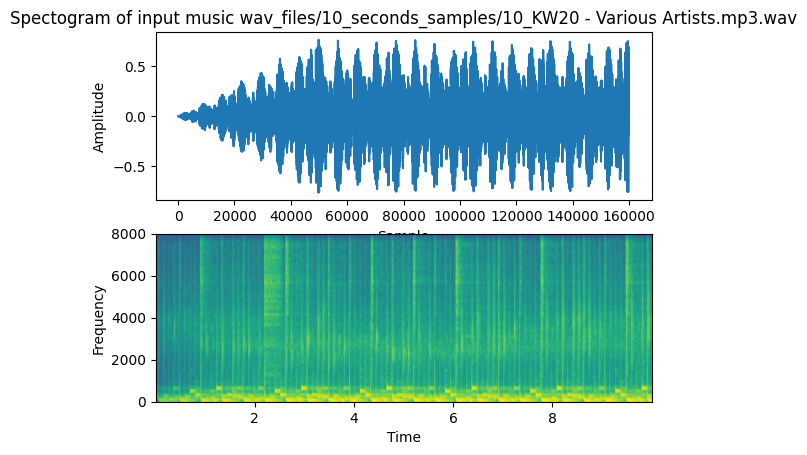

In [75]:
import matplotlib.pyplot as plot

 

# Plot the signal read from wav file

plot.subplot(211)

plot.title('Spectogram of input music {}'.format(inp_file))

 

plot.plot(waveform)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

 

plot.subplot(212)

plot.specgram(waveform,Fs=16000)

plot.xlabel('Time')

plot.ylabel('Frequency')

 

plot.show()

 

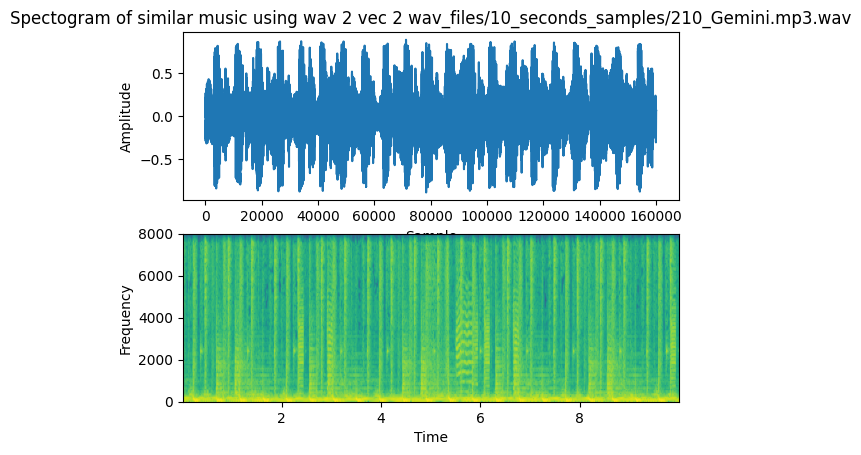

In [76]:
# Plot the signal read from wav file

plot.subplot(211)

plot.title('Spectogram of similar music using wav 2 vec 2 {}'.format(matched_file_wav))

waveform, sample_rate = torchaudio.load(matched_file_wav)
waveform = waveform.squeeze().numpy()

plot.plot(waveform)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

 

plot.subplot(212)

plot.specgram(waveform,Fs=16000)

plot.xlabel('Time')

plot.ylabel('Frequency')

 

plot.show()

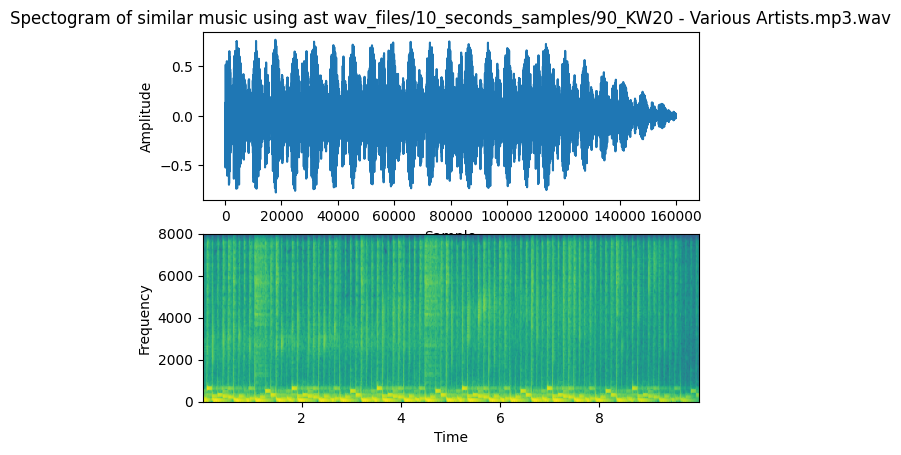

In [77]:
plot.subplot(211)

plot.title('Spectogram of similar music using ast {}'.format(matched_file_ast))

waveform, sample_rate = torchaudio.load(matched_file_ast)
waveform = waveform.squeeze().numpy()

plot.plot(waveform)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

 

plot.subplot(212)

plot.specgram(waveform,Fs=16000)

plot.xlabel('Time')

plot.ylabel('Frequency')

 

plot.show()

In [59]:
import numpy as np
from docarray import DocumentArray
from docarray import base

docs = DocumentArray.empty(index_ast.ntotal)

In [ ]:
docs.embeddings

In [50]:
docs.embeddings = embeddings_ast

In [ ]:
docs.

In [58]:
docs.plot_embeddings(port=8892, host='0.0.0.0')

/home/ubuntu/audio_llm/venv/lib/python3.10/site-packages/docarray/array/mixins/plot.py:277: UserWarning: Showing iframe in cell, you may want to open http://0.0.0.0:8892/static/index.html?config=config.json in a new tab for better experience. Also, `localhost` may need to be changed to the IP address if your jupyter is running remotely. Click "stop" button in the toolbar to move to the next cell.
  warnings.warn(


KeyboardInterrupt: 

## Building a network with similarity between tracks up to top 20

### Build a network between song, sample and similarity between other samples

In [20]:
from neo4j import GraphDatabase

In [21]:
GRAPH_DB_CREDS = {
    "HOST":os.environ['NEO4J_HOST'],
    "USER" :  os.environ['NEO4J_USER'],
    "PASSWORD": os.environ['NEO4J_PASSWORD']
}

In [119]:
class Neo:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.session = self.driver.session()


    def close(self):
        self.driver.close()

    def run_read(self, fx_name, **kwargs):
        results = None
        session = self.driver.session()
        results = session.read_transaction(fx_name, **kwargs)
        return results

    def run_write(self, fx_name, **kwargs):
        results = None
        session = self.driver.session()
        results = session.write_transaction(fx_name, **kwargs)
        return results

    def run_mult(self, queries, **kwargs):
        tx = self.driver.session().begin_transaction()
        try:
            for query in queries:
                result = tx.run(query)
                print(result.data())
            tx.commit()
        except Exception as ex:
            tx.rollback()
            print("couldn't run the command")
            print(ex)
        tx.close()

    def run_query(self, query, **kwargs):   
#         data = None
        try:
            tx = self.session.begin_transaction(timeout=300)
            result = tx.run(query, **kwargs)
            data = result.to_df()
            tx.commit()
            tx.close()
            return data
        except Exception as ex:
            print("couldn't run the command")
            print(ex)
            print(query)
            return query

    
    def run_query_graph(self, query, **kwargs):   
#         data = None
        try:
            tx = self.session.begin_transaction(timeout=300)
            result = tx.run(query, **kwargs)
            return result, tx
        except Exception as ex:
            print("couldn't run the command")
            print(ex)
            print(query)
            return query
    
    def run_queries(self, queries, **kwargs):
        count = 1
        for q in queries:
            try:
                print(f"pushing company no. {count}")
                self.session.run(q)
            except Exception as ex:
                print("couldn't run the command")
                print(ex)
                print(q)
            count += 1
        print(f"Ran total queries: {len(queries)}")

In [120]:
db = Neo(GRAPH_DB_CREDS["HOST"],GRAPH_DB_CREDS["USER"], GRAPH_DB_CREDS["PASSWORD"])

## First create the song, samples nodes and then relationship between the song and its samples

## CREATING AUDIO NDOES

In [25]:
SONG_SAMPLE_QUERY ="""CREATE (a:audio 
                           {name:$track_name}
                           ) RETURN ID(a) as node_id"""

In [83]:
song_node_to_samples_association = []
song_node_created_dict = {}
for files in os.listdir(dest_dir):
    try:
        print("Processing file {}".format(files))
        song_name_split = ' '.join(files.split('_')[1:]).strip()
        if song_name_split in song_node_created_dict.keys():
            song_node_id = song_node_created_dict[song_name_split]
        else:
            result_match = db.run_query(
                SONG_SAMPLE_QUERY, 
                track_name = song_name_split
            )
            if len(result_match) > 0:
                song_node_id = result_match.iloc[0]['node_id']
            
            song_node_created_dict[song_name_split] = song_node_id
        
        result_match = db.run_query(
            SONG_SAMPLE_QUERY, 
            track_name = files
        )
        
        if len(result_match) > 0:
            sample_node_id = result_match.iloc[0]['node_id']
        print("Created node for {} with audio id {} and sample id {}".format(files, song_node_id, sample_node_id))
        song_sample_dict = {'song_node_id':song_node_id, 'sample_node_id':sample_node_id}
        song_node_to_samples_association.append(song_sample_dict)
    except Exception as e:
        print(e)
        continue

Processing file 260_Trinidad Dreams.mp3.wav
Created node for 260_Trinidad Dreams.mp3.wav with audio id 9875 and sample id 9876
Processing file 390_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav
Created node for 390_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with audio id 9877 and sample id 9878
Processing file 20_Trinidad Dreams.mp3.wav
Created node for 20_Trinidad Dreams.mp3.wav with audio id 9875 and sample id 9879
Processing file 390_Dalfie - Cant Think Right Now [PETS103].mp3.wav
Created node for 390_Dalfie - Cant Think Right Now [PETS103].mp3.wav with audio id 9880 and sample id 9881
Processing file 30_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav
Created node for 30_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with audio id 9882 and sample id 9883
Processing file 240_Night Glitches.mp3.wav
Created node for 240_Night Glitches.mp3.wav with audio id 9884 and sample id 9885
Proces

Created node for 200_Marea (we’ve lost dancing).mp3.wav with audio id 9978 and sample id 9979
Processing file 500_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav
Created node for 500_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with audio id 9980 and sample id 9981
Processing file 260_Dust.mp3.wav
Created node for 260_Dust.mp3.wav with audio id 9982 and sample id 9983
Processing file 510_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav
Created node for 510_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with audio id 9892 and sample id 9984
Processing file 10_Das Talent.mp3.wav
Created node for 10_Das Talent.mp3.wav with audio id 9985 and sample id 9986
Processing file 220_Modern Soul (Monumental Men Edit).mp3.wav
Created node for 220_Modern Soul (Monumental Men Edit).mp3.wav with audio id 9987 and sample id 9988
Processing file 160_Jem Haynes - Late Night Story (Web Edit).mp3.wav
Created node for 160_Jem Haynes 

Created node for 380_1. Ben Böhmer - Der Blender.mp3.wav with audio id 9976 and sample id 10067
Processing file 20_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav
Created node for 20_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with audio id 10068 and sample id 10069
Processing file 370_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav
Created node for 370_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with audio id 10070 and sample id 10071
Processing file 250_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav
Created node for 250_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with audio id 10072 and sample id 10073
Processing file 240_Pappelallee - Orca.mp3.wav
Created node for 240_Pappelallee - Orca.mp3.wav with audio id 9955 and sample id 10074
Processing file 160_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav
Created node for 160_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with au

Created node for 200_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with audio id 10138 and sample id 10154
Processing file 90_Jon Hester - Heater.mp3.wav
Created node for 90_Jon Hester - Heater.mp3.wav with audio id 10155 and sample id 10156
Processing file 60_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav
Created node for 60_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with audio id 10157 and sample id 10158
Processing file 170_Flashlight.mp3.wav
Created node for 170_Flashlight.mp3.wav with audio id 10148 and sample id 10159
Processing file 60_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav
Created node for 60_Ray Okpara - Satin Curtain (Kevin Yost Remix).mp3.wav with audio id 10160 and sample id 10161
Processing file 50_Palinodia - Spinning Voices (Ten System Remix).mp3.wav
Created node for 50_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with audio id 10162 and sample id 101

Created node for 70_Vision.mp3.wav with audio id 10239 and sample id 10240
Processing file 10_HOSH - Karma.mp3.wav
Created node for 10_HOSH - Karma.mp3.wav with audio id 10185 and sample id 10241
Processing file 160_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav
Created node for 160_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with audio id 9999 and sample id 10242
Processing file 130_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav
Created node for 130_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with audio id 10243 and sample id 10244
Processing file 90_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav
Created node for 90_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with audio id 10048 and sample id 10245
Processing file 10_Sanchä - Carpe (Original Mix).mp3.wav
Created node for 10_Sanchä - Carpe (Original Mix).mp3.wav with audio id 10246 and sample id 10247
Processing file 1

Created node for 90_Mikalogic - Spaceship Graveyard.mp3.wav with audio id 9943 and sample id 10325
Processing file 40_01 Ben Böhmer - Wechselwerk.mp3.wav
Created node for 40_01 Ben Böhmer - Wechselwerk.mp3.wav with audio id 10303 and sample id 10326
Processing file 80_Domino (Rework) - Sapiens 02.mp3.wav
Created node for 80_Domino (Rework) - Sapiens 02.mp3.wav with audio id 10327 and sample id 10328
Processing file 1190_Mix 09:2013.mp3.mp3.wav
Created node for 1190_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 10329
Processing file 410_Ben Böhmer - Flug & Fall.mp3.wav
Created node for 410_Ben Böhmer - Flug & Fall.mp3.wav with audio id 10330 and sample id 10331
Processing file 270_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav
Created node for 270_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with audio id 10108 and sample id 10332
Processing file 160_Dalfie - Carmina.mp3.wav
Created node for 160_Dalfie - Carmina.mp3.wav with audio

Created node for 260_Jon Hester - Equinox.mp3.wav with audio id 10396 and sample id 10397
Processing file 2040_Mix 09:2013.mp3.mp3.wav
Created node for 2040_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 10398
Processing file 2030_KW20 - Various Artists.mp3.wav
Created node for 2030_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 10399
Processing file 150_Gdansk.mp3.wav
Created node for 150_Gdansk.mp3.wav with audio id 10187 and sample id 10400
Processing file 150_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav
Created node for 150_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with audio id 10126 and sample id 10401
Processing file 350_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav
Created node for 350_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with audio id 9892 and sample id 10402
Processing file 30_Night Glitches.mp3.wav
Created node for 30_Night Glitches.mp3.wav with audi

Created node for 100_Dust.mp3.wav with audio id 9982 and sample id 10465
Processing file 90_Ben Böhmer - After Earth.mp3.wav
Created node for 90_Ben Böhmer - After Earth.mp3.wav with audio id 10054 and sample id 10466
Processing file 350_Audiojack - First Flight.mp3.wav
Created node for 350_Audiojack - First Flight.mp3.wav with audio id 10467 and sample id 10468
Processing file 260_Palinodia - Spinning Voices (Ten System Remix).mp3.wav
Created node for 260_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with audio id 10162 and sample id 10469
Processing file 290_Ben Böhmer - Flug & Fall.mp3.wav
Created node for 290_Ben Böhmer - Flug & Fall.mp3.wav with audio id 10330 and sample id 10470
Processing file 330_B2. Jon Hester - Neurons.mp3.wav
Created node for 330_B2. Jon Hester - Neurons.mp3.wav with audio id 9961 and sample id 10471
Processing file 210_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav
Created node for 210_Olivier Giacomotto & J Diesel - Pure F

Created node for 460_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with audio id 9980 and sample id 10534
Processing file 200_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav
Created node for 200_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with audio id 10172 and sample id 10535
Processing file 410_Innervoix - Reality (Original Mix).mp3.wav
Created node for 410_Innervoix - Reality (Original Mix).mp3.wav with audio id 10078 and sample id 10536
Processing file 200_Pulchra.mp3.wav
Created node for 200_Pulchra.mp3.wav with audio id 10405 and sample id 10537
Processing file 280_Ray of Hope (Original Mix).mp3.wav
Created node for 280_Ray of Hope (Original Mix).mp3.wav with audio id 10423 and sample id 10538
Processing file 280_Huxley - Weirdest Geen.mp3.wav
Created node for 280_Huxley - Weirdest Geen.mp3.wav with audio id 10344 and sample id 10539
Processing file 110_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav
Created node for 110_Facing The Sun 

Created node for 130_SIS - The Blind Side.mp3.wav with audio id 10296 and sample id 10602
Processing file 170_Lost Rhythm - Aetheria (Original Mix).mp3.wav
Created node for 170_Lost Rhythm - Aetheria (Original Mix).mp3.wav with audio id 10546 and sample id 10603
Processing file 260_Dvlex - On The D Floor.mp3.wav
Created node for 260_Dvlex - On The D Floor.mp3.wav with audio id 10433 and sample id 10604
Processing file 130_Jon Hester - Rain.mp3.wav
Created node for 130_Jon Hester - Rain.mp3.wav with audio id 9938 and sample id 10605
Processing file 270_Weird (Unweird Mix).mp3.wav
Created node for 270_Weird (Unweird Mix).mp3.wav with audio id 10430 and sample id 10606
Processing file 60_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav
Created node for 60_Rick Pier ONeil - Something Wrong (Mauro Aguirre Remix) - Clubsonica Records.mp3.wav with audio id 10123 and sample id 10607
Processing file 120_Black Hertz - Take My Soul (Prevision Remix).mp3.wav
Cre

Created node for 140_Ben Böhmer - After Earth.mp3.wav with audio id 10054 and sample id 10670
Processing file 170_Parple - Believe.mp3.wav
Created node for 170_Parple - Believe.mp3.wav with audio id 10462 and sample id 10671
Processing file 50_Athea - Mind Games (Mario Aureo Remix).mp3.wav
Created node for 50_Athea - Mind Games (Mario Aureo Remix).mp3.wav with audio id 10169 and sample id 10672
Processing file 460_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav
Created node for 460_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with audio id 10108 and sample id 10673
Processing file 30_1. Ben Böhmer - Der Blender.mp3.wav
Created node for 30_1. Ben Böhmer - Der Blender.mp3.wav with audio id 9976 and sample id 10674
Processing file 3110_Mix 09:2013.mp3.mp3.wav
Created node for 3110_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 10675
Processing file 100_Depth Of Silence.mp3.wav
Created node for 100_Depth Of Silence.mp3.wav with audio id

Created node for 80_Asphere - Valyria.mp3.wav with audio id 10288 and sample id 10737
Processing file 290_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav
Created node for 290_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with audio id 9980 and sample id 10738
Processing file 200_Jon Hester - Heater.mp3.wav
Created node for 200_Jon Hester - Heater.mp3.wav with audio id 10155 and sample id 10739
Processing file 160_Grey Waves.mp3.wav
Created node for 160_Grey Waves.mp3.wav with audio id 10006 and sample id 10740
Processing file 110_A2. Jon Hester - On The Move.mp3.wav
Created node for 110_A2. Jon Hester - On The Move.mp3.wav with audio id 9936 and sample id 10741
Processing file 900_KW20 - Various Artists.mp3.wav
Created node for 900_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 10742
Processing file 230_Depth Of Silence.mp3.wav
Created node for 230_Depth Of Silence.mp3.wav with audio id 10216 and sample id 10743
Processing file 300_Vision.mp3.

Created node for 490_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with audio id 10263 and sample id 10805
Processing file 280_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav
Created node for 280_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with audio id 10157 and sample id 10806
Processing file 180_Thomas Lizzara - Pilatus.mp3.wav
Created node for 180_Thomas Lizzara - Pilatus.mp3.wav with audio id 10807 and sample id 10808
Processing file 10_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav
Created node for 10_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with audio id 10809 and sample id 10810
Processing file 250_Orthoptera.mp3.wav
Created node for 250_Orthoptera.mp3.wav with audio id 10764 and sample id 10811
Processing file 50_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav
Created node for 50_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with audio 

Created node for 310_Jon Hester - Stealth.mp3.wav with audio id 10253 and sample id 10873
Processing file 110_Menson - TS (Orignal Mix).mp3.wav
Created node for 110_Menson - TS (Orignal Mix).mp3.wav with audio id 10004 and sample id 10874
Processing file 240_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav
Created node for 240_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with audio id 10233 and sample id 10875
Processing file 170_Second Change - Diversions Music 09.mp3.wav
Created node for 170_Second Change - Diversions Music 09.mp3.wav with audio id 10346 and sample id 10876
Processing file 280_Vision.mp3.wav
Created node for 280_Vision.mp3.wav with audio id 10239 and sample id 10877
Processing file 140_Trinidad Dreams.mp3.wav
Created node for 140_Trinidad Dreams.mp3.wav with audio id 9875 and sample id 10878
Processing file 160_Audiojack - Higher.mp3.wav
Created node for 160_Audiojack - Higher.mp3.wav with audio id 10474 and sample id 10879
Processing file

Created node for 260_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with audio id 9980 and sample id 10941
Processing file 140_KW20 - Various Artists.mp3.wav
Created node for 140_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 10942
Processing file 450_GHEIST - Blue Petrel | Exploited.mp3.wav
Created node for 450_GHEIST - Blue Petrel | Exploited.mp3.wav with audio id 9953 and sample id 10943
Processing file 220_Kölsch & Tiga - HAL.mp3.wav
Created node for 220_Kölsch & Tiga - HAL.mp3.wav with audio id 10083 and sample id 10944
Processing file 40_Alan Fitzpatrick Reflections.mp3.wav
Created node for 40_Alan Fitzpatrick Reflections.mp3.wav with audio id 10270 and sample id 10945
Processing file 310_Menson - TS (Orignal Mix).mp3.wav
Created node for 310_Menson - TS (Orignal Mix).mp3.wav with audio id 10004 and sample id 10946
Processing file 60_01 Ben Böhmer - Wechselwerk.mp3.wav
Created node for 60_01 Ben Böhmer - Wechselwerk.mp3.wav with audio id 10303 an

Created node for 310_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with audio id 9877 and sample id 11009
Processing file 120_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav
Created node for 120_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with audio id 10072 and sample id 11010
Processing file 150_Trigger.mp3.wav
Created node for 150_Trigger.mp3.wav with audio id 10121 and sample id 11011
Processing file 290_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav
Created node for 290_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with audio id 10111 and sample id 11012
Processing file 320_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav
Created node for 320_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with audio id 10126 and sample id 11013
Processing file 260_Sanchä - Ingravity (Original Mix).mp3.wav
Created node for 260_Sanchä - Ingravity (Original

Created node for 300_Proelium [Awen Tales].mp3.wav with audio id 10056 and sample id 11076
Processing file 400_GHEIST - Blue Petrel | Exploited.mp3.wav
Created node for 400_GHEIST - Blue Petrel | Exploited.mp3.wav with audio id 9953 and sample id 11077
Processing file 180_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav
Created node for 180_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with audio id 10070 and sample id 11078
Processing file 100_Acid Rain.mp3.wav
Created node for 100_Acid Rain.mp3.wav with audio id 10008 and sample id 11079
Processing file 210_Weird (Unweird Mix).mp3.wav
Created node for 210_Weird (Unweird Mix).mp3.wav with audio id 10430 and sample id 11080
Processing file 230_Caribou - Mars.mp3.wav
Created node for 230_Caribou - Mars.mp3.wav with audio id 10848 and sample id 11081
Processing file 110_Ben Böhmer - Mondfinsternis.mp3.wav
Created node for 110_Ben Böhmer - Mondfinsternis.mp3.wav with audio id 10228 and sample id 11082
Processing file 

Created node for 220_Lost Rhythm - Aetheria (Original Mix).mp3.wav with audio id 10546 and sample id 11127
Processing file 320_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav
Created node for 320_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with audio id 9913 and sample id 11128
Processing file 140_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav
Created node for 140_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with audio id 10450 and sample id 11129
Processing file 930_Mix 09:2013.mp3.mp3.wav
Created node for 930_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 11130
Processing file 330_Phaeton.mp3.wav
Created node for 330_Phaeton.mp3.wav with audio id 10224 and sample id 11131
Processing file 330_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav
Created node for 330_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with audio id 10233 and sample id 11132
Processing file 

Created node for 360_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with audio id 10243 and sample id 11178
Processing file 100_Delilah (pull me out of this).mp3.wav
Created node for 100_Delilah (pull me out of this).mp3.wav with audio id 10196 and sample id 11179
Processing file 320_Ben Böhmer - Purple Line.mp3.wav
Created node for 320_Ben Böhmer - Purple Line.mp3.wav with audio id 10058 and sample id 11180
Processing file 70_Jon Hester - Heater.mp3.wav
Created node for 70_Jon Hester - Heater.mp3.wav with audio id 10155 and sample id 11181
Processing file 190_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav
Created node for 190_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with audio id 10020 and sample id 11182
Processing file 2360_Mix 09:2013.mp3.mp3.wav
Created node for 2360_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 11183
Processing file 530_Michel Cleis - La Mezcla (feat. Totó La Mom

Created node for 140_James Cole - Miss You feat. E-Soreni.mp3.wav with audio id 9904 and sample id 11246
Processing file 410_Trinidad Dreams.mp3.wav
Created node for 410_Trinidad Dreams.mp3.wav with audio id 9875 and sample id 11247
Processing file 130_Kerala.mp3.wav
Created node for 130_Kerala.mp3.wav with audio id 10939 and sample id 11248
Processing file 400_Keep A Movin.mp3.wav
Created node for 400_Keep A Movin.mp3.wav with audio id 10426 and sample id 11249
Processing file 550_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav
Created node for 550_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with audio id 10018 and sample id 11250
Processing file 30_Feel & Frondorf - Equality.mp3.wav
Created node for 30_Feel & Frondorf - Equality.mp3.wav with audio id 10206 and sample id 11251
Processing file 140_Gemini.mp3.wav
Created node for 140_Gemini.mp3.wav with audio id 10351 and sample id 11252
Processing file 320_SIS - The Blind Side.mp3.wav
Created node fo

Created node for 110_Audiojack - First Flight.mp3.wav with audio id 10467 and sample id 11297
Processing file 310_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav
Created node for 310_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with audio id 11188 and sample id 11298
Processing file 20_B1 Jon Hester - A Distant Spark.mp3.wav
Created node for 20_B1 Jon Hester - A Distant Spark.mp3.wav with audio id 11299 and sample id 11300
Processing file 240_together.mp3.wav
Created node for 240_together.mp3.wav with audio id 10041 and sample id 11301
Processing file 80_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav
Created node for 80_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with audio id 10038 and sample id 11302
Processing file 1430_KW20 - Various Artists.mp3.wav
Created node for 1430_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 11303
Processing file 380_Samuel L Session - Can You Relate (Joris Voorn Flooding The Mark

Created node for 50_Audiojack - Higher.mp3.wav with audio id 10474 and sample id 11365
Processing file 160_Jon Hester - Expanse.mp3.wav
Created node for 160_Jon Hester - Expanse.mp3.wav with audio id 10106 and sample id 11366
Processing file 450_Ben Böhmer - After Earth.mp3.wav
Created node for 450_Ben Böhmer - After Earth.mp3.wav with audio id 10054 and sample id 11367
Processing file 270_Innervoix - Reality (Original Mix).mp3.wav
Created node for 270_Innervoix - Reality (Original Mix).mp3.wav with audio id 10078 and sample id 11368
Processing file 350_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav
Created node for 350_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with audio id 10530 and sample id 11369
Processing file 50_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav
Created node for 50_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with a

Created node for 80_Jon Hester - Heater.mp3.wav with audio id 10155 and sample id 11416
Processing file 310_2. Ben Böhmer - Wagnis.mp3.wav
Created node for 310_2. Ben Böhmer - Wagnis.mp3.wav with audio id 10491 and sample id 11417
Processing file 300_Jay Lumen - Meteo (Original Mix).mp3.wav
Created node for 300_Jay Lumen - Meteo (Original Mix).mp3.wav with audio id 10375 and sample id 11418
Processing file 290_A1. Jon Hester - Inertia.mp3.wav
Created node for 290_A1. Jon Hester - Inertia.mp3.wav with audio id 9894 and sample id 11419
Processing file 50_together.mp3.wav
Created node for 50_together.mp3.wav with audio id 10041 and sample id 11420
Processing file 280_Ben Böhmer - Autumn.mp3.wav
Created node for 280_Ben Böhmer - Autumn.mp3.wav with audio id 9908 and sample id 11421
Processing file 70_Magnetism.mp3.wav
Created node for 70_Magnetism.mp3.wav with audio id 10394 and sample id 11422
Processing file 30_B1 Jon Hester - Stratospheric (Snippet).mp3.wav
Created node for 30_B1 Jo

Created node for 340_Sasha - Trigonometry (La Fleur Remix).mp3.wav with audio id 10183 and sample id 11467
Processing file 200_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav
Created node for 200_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with audio id 10111 and sample id 11468
Processing file 540_Gemini.mp3.wav
Created node for 540_Gemini.mp3.wav with audio id 10351 and sample id 11469
Processing file 40_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav
Created node for 40_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with audio id 10140 and sample id 11470
Processing file 170_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav
Created node for 170_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with audio id 10088 and sample id 11471
Processing file 40_Domino (Rework) - Sapiens 02.mp3.wav
Created node for 40_Domino (Rework) - Sapiens 02.mp3.wav with audio id 10327 and sample i

Created node for 250_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with audio id 10142 and sample id 11518
Processing file 40_Alfonso Muchacho - Life Below (Original Mix).mp3.wav
Created node for 40_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with audio id 10263 and sample id 11519
Processing file 220_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav
Created node for 220_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with audio id 10175 and sample id 11520
Processing file 40_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav
Created node for 40_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav with audio id 10279 and sample id 11521
Processing file 170_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav
Created node for 170_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with audio id 9957 and sample id 11522
Processing file 350_Oliver Schories - Bengalo.mp3.wav
Created node for 350_Oliver Schories - Bengalo

Created node for 150_Jon Hester - Sirens.mp3.wav with audio id 9919 and sample id 11586
Processing file 100_Emil Berliner - Meuterei.mp3.wav
Created node for 100_Emil Berliner - Meuterei.mp3.wav with audio id 10024 and sample id 11587
Processing file 350_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav
Created node for 350_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with audio id 10243 and sample id 11588
Processing file 590_Mix 09:2013.mp3.mp3.wav
Created node for 590_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 11589
Processing file 140_Huxley - Weirdest Geen.mp3.wav
Created node for 140_Huxley - Weirdest Geen.mp3.wav with audio id 10344 and sample id 11590
Processing file 310_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav
Created node for 310_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with audio id 10088 and sample id 11591
Processing file 60_KW20 - Various Artists.mp3.wav
Created node for 60_KW

Created node for 250_Dom Dolla - Take It (Extended Mix).mp3.wav with audio id 9969 and sample id 11637
Processing file 90_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav
Created node for 90_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with audio id 10076 and sample id 11638
Processing file 30_Ben Böhmer - After Earth.mp3.wav
Created node for 30_Ben Böhmer - After Earth.mp3.wav with audio id 10054 and sample id 11639
Processing file 230_Jon Hester - Zoned.mp3.wav
Created node for 230_Jon Hester - Zoned.mp3.wav with audio id 10098 and sample id 11640
Processing file 60_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav
Created node for 60_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with audio id 10172 and sample id 11641
Processing file 200_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav
Created node for 200_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with audio id 99

Created node for 80_Gemini.mp3.wav with audio id 10351 and sample id 11688
Processing file 410_Black Hertz - Take My Soul (Prevision Remix).mp3.wav
Created node for 410_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with audio id 10294 and sample id 11689
Processing file 420_Ben Böhmer - Dive feat. Margret.mp3.wav
Created node for 420_Ben Böhmer - Dive feat. Margret.mp3.wav with audio id 10036 and sample id 11690
Processing file 130_Venen.mp3.wav
Created node for 130_Venen.mp3.wav with audio id 10191 and sample id 11691
Processing file 190_Jon Hester - Tension Wire.mp3.wav
Created node for 190_Jon Hester - Tension Wire.mp3.wav with audio id 9915 and sample id 11692
Processing file 110_Infinity.mp3.wav
Created node for 110_Infinity.mp3.wav with audio id 10380 and sample id 11693
Processing file 160_Weird (Unweird Mix).mp3.wav
Created node for 160_Weird (Unweird Mix).mp3.wav with audio id 10430 and sample id 11694
Processing file 410_Parple - Believe.mp3.wav
Created node for 410_

Created node for 340_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with audio id 9959 and sample id 11740
Processing file 30_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav
Created node for 30_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with audio id 10460 and sample id 11741
Processing file 200_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav
Created node for 200_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with audio id 9951 and sample id 11742
Processing file 90_Universe.mp3.wav
Created node for 90_Universe.mp3.wav with audio id 10454 and sample id 11743
Processing file 3040_Mix 09:2013.mp3.mp3.wav
Created node for 3040_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 11744
Processing file 270_Open Your Eyes.mp3.wav
Created node for 270_Open Your Eyes.mp3.wav with audio id 10566 and sample id 11745
Processing file 170_Trinidad Dreams.mp3.wav
Created node for 170_Trinidad Dreams.mp3.wav with aud

Created node for 3180_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 11807
Processing file 480_GHEIST - Blue Petrel | Exploited.mp3.wav
Created node for 480_GHEIST - Blue Petrel | Exploited.mp3.wav with audio id 9953 and sample id 11808
Processing file 60_Universe.mp3.wav
Created node for 60_Universe.mp3.wav with audio id 10454 and sample id 11809
Processing file 330_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav
Created node for 330_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with audio id 10088 and sample id 11810
Processing file 280_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav
Created node for 280_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with audio id 10061 and sample id 11811
Processing file 280_Himmelblau - Lapis (Original Mix).mp3.wav
Created node for 280_Himmelblau - Lapis (Original Mix).mp3.wav with audio id 9995 and sample id 11812
Processing file 170_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].

Created node for 190_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with audio id 10126 and sample id 11858
Processing file 320_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav
Created node for 320_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with audio id 10070 and sample id 11859
Processing file 360_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav
Created node for 360_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with audio id 10233 and sample id 11860
Processing file 10_Jay Lumen - Meteo (Original Mix).mp3.wav
Created node for 10_Jay Lumen - Meteo (Original Mix).mp3.wav with audio id 10375 and sample id 11861
Processing file 20_Re.You - The Night We Met (MHD115).mp3.wav
Created node for 20_Re.You - The Night We Met (MHD115).mp3.wav with audio id 9965 and sample id 11862
Processing file 250_Ben Böhmer - Soulline.mp3.wav
Created node for 250_Ben Böhmer - Soulline.mp3.wav with audio id 10768 and sample id 11863
Processing

Created node for 150_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with audio id 9896 and sample id 11909
Processing file 280_Jon Hester - Haze.mp3.wav
Created node for 280_Jon Hester - Haze.mp3.wav with audio id 10093 and sample id 11910
Processing file 90_Jon Hester - Wonder.mp3.wav
Created node for 90_Jon Hester - Wonder.mp3.wav with audio id 9973 and sample id 11911
Processing file 240_Tibi Dabo - La Dorada.mp3.wav
Created node for 240_Tibi Dabo - La Dorada.mp3.wav with audio id 10957 and sample id 11912
Processing file 350_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav
Created node for 350_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with audio id 10378 and sample id 11913
Processing file 10_Ben Böhmer - Flug & Fall.mp3.wav
Created node for 10_Ben Böhmer - Flug & Fall.mp3.wav with audio id 10330 and sample id 11914
Processing file 240_Oxia & Nicolas

Created node for 280_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with audio id 10179 and sample id 11960
Processing file 370_SIS - The Blind Side.mp3.wav
Created node for 370_SIS - The Blind Side.mp3.wav with audio id 10296 and sample id 11961
Processing file 170_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav
Created node for 170_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with audio id 10419 and sample id 11962
Processing file 20_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav
Created node for 20_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with audio id 10108 and sample id 11963
Processing file 270_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav
Created node for 270_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with audio id 10233 and sample id 11964
Processing file 70_Second Change - Diversions Music 09.mp3.

Created node for 10_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with audio id 10175 and sample id 12011
Processing file 200_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav
Created node for 200_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with audio id 9886 and sample id 12012
Processing file 360_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav
Created node for 360_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with audio id 10030 and sample id 12013
Processing file 200_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav
Created node for 200_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with audio id 9911 and sample id 12014
Processing file 440_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav
Created node for 440_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with audio id 10651 and sample id 12015
Processing file 450_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav
Created 

Created node for 150_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with audio id 10072 and sample id 12062
Processing file 80_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav
Created node for 80_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with audio id 10157 and sample id 12063
Processing file 30_Kölsch - Loreley - Original Mix.mp3.wav
Created node for 30_Kölsch - Loreley - Original Mix.mp3.wav with audio id 12064 and sample id 12065
Processing file 450_1. Ben Böhmer - Der Blender.mp3.wav
Created node for 450_1. Ben Böhmer - Der Blender.mp3.wav with audio id 9976 and sample id 12066
Processing file 210_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav
Created node for 210_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with audio id 11196 and sample id 12067
Processing file 70_Jon Hester - Contact.mp3.wav
Created node for 70_Jon Hester - Contact.mp3.wav with audio id 10482 and sample id 12068
Pr

Created node for 80_Re.You - The Night We Met (MHD115).mp3.wav with audio id 9965 and sample id 12114
Processing file 450_Ben Böhmer - Purple Line.mp3.wav
Created node for 450_Ben Böhmer - Purple Line.mp3.wav with audio id 10058 and sample id 12115
Processing file 180_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav
Created node for 180_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with audio id 10530 and sample id 12116
Processing file 230_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav
Created node for 230_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with audio id 11196 and sample id 12117
Processing file 110_Jon Hester - Equinox.mp3.wav
Created node for 110_Jon Hester - Equinox.mp3.wav with audio id 10396 and sample id 12118
Processing file 180_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav
Created node for 180_Iman

Created node for 100_Grey Waves.mp3.wav with audio id 10006 and sample id 12165
Processing file 310_Grey Waves.mp3.wav
Created node for 310_Grey Waves.mp3.wav with audio id 10006 and sample id 12166
Processing file 450_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav
Created node for 450_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with audio id 10022 and sample id 12167
Processing file 210_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav
Created node for 210_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with audio id 10933 and sample id 12168
Processing file 370_B1. Jon Hester - Short Circuit.mp3.wav
Created node for 370_B1. Jon Hester - Short Circuit.mp3.wav with audio id 10259 and sample id 12169
Processing file 50_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav
Created node for 50_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with audio id

Created node for 170_Alan Fitzpatrick Reflections.mp3.wav with audio id 10270 and sample id 12216
Processing file 220_01 Ben Böhmer - Wechselwerk.mp3.wav
Created node for 220_01 Ben Böhmer - Wechselwerk.mp3.wav with audio id 10303 and sample id 12217
Processing file 420_Orthoptera.mp3.wav
Created node for 420_Orthoptera.mp3.wav with audio id 10764 and sample id 12218
Processing file 3170_Mix 09:2013.mp3.mp3.wav
Created node for 3170_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 12219
Processing file 120_Marea (we’ve lost dancing).mp3.wav
Created node for 120_Marea (we’ve lost dancing).mp3.wav with audio id 9978 and sample id 12220
Processing file 110_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav
Created node for 110_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with audio id 10131 and sample id 12221
Processing file 350_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav
Created node for 350_Rony Seikaly - Flyin

Created node for 460_Parple - Believe.mp3.wav with audio id 10462 and sample id 12266
Processing file 350_A Pinch Of Spice.mp3.wav
Created node for 350_A Pinch Of Spice.mp3.wav with audio id 10032 and sample id 12267
Processing file 160_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav
Created node for 160_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with audio id 10460 and sample id 12268
Processing file 140_My Path.mp3.wav
Created node for 140_My Path.mp3.wav with audio id 10722 and sample id 12269
Processing file 200_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav
Created node for 200_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with audio id 10208 and sample id 12270
Processing file 130_Weird (Unweird Mix).mp3.wav
Created node for 130_Weird (Unweird Mix).mp3.wav with audio id 10430 and sample id 12271
Processing file 180_Acid Rain.mp3.wav
Created node for 180_Acid Rain.mp3.wav with audio id 10008 and sample id 12

Created node for 30_Ben Böhmer - Soulline.mp3.wav with audio id 10768 and sample id 12317
Processing file 150_Huxley - Weirdest Geen.mp3.wav
Created node for 150_Huxley - Weirdest Geen.mp3.wav with audio id 10344 and sample id 12318
Processing file 40_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav
Created node for 40_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with audio id 9896 and sample id 12319
Processing file 60_Inside My Brain.mp3.wav
Created node for 60_Inside My Brain.mp3.wav with audio id 10900 and sample id 12320
Processing file 170_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav
Created node for 170_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with audio id 10557 and sample id 12321
Processing file 350_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav
Created node for 350_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).m

Created node for 140_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with audio id 10030 and sample id 12369
Processing file 350_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav
Created node for 350_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with audio id 10450 and sample id 12370
Processing file 260_Jon Hester - Part 4.mp3.wav
Created node for 260_Jon Hester - Part 4.mp3.wav with audio id 10201 and sample id 12371
Processing file 280_Jon Hester - Wonder.mp3.wav
Created node for 280_Jon Hester - Wonder.mp3.wav with audio id 9973 and sample id 12372
Processing file 60_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav
Created node for 60_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with audio id 10447 and sample id 12373
Processing file 230_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav
Created node for 230_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with audio id 10068 and sample id 12374
Processing

Created node for 130_Ben Böhmer - Flug & Fall.mp3.wav with audio id 10330 and sample id 12422
Processing file 280_Love Temple (Copini Remix).mp3.wav
Created node for 280_Love Temple (Copini Remix).mp3.wav with audio id 10255 and sample id 12423
Processing file 10_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav
Created node for 10_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with audio id 10233 and sample id 12424
Processing file 190_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav
Created node for 190_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with audio id 10447 and sample id 12425
Processing file 2250_Mix 09:2013.mp3.mp3.wav
Created node for 2250_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 12426
Processing file 50_Trigger.mp3.wav
Created node for 50_Trigger.mp3.wav with audio id 10121 and sample id 12427
Processing file 320_Innervoix - Reality (Original Mix).mp3.wav
Created node for 320_Innervoix - Reality (Original

Created node for 130_B2 - Jon Hester - Ripple Effects.mp3.wav with audio id 12474 and sample id 12475
Processing file 2470_Mix 09:2013.mp3.mp3.wav
Created node for 2470_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 12476
Processing file 30_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav
Created node for 30_Jon Hester - Dimension Seven [MS085] (snippet).mp3.wav with audio id 10951 and sample id 12477
Processing file 120_Jon Hester - Lights Down.mp3.wav
Created node for 120_Jon Hester - Lights Down.mp3.wav with audio id 10555 and sample id 12478
Processing file 280_Jon Hester - Silver.mp3.wav
Created node for 280_Jon Hester - Silver.mp3.wav with audio id 10316 and sample id 12479
Processing file 330_Opulent (Precursor 4X4 Edit).mp3.wav
Created node for 330_Opulent (Precursor 4X4 Edit).mp3.wav with audio id 10440 and sample id 12480
Processing file 70_Alexander Aurel - Fall In Love.mp3.wav
Created node for 70_Alexander Aurel - Fall In Love.mp3.wav with audio id 10026 and

Created node for 120_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with audio id 10048 and sample id 12526
Processing file 190_Jon Hester - Silver.mp3.wav
Created node for 190_Jon Hester - Silver.mp3.wav with audio id 10316 and sample id 12527
Processing file 240_Magnetism.mp3.wav
Created node for 240_Magnetism.mp3.wav with audio id 10394 and sample id 12528
Processing file 200_ANASTASiiA - Obsidian.mp3.wav
Created node for 200_ANASTASiiA - Obsidian.mp3.wav with audio id 11311 and sample id 12529
Processing file 360_Jon Hester - Scrape.mp3.wav
Created node for 360_Jon Hester - Scrape.mp3.wav with audio id 9992 and sample id 12530
Processing file 10_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav
Created node for 10_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with audio id 10115 and sample id 12531
Processing file 270_Keep A Movin.mp3.wav
Created node for 270_Keep A Movin.mp3.wav with audio id 10426 and sample id 12532
P

Created node for 200_Jon Hester - Scrape.mp3.wav with audio id 9992 and sample id 12577
Processing file 370_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav
Created node for 370_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with audio id 10584 and sample id 12578
Processing file 390_Lost Rhythm - Aetheria (Original Mix).mp3.wav
Created node for 390_Lost Rhythm - Aetheria (Original Mix).mp3.wav with audio id 10546 and sample id 12579
Processing file 280_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav
Created node for 280_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with audio id 9949 and sample id 12580
Processing file 120_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav
Created node for 120_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with audio id 10020 and sample id 12581
Processing file 160_Jon Hester - Part 4.mp3.wav
Created node for 160_Jon Hester - P

Created node for 320_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with audio id 10086 and sample id 12628
Processing file 250_Second Change - Diversions Music 09.mp3.wav
Created node for 250_Second Change - Diversions Music 09.mp3.wav with audio id 10346 and sample id 12629
Processing file 300_HOSH - Karma.mp3.wav
Created node for 300_HOSH - Karma.mp3.wav with audio id 10185 and sample id 12630
Processing file 350_Opulent (Precursor 4X4 Edit).mp3.wav
Created node for 350_Opulent (Precursor 4X4 Edit).mp3.wav with audio id 10440 and sample id 12631
Processing file 90_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav
Created node for 90_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with audio id 9898 and sample id 12632
Processing file 180_Kokosölklappern.mp3.wav
Created node for 180_Kokosölklappern.mp3.wav with audio id 9928 and sample id 12633
Processing file 270_Alfonso Muchacho - Life Below (Original Mix).mp3.wav
Created node for

Created node for 270_Jon Hester - Instant.mp3.wav with audio id 10712 and sample id 12679
Processing file 230_Black Hertz - Take My Soul (Prevision Remix).mp3.wav
Created node for 230_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with audio id 10294 and sample id 12680
Processing file 70_Grey Waves.mp3.wav
Created node for 70_Grey Waves.mp3.wav with audio id 10006 and sample id 12681
Processing file 150_Jon Hester - Flex.mp3.wav
Created node for 150_Jon Hester - Flex.mp3.wav with audio id 10050 and sample id 12682
Processing file 480_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav
Created node for 480_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with audio id 10236 and sample id 12683
Processing file 480_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav
Created node for 480_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with audio id 10048 and sample id 12684
Processing file 2600_Mix 09:2013.mp3.mp3.wav
Created node f

Created node for 530_SIS - The Blind Side.mp3.wav with audio id 10296 and sample id 12748
Processing file 580_SIS - The Blind Side.mp3.wav
Created node for 580_SIS - The Blind Side.mp3.wav with audio id 10296 and sample id 12749
Processing file 230_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav
Created node for 230_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with audio id 10903 and sample id 12750
Processing file 400_Ben Böhmer - Mondfinsternis.mp3.wav
Created node for 400_Ben Böhmer - Mondfinsternis.mp3.wav with audio id 10228 and sample id 12751
Processing file 80_Weird (Unweird Mix).mp3.wav
Created node for 80_Weird (Unweird Mix).mp3.wav with audio id 10430 and sample id 12752
Processing file 40_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav
Created node for 40_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with audio id 10233 and sample id 12753
Processing file 150_Feel & Frondorf - Equality.mp3.wav
Created node for 150_Feel & Frondorf - Equality.mp3.wav with

Created node for 250_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with audio id 10263 and sample id 12799
Processing file 230_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav
Created node for 230_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with audio id 10358 and sample id 12800
Processing file 370_GHEIST - Blue Petrel | Exploited.mp3.wav
Created node for 370_GHEIST - Blue Petrel | Exploited.mp3.wav with audio id 9953 and sample id 12801
Processing file 190_Ben Böhmer - Soulline.mp3.wav
Created node for 190_Ben Böhmer - Soulline.mp3.wav with audio id 10768 and sample id 12802
Processing file 440_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav
Created node for 440_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with audio id 10018 and sample id 12803
Processing file 170_Asphere - Valyria.mp3.wav
Created node for 170_Asphere - Valyria.mp3.wav with audio id 10288 and sample id 12804
Processing file 80_Redondo & Ferreck Dawn - Tattoo Girl (OXI

Created node for 160_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with audio id 10903 and sample id 12850
Processing file 30_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav
Created node for 30_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with audio id 10090 and sample id 12851
Processing file 280_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav
Created node for 280_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with audio id 10113 and sample id 12852
Processing file 250_Rone - Bye Bye Macadam.mp3.wav
Created node for 250_Rone - Bye Bye Macadam.mp3.wav with audio id 9997 and sample id 12853
Processing file 390_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav
Created node for 390_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with audio id 10447 and sample id 12854
Processing file 30_Parple - Believe.mp3.wav
Created node for 30_Parple - Believe.mp3.wav with audio id 10462 and

Created node for 80_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with audio id 11039 and sample id 12902
Processing file 270_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav
Created node for 270_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav with audio id 10020 and sample id 12903
Processing file 210_Tibi Dabo - La Dorada.mp3.wav
Created node for 210_Tibi Dabo - La Dorada.mp3.wav with audio id 10957 and sample id 12904
Processing file 380_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav
Created node for 380_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with audio id 10208 and sample id 12905
Processing file 100_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav
Created node for 100_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with audio id 10115 and sample id 12906
Processing file 2550_Mix 09:2013.mp3.mp3.wav
Created node for 2550_Mix 09:2013.mp3

Created node for 240_Jon Hester - Sirens.mp3.wav with audio id 9919 and sample id 12952
Processing file 340_Ben Böhmer - Promise You.mp3.wav
Created node for 340_Ben Böhmer - Promise You.mp3.wav with audio id 10261 and sample id 12953
Processing file 420_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav
Created node for 420_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with audio id 10126 and sample id 12954
Processing file 290_Ben Böhmer - Promise You.mp3.wav
Created node for 290_Ben Böhmer - Promise You.mp3.wav with audio id 10261 and sample id 12955
Processing file 360_Elevate.mp3.wav
Created node for 360_Elevate.mp3.wav with audio id 10392 and sample id 12956
Processing file 150_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav
Created node for 150_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with audio id 12361 and sample id 12957
Processing file 40_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav
Created node for 40_PREMI

Created node for 40_Keep A Movin.mp3.wav with audio id 10426 and sample id 13003
Processing file 190_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav
Created node for 190_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with audio id 10208 and sample id 13004
Processing file 40_Opulent (Precursor 4X4 Edit).mp3.wav
Created node for 40_Opulent (Precursor 4X4 Edit).mp3.wav with audio id 10440 and sample id 13005
Processing file 210_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav
Created node for 210_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with audio id 10208 and sample id 13006
Processing file 30_Innervoix - Reality (Original Mix).mp3.wav
Created node for 30_Innervoix - Reality (Original Mix).mp3.wav with audio id 10078 and sample id 13007
Processing file 60_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav
Created node for 60_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with audio id 10061 and 

Created node for 190_Lost Rhythm - Aetheria (Original Mix).mp3.wav with audio id 10546 and sample id 13054
Processing file 120_Infinity.mp3.wav
Created node for 120_Infinity.mp3.wav with audio id 10380 and sample id 13055
Processing file 270_SIS - The Blind Side.mp3.wav
Created node for 270_SIS - The Blind Side.mp3.wav with audio id 10296 and sample id 13056
Processing file 260_Gdansk.mp3.wav
Created node for 260_Gdansk.mp3.wav with audio id 10187 and sample id 13057
Processing file 110_Rocket (Radio-Edit).mp3.wav
Created node for 110_Rocket (Radio-Edit).mp3.wav with audio id 9921 and sample id 13058
Processing file 340_Emil Berliner - Meuterei.mp3.wav
Created node for 340_Emil Berliner - Meuterei.mp3.wav with audio id 10024 and sample id 13059
Processing file 390_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav
Created node for 390_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with audio id 10108 and sample id 13060
Processing file 180_Sasha ZA -

Created node for 440_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with audio id 10063 and sample id 13122
Processing file 160_Alan Fitzpatrick Reflections.mp3.wav
Created node for 160_Alan Fitzpatrick Reflections.mp3.wav with audio id 10270 and sample id 13123
Processing file 350_Jon Hester - Contact.mp3.wav
Created node for 350_Jon Hester - Contact.mp3.wav with audio id 10482 and sample id 13124
Processing file 180_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav
Created node for 180_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with audio id 9926 and sample id 13125
Processing file 90_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav
Created node for 90_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with audio id 10063 and sample id 13126
Processing file 1730_KW20 - Various Artists.mp3.wav
Created node for 1730_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 13127
Processing file 170_Recondite 

Created node for 80_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with audio id 10447 and sample id 13174
Processing file 290_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav
Created node for 290_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with audio id 10903 and sample id 13175
Processing file 410_Ben Böhmer - Autumn.mp3.wav
Created node for 410_Ben Böhmer - Autumn.mp3.wav with audio id 9908 and sample id 13176
Processing file 210_ANASTASiiA - Obsidian.mp3.wav
Created node for 210_ANASTASiiA - Obsidian.mp3.wav with audio id 11311 and sample id 13177
Processing file 280_Re.You - The Night We Met (MHD115).mp3.wav
Created node for 280_Re.You - The Night We Met (MHD115).mp3.wav with audio id 9965 and sample id 13178
Processing file 110_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav
Created node for 110_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with audio id 10275 and sample id 13179
Processing file 50_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav
Cr

Created node for 360_Sanchä - Carpe (Original Mix).mp3.wav with audio id 10246 and sample id 13225
Processing file 140_Desthen - Junction (Original Mix).mp3.wav
Created node for 140_Desthen - Junction (Original Mix).mp3.wav with audio id 9930 and sample id 13226
Processing file 270_Jon Hester - Haze.mp3.wav
Created node for 270_Jon Hester - Haze.mp3.wav with audio id 10093 and sample id 13227
Processing file 280_Jon Hester - Zoned.mp3.wav
Created node for 280_Jon Hester - Zoned.mp3.wav with audio id 10098 and sample id 13228
Processing file 60_A1 Jon Hester - Radiance (Snippet).mp3.wav
Created node for 60_A1 Jon Hester - Radiance (Snippet).mp3.wav with audio id 10972 and sample id 13229
Processing file 2680_Mix 09:2013.mp3.mp3.wav
Created node for 2680_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 13230
Processing file 420_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav
Created node for 420_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with audio id 10236 an

Created node for 220_Alexander Aurel - Fall In Love.mp3.wav with audio id 10026 and sample id 13276
Processing file 140_Modern Soul (Monumental Men Edit).mp3.wav
Created node for 140_Modern Soul (Monumental Men Edit).mp3.wav with audio id 9987 and sample id 13277
Processing file 30_Rocket (Radio-Edit).mp3.wav
Created node for 30_Rocket (Radio-Edit).mp3.wav with audio id 9921 and sample id 13278
Processing file 240_Depth Of Silence.mp3.wav
Created node for 240_Depth Of Silence.mp3.wav with audio id 10216 and sample id 13279
Processing file 330_HOSH - Karma.mp3.wav
Created node for 330_HOSH - Karma.mp3.wav with audio id 10185 and sample id 13280
Processing file 210_B1. Jon Hester - Short Circuit.mp3.wav
Created node for 210_B1. Jon Hester - Short Circuit.mp3.wav with audio id 10259 and sample id 13281
Processing file 60_B1. Jon Hester - Short Circuit.mp3.wav
Created node for 60_B1. Jon Hester - Short Circuit.mp3.wav with audio id 10259 and sample id 13282
Processing file 110_Trinidad Dre

Created node for 90_Dust.mp3.wav with audio id 9982 and sample id 13327
Processing file 190_Kokosölklappern.mp3.wav
Created node for 190_Kokosölklappern.mp3.wav with audio id 9928 and sample id 13328
Processing file 80_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav
Created node for 80_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with audio id 10072 and sample id 13329
Processing file 140_Free (Short Edit).mp3.wav
Created node for 140_Free (Short Edit).mp3.wav with audio id 10421 and sample id 13330
Processing file 1910_KW20 - Various Artists.mp3.wav
Created node for 1910_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 13331
Processing file 540_Ben Böhmer - Promise You.mp3.wav
Created node for 540_Ben Böhmer - Promise You.mp3.wav with audio id 10261 and sample id 13332
Processing file 290_Trinidad Dreams.mp3.wav
Created node for 290_Trinidad Dreams.mp3.wav with audio id 9875 and sample id 13333
Processing file 170_Jaime XX - All 

Created node for 50_HUSP - The Flute - David Penn Remix.mp3.wav with audio id 10146 and sample id 13378
Processing file 50_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav
Created node for 50_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with audio id 10204 and sample id 13379
Processing file 140_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav
Created node for 140_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with audio id 9898 and sample id 13380
Processing file 380_Anek - Come Out To Play (Sante Remix).mp3.wav
Created node for 380_Anek - Come Out To Play (Sante Remix).mp3.wav with audio id 9906 and sample id 13381
Processing file 370_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav
Created node for 370_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with audio id 10022 and sample id 13382
Processing file 1620_Mix 09:2013.mp3.mp3.wav
Created node for 1620_Mix 09:2013

Created node for 1230_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 13429
Processing file 90_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav
Created node for 90_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with audio id 10307 and sample id 13430
Processing file 380_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav
Created node for 380_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with audio id 10126 and sample id 13431
Processing file 110_Jon Hester - Wonder.mp3.wav
Created node for 110_Jon Hester - Wonder.mp3.wav with audio id 9973 and sample id 13432
Processing file 1220_KW20 - Various Artists.mp3.wav
Created node for 1220_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 13433
Processing file 320_A1. Jon Hester - Inertia.mp3.wav
Created node for 320_A1. Jon Hester - Inertia.mp3.wav with audio id 9894 and sample id 13434
Processing file 60_Ray of Hope (Original Mix).mp3.wav
Create

Created node for 120_Vision.mp3.wav with audio id 10239 and sample id 13497
Processing file 250_Caribou - Mars.mp3.wav
Created node for 250_Caribou - Mars.mp3.wav with audio id 10848 and sample id 13498
Processing file 290_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav
Created node for 290_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with audio id 10048 and sample id 13499
Processing file 190_Dalfie - Carmina.mp3.wav
Created node for 190_Dalfie - Carmina.mp3.wav with audio id 10285 and sample id 13500
Processing file 440_GHEIST - Blue Petrel | Exploited.mp3.wav
Created node for 440_GHEIST - Blue Petrel | Exploited.mp3.wav with audio id 9953 and sample id 13501
Processing file 50_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav
Created node for 50_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with audio id 10419 and sample id 13502
Processing file 260_Kölsch feat. Abrahamsen - All That 

Created node for 340_Invinsible.mp3.wav with audio id 10412 and sample id 13548
Processing file 170_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav
Created node for 170_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with audio id 10243 and sample id 13549
Processing file 210_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav
Created node for 210_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with audio id 10001 and sample id 13550
Processing file 320_Jon Hester - Zoned.mp3.wav
Created node for 320_Jon Hester - Zoned.mp3.wav with audio id 10098 and sample id 13551
Processing file 60_Jon Hester - Silver.mp3.wav
Created node for 60_Jon Hester - Silver.mp3.wav with audio id 10316 and sample id 13552
Processing file 1870_Mix 09:2013.mp3.mp3.wav
Created node for 1870_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 13553
Processing file 70_Athea - Mind Games (Mario Aureo Remix).mp3.wav
Created node f

Created node for 410_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with audio id 10113 and sample id 13599
Processing file 190_Jon Hester - Stealth.mp3.wav
Created node for 190_Jon Hester - Stealth.mp3.wav with audio id 10253 and sample id 13600
Processing file 60_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav
Created node for 60_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with audio id 10211 and sample id 13601
Processing file 50_Jon Hester - Arise.mp3.wav
Created node for 50_Jon Hester - Arise.mp3.wav with audio id 10370 and sample id 13602
Processing file 300_Ben Böhmer - Promise You.mp3.wav
Created node for 300_Ben Böhmer - Promise You.mp3.wav with audio id 10261 and sample id 13603
Processing file 310_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav
Created node for 310_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with audio id 10108 and sample id 13604
Processing file 190_Re.

Created node for 150_Markus Homm & Benny Grauer - Plychord.mp3.wav with audio id 10338 and sample id 13650
Processing file 2040_KW20 - Various Artists.mp3.wav
Created node for 2040_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 13651
Processing file 150_Hot Chip - Flutes (Cryptonites Edit).mp3.wav
Created node for 150_Hot Chip - Flutes (Cryptonites Edit).mp3.wav with audio id 11615 and sample id 13652
Processing file 330_Markus Homm & Benny Grauer - Plychord.mp3.wav
Created node for 330_Markus Homm & Benny Grauer - Plychord.mp3.wav with audio id 10338 and sample id 13653
Processing file 360_Domino (Rework) - Sapiens 02.mp3.wav
Created node for 360_Domino (Rework) - Sapiens 02.mp3.wav with audio id 10327 and sample id 13654
Processing file 310_Night Glitches.mp3.wav
Created node for 310_Night Glitches.mp3.wav with audio id 9884 and sample id 13655
Processing file 280_Dalfie - Cant Think Right Now [PETS103].mp3.wav
Created node for 280_Dalfie - Cant Think Right Now [PETS

Created node for 140_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with audio id 10651 and sample id 13701
Processing file 10_Invinsible.mp3.wav
Created node for 10_Invinsible.mp3.wav with audio id 10412 and sample id 13702
Processing file 220_Ben Böhmer - Autumn.mp3.wav
Created node for 220_Ben Böhmer - Autumn.mp3.wav with audio id 9908 and sample id 13703
Processing file 320_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav
Created node for 320_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with audio id 10088 and sample id 13704
Processing file 420_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav
Created node for 420_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with audio id 10108 and sample id 13705
Processing file 290_Jon Hester - Instant.mp3.wav
Created node for 290_Jon Hester - Instant.mp3.wav with audio id 10712 and sample id 13706
Processing file 380_Lost Rhythm - Aetheria (Original Mix).mp3.wav
Created node f

Created node for 310_Desthen - Junction (Original Mix).mp3.wav with audio id 9930 and sample id 13752
Processing file 330_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav
Created node for 330_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with audio id 11188 and sample id 13753
Processing file 140_Jon Hester - Contact.mp3.wav
Created node for 140_Jon Hester - Contact.mp3.wav with audio id 10482 and sample id 13754
Processing file 200_A1 Jon Hester Flow.mp3.wav
Created node for 200_A1 Jon Hester Flow.mp3.wav with audio id 10443 and sample id 13755
Processing file 100_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav
Created node for 100_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with audio id 10358 and sample id 13756
Processing file 80_Time Is an Illusion.mp3.wav
Created node for 80_Time Is an Illusion.mp3.wav with audio id 11147 and sample id 13757
Processing file 120_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav
Cr

Created node for 240_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with audio id 9902 and sample id 13803
Processing file 350_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav
Created node for 350_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with audio id 10095 and sample id 13804
Processing file 410_Jay Lumen - Meteo (Original Mix).mp3.wav
Created node for 410_Jay Lumen - Meteo (Original Mix).mp3.wav with audio id 10375 and sample id 13805
Processing file 200_Kerala.mp3.wav
Created node for 200_Kerala.mp3.wav with audio id 10939 and sample id 13806
Processing file 360_Jon Hester - Stealth.mp3.wav
Created node for 360_Jon Hester - Stealth.mp3.wav with audio id 10253 and sample id 13807
Processing file 360_Love Temple (Copini Remix).mp3.wav
Created node for 360_Love Temple (Copini Remix).mp3.wav with audio id 10255 and sample id 13808
Processing file 50_ANASTASiiA - Obsidian.mp3.wav
Created node for 50_ANASTASiiA - Obsidian.mp3.wav with audio id 11311 and sample id 13

Created node for 390_Jon Hester - Shouts In The Dark - Original.mp3.wav with audio id 10637 and sample id 13854
Processing file 40_Jay Lumen - Meteo (Original Mix).mp3.wav
Created node for 40_Jay Lumen - Meteo (Original Mix).mp3.wav with audio id 10375 and sample id 13855
Processing file 80_Jon Hester - Haze.mp3.wav
Created node for 80_Jon Hester - Haze.mp3.wav with audio id 10093 and sample id 13856
Processing file 240_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav
Created node for 240_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with audio id 10061 and sample id 13857
Processing file 10_Jon Hester - Metropolitan.mp3.wav
Created node for 10_Jon Hester - Metropolitan.mp3.wav with audio id 10698 and sample id 13858
Processing file 140_Night Glitches.mp3.wav
Created node for 140_Night Glitches.mp3.wav with audio id 9884 and sample id 13859
Processing file 120_B2 - Jon Hester - Ripple Effects.mp3.wav
Created node for 120_B2 - Jon Hester - Ripple Effects.mp3.wav with audio 

Created node for 30_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with audio id 9902 and sample id 13905
Processing file 40_My Path.mp3.wav
Created node for 40_My Path.mp3.wav with audio id 10722 and sample id 13906
Processing file 210_Lost Rhythm - Aetheria (Original Mix).mp3.wav
Created node for 210_Lost Rhythm - Aetheria (Original Mix).mp3.wav with audio id 10546 and sample id 13907
Processing file 450_Mix 09:2013.mp3.mp3.wav
Created node for 450_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 13908
Processing file 40_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav
Created node for 40_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav with audio id 10138 and sample id 13909
Processing file 220_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav
Created node for 220_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with audio id 10268 and sample id 13910
Processing file

Created node for 340_Jon Hester - Silver.mp3.wav with audio id 10316 and sample id 13956
Processing file 240_Jon Hester - Shadows.mp3.wav
Created node for 240_Jon Hester - Shadows.mp3.wav with audio id 10144 and sample id 13957
Processing file 190_Depth Of Silence.mp3.wav
Created node for 190_Depth Of Silence.mp3.wav with audio id 10216 and sample id 13958
Processing file 210_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav
Created node for 210_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with audio id 10175 and sample id 13959
Processing file 160_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav
Created node for 160_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with audio id 10277 and sample id 13960
Processing file 90_Keep A Movin.mp3.wav
Created node for 90_Keep A Movin.mp3.wav with audio id 10426 and sample id 13961
Processing file 210_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav
Created node for 210_Lee Burridge and Matthew Dekay - WONGEL.m

Created node for 350_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with audio id 10022 and sample id 14008
Processing file 120_Audiojack - First Flight.mp3.wav
Created node for 120_Audiojack - First Flight.mp3.wav with audio id 10467 and sample id 14009
Processing file 220_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav
Created node for 220_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with audio id 10118 and sample id 14010
Processing file 10_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav
Created node for 10_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with audio id 10140 and sample id 14011
Processing file 120_Lampé - Xperience EP.mp3.wav
Created node for 120_Lampé - Xperience EP.mp3.wav with audio id 10101 and sample id 14012
Processing file 200_Grey Waves.mp3.wav
Created node for 200_Grey Waves.mp3.wav with audio id 10006 and sample id 14013
Processing file 100_Paul Kalkbrenner - A Mill

Created node for 340_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with audio id 10070 and sample id 14054
Processing file 210_Booka Shade - Confessions (Bontan Remix).mp3.wav
Created node for 210_Booka Shade - Confessions (Bontan Remix).mp3.wav with audio id 10407 and sample id 14055
Processing file 70_Ben Böhmer - Soulline.mp3.wav
Created node for 70_Ben Böhmer - Soulline.mp3.wav with audio id 10768 and sample id 14056
Processing file 320_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav
Created node for 320_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with audio id 10236 and sample id 14057
Processing file 420_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav
Created node for 420_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with audio id 10022 and sample id 14058
Processing file 380_Sanchä - Carpe (Original Mix).mp3.wav
Created node for 380_Sanchä - Carpe (Original Mix).mp3.wav with audio id 10246 and sampl

Created node for 170_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with audio id 10358 and sample id 14105
Processing file 80_Osama.mp3.wav
Created node for 80_Osama.mp3.wav with audio id 10283 and sample id 14106
Processing file 250_Magnetism.mp3.wav
Created node for 250_Magnetism.mp3.wav with audio id 10394 and sample id 14107
Processing file 80_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav
Created node for 80_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with audio id 10277 and sample id 14108
Processing file 40_Jon Hester - Rain.mp3.wav
Created node for 40_Jon Hester - Rain.mp3.wav with audio id 9938 and sample id 14109
Processing file 470_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav
Created node for 470_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with audio id 10126 and sample id 14110
Processing file 70_AL001 - Jon Hester - Logan.mp3.wav
Created node for 70_AL001 - Jon Hester - Logan.mp3.wav with audio id 10011 and sam

Created node for 60_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with audio id 10248 and sample id 14173
Processing file 260_Menson - TS (Orignal Mix).mp3.wav
Created node for 260_Menson - TS (Orignal Mix).mp3.wav with audio id 10004 and sample id 14174
Processing file 270_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav
Created node for 270_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with audio id 10268 and sample id 14175
Processing file 210_Sasha ZA - Dirty(Original Mix).mp3.wav
Created node for 210_Sasha ZA - Dirty(Original Mix).mp3.wav with audio id 10550 and sample id 14176
Processing file 60_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav
Created node for 60_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with audio id 9888 and sample id 14177
Processing file 110_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav
Created node for 110_Pele & Nico Stojan - Sh

Created node for 220_Jon Hester - Shouts In The Dark - Original.mp3.wav with audio id 10637 and sample id 14225
Processing file 370_01 Ben Böhmer - Wechselwerk.mp3.wav
Created node for 370_01 Ben Böhmer - Wechselwerk.mp3.wav with audio id 10303 and sample id 14226
Processing file 100_Kerala.mp3.wav
Created node for 100_Kerala.mp3.wav with audio id 10939 and sample id 14227
Processing file 780_KW20 - Various Artists.mp3.wav
Created node for 780_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 14228
Processing file 300_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav
Created node for 300_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with audio id 10313 and sample id 14229
Processing file 80_Jon Hester - Equinox.mp3.wav
Created node for 80_Jon Hester - Equinox.mp3.wav with audio id 10396 and sample id 14230
Processing file 120_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav
Cre

Created node for 70_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with audio id 9900 and sample id 14276
Processing file 390_Barber - Phase 2 Face.mp3.wav
Created node for 390_Barber - Phase 2 Face.mp3.wav with audio id 10342 and sample id 14277
Processing file 3430_Mix 09:2013.mp3.mp3.wav
Created node for 3430_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 14278
Processing file 330_Ben Böhmer - Dive feat. Margret.mp3.wav
Created node for 330_Ben Böhmer - Dive feat. Margret.mp3.wav with audio id 10036 and sample id 14279
Processing file 130_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav
Created node for 130_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with audio id 10248 and sample id 14280
Processing file 170_Jon Hester - Beatwave.mp3.wav
Created node for 170_Jon Hester - Beatwave.mp3.wav with audio id 10360 and sample id 14281
Processing file 300_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav
Created node for 300_Oxia & Nico

Created node for 320_James Cole - Miss You feat. E-Soreni.mp3.wav with audio id 9904 and sample id 14327
Processing file 100_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav
Created node for 100_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav with audio id 10175 and sample id 14328
Processing file 430_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav
Created node for 430_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with audio id 9951 and sample id 14329
Processing file 50_Gemini.mp3.wav
Created node for 50_Gemini.mp3.wav with audio id 10351 and sample id 14330
Processing file 270_Opulent (Precursor 4X4 Edit).mp3.wav
Created node for 270_Opulent (Precursor 4X4 Edit).mp3.wav with audio id 10440 and sample id 14331
Processing file 50_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav
Created node for 50_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with audio id 9892 and sample id 1433

Created node for 240_Sanchä - Ingravity (Original Mix).mp3.wav with audio id 10318 and sample id 14378
Processing file 20_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav
Created node for 20_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with audio id 10530 and sample id 14379
Processing file 90_Jon Hester - Equinox.mp3.wav
Created node for 90_Jon Hester - Equinox.mp3.wav with audio id 10396 and sample id 14380
Processing file 130_A1 Jon Hester - Constellations.mp3.wav
Created node for 130_A1 Jon Hester - Constellations.mp3.wav with audio id 10820 and sample id 14381
Processing file 40_Parple - Believe.mp3.wav
Created node for 40_Parple - Believe.mp3.wav with audio id 10462 and sample id 14382
Processing file 400_Jon Hester - Expanse.mp3.wav
Created node for 400_Jon Hester - Expanse.mp3.wav with audio id 10106 and sample id 14383
Processing file 250_James Cole 

Created node for 340_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with audio id 10131 and sample id 14429
Processing file 230_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav
Created node for 230_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with audio id 10131 and sample id 14430
Processing file 240_Ben Böhmer - Autumn.mp3.wav
Created node for 240_Ben Böhmer - Autumn.mp3.wav with audio id 9908 and sample id 14431
Processing file 120_AL001 - Jon Hester - Logan.mp3.wav
Created node for 120_AL001 - Jon Hester - Logan.mp3.wav with audio id 10011 and sample id 14432
Processing file 70_Jon Hester - Arise.mp3.wav
Created node for 70_Jon Hester - Arise.mp3.wav with audio id 10370 and sample id 14433
Processing file 230_Jon Hester - Rain.mp3.wav
Created node for 230_Jon Hester - Rain.mp3.wav with audio id 9938 and sample id 14434
Processing file 160_Osama.mp3.wav
Created node for 160_Osama.mp3.wav with audio id 10283

Created node for 60_Caribou - Mars.mp3.wav with audio id 10848 and sample id 14480
Processing file 170_01 Ben Böhmer - Wechselwerk.mp3.wav
Created node for 170_01 Ben Böhmer - Wechselwerk.mp3.wav with audio id 10303 and sample id 14481
Processing file 230_CV Premiere I Jon Hester - Sustain.mp3.wav
Created node for 230_CV Premiere I Jon Hester - Sustain.mp3.wav with audio id 10150 and sample id 14482
Processing file 110_Jon Hester - Sirens.mp3.wav
Created node for 110_Jon Hester - Sirens.mp3.wav with audio id 9919 and sample id 14483
Processing file 180_François Ier - Neptune.mp3.wav
Created node for 180_François Ier - Neptune.mp3.wav with audio id 10014 and sample id 14484
Processing file 340_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav
Created node for 340_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with audio id 10208 and sample id 14485
Processing file 340_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav
Cr

Created node for 130_Alexander Aurel - Fall In Love.mp3.wav with audio id 10026 and sample id 14530
Processing file 170_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav
Created node for 170_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with audio id 10126 and sample id 14531
Processing file 80_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav
Created node for 80_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with audio id 10233 and sample id 14532
Processing file 1080_Mix 09:2013.mp3.mp3.wav
Created node for 1080_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 14533
Processing file 350_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav
Created node for 350_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with audio id 9926 and sample id 14534
Processing file 150_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav
Created node for 150_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippe

Created node for 50_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with audio id 10514 and sample id 14581
Processing file 30_Jon Hester - Metropolitan.mp3.wav
Created node for 30_Jon Hester - Metropolitan.mp3.wav with audio id 10698 and sample id 14582
Processing file 460_Audiojack - First Flight.mp3.wav
Created node for 460_Audiojack - First Flight.mp3.wav with audio id 10467 and sample id 14583
Processing file 230_Mikalogic - Spaceship Graveyard.mp3.wav
Created node for 230_Mikalogic - Spaceship Graveyard.mp3.wav with audio id 9943 and sample id 14584
Processing file 160_Ben Böhmer - Purple Line.mp3.wav
Created node for 160_Ben Böhmer - Purple Line.mp3.wav with audio id 10058 and sample id 14585
Processing file 340_Jon Hester - Shouts In The Dark - Original.mp3.wav
Created node for 340_Jon Hester - Shouts In The Dark - Original.mp3.wav with audio id 10637 and sample id 14586
Processing file 120_Jon Hester - Accelerator.mp3.wav
Created node for 120_

Created node for 330_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with audio id 10063 and sample id 14632
Processing file 30_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav
Created node for 30_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with audio id 10903 and sample id 14633
Processing file 100_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav
Created node for 100_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with audio id 10903 and sample id 14634
Processing file 100_Asphere - Valyria.mp3.wav
Created node for 100_Asphere - Valyria.mp3.wav with audio id 10288 and sample id 14635
Processing file 400_Markus Homm & Benny Grauer - Plychord.mp3.wav
Created node for 400_Markus Homm & Benny Grauer - Plychord.mp3.wav with audio id 10338 and sample id 14636
Processing file 3290_Mix 09:2013.mp3.mp3.wav
Created node for 3290_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 14637
Processing file 360_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav
Created nod

Created node for 120_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with audio id 10218 and sample id 14683
Processing file 370_Orthoptera.mp3.wav
Created node for 370_Orthoptera.mp3.wav with audio id 10764 and sample id 14684
Processing file 210_Opulent (Precursor 4X4 Edit).mp3.wav
Created node for 210_Opulent (Precursor 4X4 Edit).mp3.wav with audio id 10440 and sample id 14685
Processing file 400_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav
Created node for 400_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with audio id 10204 and sample id 14686
Processing file 390_Ben Böhmer - Flug & Fall.mp3.wav
Created node for 390_Ben Böhmer - Flug & Fall.mp3.wav with audio id 10330 and sample id 14687
Processing file 340_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav
Created node for 340_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with audio id

Created node for 100_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with audio id 10113 and sample id 14732
Processing file 1010_Mix 09:2013.mp3.mp3.wav
Created node for 1010_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 14733
Processing file 330_Mikalogic - Spaceship Graveyard.mp3.wav
Created node for 330_Mikalogic - Spaceship Graveyard.mp3.wav with audio id 9943 and sample id 14734
Processing file 270_Modern Soul (Monumental Men Edit).mp3.wav
Created node for 270_Modern Soul (Monumental Men Edit).mp3.wav with audio id 9987 and sample id 14735
Processing file 60_Jon Hester - Zoned.mp3.wav
Created node for 60_Jon Hester - Zoned.mp3.wav with audio id 10098 and sample id 14736
Processing file 280_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav
Created node for 280_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with audio id 9926 and sample id 14737
Processing file 220_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav
Created node for 220_Ema

Created node for 410_Huxley - Weirdest Geen.mp3.wav with audio id 10344 and sample id 14782
Processing file 370_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav
Created node for 370_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with audio id 10218 and sample id 14783
Processing file 270_Athea - Mind Games (Mario Aureo Remix).mp3.wav
Created node for 270_Athea - Mind Games (Mario Aureo Remix).mp3.wav with audio id 10169 and sample id 14784
Processing file 30_B2. Jon Hester - Neurons.mp3.wav
Created node for 30_B2. Jon Hester - Neurons.mp3.wav with audio id 9961 and sample id 14785
Processing file 350_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav
Created node for 350_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with audio id 10211 and sample id 14786
Processing file 80_Pappelallee - Orca.mp3.wav
Created node for 80_Pappelallee - Orca.mp3.wav with audio id 9955 and sample id

Created node for 150_Oliver Schories - Bengalo.mp3.wav with audio id 9932 and sample id 14832
Processing file 10_Sian - Set Me Free (Original Mix).mp3.wav
Created node for 10_Sian - Set Me Free (Original Mix).mp3.wav with audio id 10696 and sample id 14833
Processing file 50_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav
Created node for 50_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with audio id 9882 and sample id 14834
Processing file 80_Alfonso Muchacho - Life Below (Original Mix).mp3.wav
Created node for 80_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with audio id 10263 and sample id 14835
Processing file 40_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav
Created node for 40_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with audio id 10126 and sample id 14836
Processing file 40_AiKAi - Twin Flame (Original Mix) - KMSN032.mp3.wav
Created node for 40_AiKAi - Twin Flame (Original Mix) - 

Created node for 220_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with audio id 10447 and sample id 14883
Processing file 370_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav
Created node for 370_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with audio id 10211 and sample id 14884
Processing file 520_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav
Created node for 520_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with audio id 10233 and sample id 14885
Processing file 180_Ben Böhmer - Soulline.mp3.wav
Created node for 180_Ben Böhmer - Soulline.mp3.wav with audio id 10768 and sample id 14886
Processing file 120_Dust.mp3.wav
Created node for 120_Dust.mp3.wav with audio id 9982 and sample id 14887
Processing file 140_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav
Created node for 140_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with audio id 9886 and sample id 14888
Proce

Created node for 120_Weird (Unweird Mix).mp3.wav with audio id 10430 and sample id 14934
Processing file 270_Tibi Dabo - La Dorada.mp3.wav
Created node for 270_Tibi Dabo - La Dorada.mp3.wav with audio id 10957 and sample id 14935
Processing file 110_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav
Created node for 110_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with audio id 10277 and sample id 14936
Processing file 390_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav
Created node for 390_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with audio id 9926 and sample id 14937
Processing file 180_Weird (Unweird Mix).mp3.wav
Created node for 180_Weird (Unweird Mix).mp3.wav with audio id 10430 and sample id 14938
Processing file 230_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav
Created node for 230_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with audio id 10933 and sample id 14939
Proce

Created node for 270_Re.You - The Night We Met (MHD115).mp3.wav with audio id 9965 and sample id 14985
Processing file 330_Elevate.mp3.wav
Created node for 330_Elevate.mp3.wav with audio id 10392 and sample id 14986
Processing file 210_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav
Created node for 210_Ben Böhmer,Nils Hoffmann,Malou - Breathing (Windeskind Bootleg).mp3.wav with audio id 10090 and sample id 14987
Processing file 120_Jon Hester - Blinker.mp3.wav
Created node for 120_Jon Hester - Blinker.mp3.wav with audio id 10065 and sample id 14988
Processing file 300_Phaeton.mp3.wav
Created node for 300_Phaeton.mp3.wav with audio id 10224 and sample id 14989
Processing file 220_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav
Created node for 220_Track of the Day: Eagles & Butterflies ft. J.U.D.G.E. Love(Bontan Remix).mp3.wav with audio id 9949 and sample id 14990
Processing file 1130_Mix 09:2013.mp3.mp3.wav
Created node for 1

Created node for 150_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with audio id 10080 and sample id 15036
Processing file 130_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav
Created node for 130_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with audio id 10584 and sample id 15037
Processing file 80_Jon Hester - Circadian Slip.mp3.wav
Created node for 80_Jon Hester - Circadian Slip.mp3.wav with audio id 10387 and sample id 15038
Processing file 320_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav
Created node for 320_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with audio id 10275 and sample id 15039
Processing file 300_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav
Created node for 300_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with audio id 10268 and sample id 15040
Processing file 2160_KW20 - Various Artists.mp3.wav
Created node for 2160_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 1504

Created node for 400_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with audio id 10088 and sample id 15104
Processing file 240_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav
Created node for 240_Olivier Giacomotto & J Diesel - Pure Fiction (Original Mix).mp3.wav with audio id 10307 and sample id 15105
Processing file 330_Sanchä - Ingravity (Original Mix).mp3.wav
Created node for 330_Sanchä - Ingravity (Original Mix).mp3.wav with audio id 10318 and sample id 15106
Processing file 40_ANASTASiiA - Obsidian.mp3.wav
Created node for 40_ANASTASiiA - Obsidian.mp3.wav with audio id 11311 and sample id 15107
Processing file 310_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav
Created node for 310_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with audio id 10157 and sample id 15108
Processing file 240_Dreamless.mp3.wav
Created node for 240_Dreamless.mp3.wav with audio id 10129 and sample id 15109
Pro

Created node for 190_My Path.mp3.wav with audio id 10722 and sample id 15155
Processing file 50_A1. Jon Hester - Inertia.mp3.wav
Created node for 50_A1. Jon Hester - Inertia.mp3.wav with audio id 9894 and sample id 15156
Processing file 30_Jon Hester - Equinox.mp3.wav
Created node for 30_Jon Hester - Equinox.mp3.wav with audio id 10396 and sample id 15157
Processing file 360_Audiojack - First Flight.mp3.wav
Created node for 360_Audiojack - First Flight.mp3.wav with audio id 10467 and sample id 15158
Processing file 90_Metodi Hristov - Breaking News.mp3.wav
Created node for 90_Metodi Hristov - Breaking News.mp3.wav with audio id 10222 and sample id 15159
Processing file 80_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav
Created node for 80_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav with audio id 9913 and sample id 15160
Processing file 280_07.12. Paolo Rocco - Caution You Feat. Wayne Tennant (Ohmme Remix).mp3.wav
Created

Created node for 90_Gemini.mp3.wav with audio id 10351 and sample id 15206
Processing file 110_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav
Created node for 110_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with audio id 9902 and sample id 15207
Processing file 160_Booka Shade - Confessions (Bontan Remix).mp3.wav
Created node for 160_Booka Shade - Confessions (Bontan Remix).mp3.wav with audio id 10407 and sample id 15208
Processing file 20_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav
Created node for 20_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with audio id 9999 and sample id 15209
Processing file 90_Re.You - The Night We Met (MHD115).mp3.wav
Created node for 90_Re.You - The Night We Met (MHD115).mp3.wav with audio id 9965 and sample id 15210
Processing file 100_B2 Jon Hester - Phantom Orbit.mp3.wav
Created node for 100_B2 Jon Hester - Phantom Orbit.mp3.wav with audio id 11533 and sample id 15211
Processing file 30_A2. Jon Hester - On Th

Created node for 260_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with audio id 10086 and sample id 15257
Processing file 260_Pulchra.mp3.wav
Created node for 260_Pulchra.mp3.wav with audio id 10405 and sample id 15258
Processing file 200_Jon Hester - Artificial Intelligence.mp3.wav
Created node for 200_Jon Hester - Artificial Intelligence.mp3.wav with audio id 10165 and sample id 15259
Processing file 190_Markus Homm & Benny Grauer - Plychord.mp3.wav
Created node for 190_Markus Homm & Benny Grauer - Plychord.mp3.wav with audio id 10338 and sample id 15260
Processing file 390_Rodriguez Jr. - Nausicâa.mp3.wav
Created node for 390_Rodriguez Jr. - Nausicâa.mp3.wav with audio id 10028 and sample id 15261
Processing file 50_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav
Created node for 50_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with audio id 9896 and sample id 15262
Processing file 160_Snil

Created node for 370_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with audio id 9898 and sample id 15308
Processing file 210_Free (Short Edit).mp3.wav
Created node for 210_Free (Short Edit).mp3.wav with audio id 10421 and sample id 15309
Processing file 50_Menson - TS (Orignal Mix).mp3.wav
Created node for 50_Menson - TS (Orignal Mix).mp3.wav with audio id 10004 and sample id 15310
Processing file 420_Ben Böhmer - Purple Line.mp3.wav
Created node for 420_Ben Böhmer - Purple Line.mp3.wav with audio id 10058 and sample id 15311
Processing file 280_Rob Kali - See Me.mp3.wav
Created node for 280_Rob Kali - See Me.mp3.wav with audio id 10635 and sample id 15312
Processing file 70_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav
Created node for 70_Childish Gambino x Chance The Rapper Type Beat - The Silence (Prod. By B.O Beatz).mp3.wav with audio id 9896 and sample id 15313
Processing file 460_Black Hertz - Take My Soul (

Created node for 170_Ben Böhmer - After Earth.mp3.wav with audio id 10054 and sample id 15359
Processing file 190_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav
Created node for 190_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with audio id 11196 and sample id 15360
Processing file 90_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav
Created node for 90_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with audio id 10597 and sample id 15361
Processing file 360_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav
Created node for 360_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with audio id 10142 and sample id 15362
Processing file 280_Ben Böhmer - Vale.mp3.wav
Created node for 280_Ben Böhmer - Vale.mp3.wav with audio id 10334 and sample id 15363
Processing file 390_Booka Shade - Confessions (Bontan Remix).mp3.wav
Created node for 390_Booka Shade - Confessions (Bontan Remix).mp3.wav with audio id 10407 and sample id 15364
Processing file 200_

Created node for 310_Ben Böhmer - Autumn.mp3.wav with audio id 9908 and sample id 15411
Processing file 380_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav
Created node for 380_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with audio id 10233 and sample id 15412
Processing file 330_François Ier - Neptune.mp3.wav
Created node for 330_François Ier - Neptune.mp3.wav with audio id 10014 and sample id 15413
Processing file 90_Jon Hester - Shouts In The Dark - Original.mp3.wav
Created node for 90_Jon Hester - Shouts In The Dark - Original.mp3.wav with audio id 10637 and sample id 15414
Processing file 20_Oliver Schories - Bengalo.mp3.wav
Created node for 20_Oliver Schories - Bengalo.mp3.wav with audio id 9932 and sample id 15415
Processing file 110_A2 Jon Hester - Solstice.mp3.wav
Created node for 110_A2 Jon Hester - Solstice.mp3.wav with audio id 11282 and sample id 15416
Processing file 490_Ben Böhmer - Purple Line.mp3.wav
Created node for 490_Ben Böhmer - 

Created node for 260_Oliver Schories - Bengalo.mp3.wav with audio id 9932 and sample id 15462
Processing file 510_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav
Created node for 510_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with audio id 10022 and sample id 15463
Processing file 80_Dom Dolla - Take It (Extended Mix).mp3.wav
Created node for 80_Dom Dolla - Take It (Extended Mix).mp3.wav with audio id 9969 and sample id 15464
Processing file 320_Open Your Eyes.mp3.wav
Created node for 320_Open Your Eyes.mp3.wav with audio id 10566 and sample id 15465
Processing file 80_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav
Created node for 80_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with audio id 10733 and sample id 15466
Processing file 260_Weird (Unweird Mix).mp3.wav
Created node for 260_Weird (Unweird Mix).mp3.wav with audio id 10430 and sample id 15467
Processing file 1460_KW20 - Various Artists.mp3.wav
Created node for 1460_KW20

Created node for 390_1. Ben Böhmer - Der Blender.mp3.wav with audio id 9976 and sample id 15513
Processing file 140_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav
Created node for 140_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with audio id 10557 and sample id 15514
Processing file 150_Das Talent.mp3.wav
Created node for 150_Das Talent.mp3.wav with audio id 9985 and sample id 15515
Processing file 20_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav
Created node for 20_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with audio id 9926 and sample id 15516
Processing file 160_Rone - Bye Bye Macadam.mp3.wav
Created node for 160_Rone - Bye Bye Macadam.mp3.wav with audio id 9997 and sample id 15517
Processing file 140_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav
Created node for 140_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with audio id 10447 and sample id 15518
Processing file 380_Ben Böhmer - Dive feat. Margret.mp3.wav
Created node

Created node for 300_SIS - The Blind Side.mp3.wav with audio id 10296 and sample id 15564
Processing file 140_Parple - Believe.mp3.wav
Created node for 140_Parple - Believe.mp3.wav with audio id 10462 and sample id 15565
Processing file 130_Sasha ZA - Dirty(Original Mix).mp3.wav
Created node for 130_Sasha ZA - Dirty(Original Mix).mp3.wav with audio id 10550 and sample id 15566
Processing file 280_A1 Jon Hester Flow.mp3.wav
Created node for 280_A1 Jon Hester Flow.mp3.wav with audio id 10443 and sample id 15567
Processing file 60_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav
Created node for 60_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with audio id 11039 and sample id 15568
Processing file 100_Jon Hester - Shadows.mp3.wav
Created node for 100_Jon Hester - Shadows.mp3.wav with audio id 10144 and sample id 15569
Processing file 20_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav
Created node for 20_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with audio id 10903 and sample i

Created node for 160_Metodi Hristov - Breaking News.mp3.wav with audio id 10222 and sample id 15615
Processing file 170_Ben Böhmer - Morning Falls.mp3.wav
Created node for 170_Ben Böhmer - Morning Falls.mp3.wav with audio id 10859 and sample id 15616
Processing file 300_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav
Created node for 300_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with audio id 10557 and sample id 15617
Processing file 30_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav
Created node for 30_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with audio id 11188 and sample id 15618
Processing file 170_Black Hertz - Take My Soul (Prevision Remix).mp3.wav
Created node for 170_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with audio id 10294 and sample id 15619
Processing file 300_Ben Böhmer - Mondfinsternis.mp3.wav
Created node for 300_Ben Böhmer - Mondfinsternis.mp3.wav with audio id 10228 and sample id 1

Created node for 60_Emil Berliner - Meuterei.mp3.wav with audio id 10024 and sample id 15665
Processing file 50_A1 Jon Hester Flow.mp3.wav
Created node for 50_A1 Jon Hester Flow.mp3.wav with audio id 10443 and sample id 15666
Processing file 320_Sasha - Trigonometry (La Fleur Remix).mp3.wav
Created node for 320_Sasha - Trigonometry (La Fleur Remix).mp3.wav with audio id 10183 and sample id 15667
Processing file 280_Orthoptera.mp3.wav
Created node for 280_Orthoptera.mp3.wav with audio id 10764 and sample id 15668
Processing file 90_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav
Created node for 90_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with audio id 10131 and sample id 15669
Processing file 20_B2. Jon Hester - Neurons.mp3.wav
Created node for 20_B2. Jon Hester - Neurons.mp3.wav with audio id 9961 and sample id 15670
Processing file 20_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav
Created node for 20_F

Created node for 120_Jon Hester - Expanse.mp3.wav with audio id 10106 and sample id 15716
Processing file 380_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav
Created node for 380_Martin Eyerer & Markus Homm - The Beach (Leena Music) #tupremiere.mp3.wav with audio id 9882 and sample id 15717
Processing file 190_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav
Created node for 190_Shades Of Gray - Tonight is the Night (Smash TV remix).mp3.wav with audio id 10809 and sample id 15718
Processing file 50_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav
Created node for 50_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with audio id 10226 and sample id 15719
Processing file 2070_Mix 09:2013.mp3.mp3.wav
Created node for 2070_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 15720
Processing file 90_Lonely Boy zzzzz.mp3.wav
Created node for 90_Lonely Boy zzzzz.mp3.wav with audio id 10782 and sample id 15721
Processing file 60_PRSM031 - Co

Created node for 350_Dosem - Replicants (Edu Imbernon & Coyu Remix).mp3.wav with audio id 10030 and sample id 15766
Processing file 220_Sanchä - Carpe (Original Mix).mp3.wav
Created node for 220_Sanchä - Carpe (Original Mix).mp3.wav with audio id 10246 and sample id 15767
Processing file 400_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav
Created node for 400_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with audio id 10597 and sample id 15768
Processing file 60_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav
Created node for 60_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with audio id 10358 and sample id 15769
Processing file 100_Lonely Boy zzzzz.mp3.wav
Created node for 100_Lonely Boy zzzzz.mp3.wav with audio id 10782 and sample id 15770
Processing file 380_Orthoptera.mp3.wav
Created node for 380_Orthoptera.mp3.wav with audio id 10764 and sample id 15771
Processing file 290_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav

Created node for 390_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with audio id 10211 and sample id 15817
Processing file 130_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav
Created node for 130_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with audio id 10001 and sample id 15818
Processing file 50_Jon Hester - Sirens.mp3.wav
Created node for 50_Jon Hester - Sirens.mp3.wav with audio id 9919 and sample id 15819
Processing file 140_Jon Hester - Equinox.mp3.wav
Created node for 140_Jon Hester - Equinox.mp3.wav with audio id 10396 and sample id 15820
Processing file 50_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav
Created node for 50_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with audio id 10268 and sample id 15821
Processing file 140_Oliver Schories - Bengalo.mp3.wav
Created node for 140_Oliver Schories - Bengalo.mp3.wav with audio id 9932 and sample id 15822
Processing file 20

Created node for 190_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav with audio id 9951 and sample id 15884
Processing file 3610_Mix 09:2013.mp3.mp3.wav
Created node for 3610_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 15885
Processing file 40_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav
Created node for 40_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with audio id 10218 and sample id 15886
Processing file 760_KW20 - Various Artists.mp3.wav
Created node for 760_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 15887
Processing file 150_Jon Hester - Stealth.mp3.wav
Created node for 150_Jon Hester - Stealth.mp3.wav with audio id 10253 and sample id 15888
Processing file 320_Booka Shade - Confessions (Bontan Remix).mp3.wav
Created node for 320_Booka Shade - Confessions (Bontan Remix).mp3.wav with audio id 10407 and sample id 15889
Processing file 260_Desthen - Jun

Created node for 160_Night Glitches.mp3.wav with audio id 9884 and sample id 15949
Processing file 220_Jon Hester - Scrape.mp3.wav
Created node for 220_Jon Hester - Scrape.mp3.wav with audio id 9992 and sample id 15950
Processing file 350_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav
Created node for 350_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with audio id 11196 and sample id 15951
Processing file 400_Mikalogic - Spaceship Graveyard.mp3.wav
Created node for 400_Mikalogic - Spaceship Graveyard.mp3.wav with audio id 9943 and sample id 15952
Processing file 310_Lost Rhythm - Aetheria (Original Mix).mp3.wav
Created node for 310_Lost Rhythm - Aetheria (Original Mix).mp3.wav with audio id 10546 and sample id 15953
Processing file 360_Second Change - Diversions Music 09.mp3.wav
Created node for 360_Second Change - Diversions Music 09.mp3.wav with audio id 10346 and sample id 15954
Processing file 340_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav
Created no

Created node for 290_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with audio id 10068 and sample id 15997
Processing file 60_Jon Hester - Instant.mp3.wav
Created node for 60_Jon Hester - Instant.mp3.wav with audio id 10712 and sample id 15998
Processing file 210_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav
Created node for 210_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with audio id 9900 and sample id 15999
Processing file 60_A1. Jon Hester - Inertia.mp3.wav
Created node for 60_A1. Jon Hester - Inertia.mp3.wav with audio id 9894 and sample id 16000
Processing file 210_Keep A Movin.mp3.wav
Created node for 210_Keep A Movin.mp3.wav with audio id 10426 and sample id 16001
Processing file 260_Parple - Believe.mp3.wav
Created node for 260_Parple - Believe.mp3.wav with audio id 10462 and sample id 16002
Processing file 1680_Mix 09:2013.mp3.mp3.wav
Created node for 1680_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 16003
Proc

Created node for 60_Alexander Aurel - Fall In Love.mp3.wav with audio id 10026 and sample id 16065
Processing file 330_Dom Dolla - Take It (Extended Mix).mp3.wav
Created node for 330_Dom Dolla - Take It (Extended Mix).mp3.wav with audio id 9969 and sample id 16066
Processing file 360_CV Premiere I Jon Hester - Sustain.mp3.wav
Created node for 360_CV Premiere I Jon Hester - Sustain.mp3.wav with audio id 10150 and sample id 16067
Processing file 90_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav
Created node for 90_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav with audio id 10272 and sample id 16068
Processing file 70_Boris Brejcha - Captain Nemo (Edit).mp3.wav
Created node for 70_Boris Brejcha - Captain Nemo (Edit).mp3.wav with audio id 10543 and sample id 16069
Processing file 440_Parple - Believe.mp3.wav
Created node for 440_Parple - Believe.mp3.wav with audio id 10462 and sample id 16070
Processing file 100_01 Ben Böhmer - Wechselwerk.mp3.wav
Created node

Created node for 80_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with audio id 10115 and sample id 16114
Processing file 140_Feel & Frondorf - Equality.mp3.wav
Created node for 140_Feel & Frondorf - Equality.mp3.wav with audio id 10206 and sample id 16115
Processing file 20_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav
Created node for 20_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with audio id 10378 and sample id 16116
Processing file 40_Osama.mp3.wav
Created node for 40_Osama.mp3.wav with audio id 10283 and sample id 16117
Processing file 180_Depth Of Silence.mp3.wav
Created node for 180_Depth Of Silence.mp3.wav with audio id 10216 and sample id 16118
Processing file 170_different.mp3.wav
Created node for 170_different.mp3.wav with audio id 9923 and sample id 16119
Processing file 10_B1. Jon Hester - Short Circuit.mp3.wav
Created node for 10_B1. Jon Hester - Short Circuit.

Created node for 340_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with audio id 10651 and sample id 16163
Processing file 100_Parple - Believe.mp3.wav
Created node for 100_Parple - Believe.mp3.wav with audio id 10462 and sample id 16164
Processing file 330_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav
Created node for 330_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav with audio id 10460 and sample id 16165
Processing file 140_Jon Hester - Artificial Intelligence.mp3.wav
Created node for 140_Jon Hester - Artificial Intelligence.mp3.wav with audio id 10165 and sample id 16166
Processing file 340_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav
Created node for 340_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with audio id 10236 and sample id 16167
Processing file 200_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav
Created node for 200_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with audio id

Created node for 50_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with audio id 10358 and sample id 16214
Processing file 230_Ben Böhmer - Mondfinsternis.mp3.wav
Created node for 230_Ben Böhmer - Mondfinsternis.mp3.wav with audio id 10228 and sample id 16215
Processing file 420_James Cole - Miss You feat. E-Soreni.mp3.wav
Created node for 420_James Cole - Miss You feat. E-Soreni.mp3.wav with audio id 9904 and sample id 16216
Processing file 80_Venen.mp3.wav
Created node for 80_Venen.mp3.wav with audio id 10191 and sample id 16217
Processing file 10_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav
Created node for 10_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with audio id 9957 and sample id 16218
Processing file 120_Mazlum Kivanc - Surface.mp3.wav
Created node for 120_Mazlum Kivanc - Surface.mp3.wav with audio id 10034 and sample id 16219
Processing file 200_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav
Cr

Created node for 20_Jon Hester - Accelerator.mp3.wav with audio id 10194 and sample id 16278
Processing file 1950_KW20 - Various Artists.mp3.wav
Created node for 1950_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 16279
Processing file 150_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav
Created node for 150_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with audio id 9886 and sample id 16280
Processing file 1170_Mix 09:2013.mp3.mp3.wav
Created node for 1170_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 16281
Processing file 40_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav
Created node for 40_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with audio id 10447 and sample id 16282
Processing file 180_Ben Böhmer - Dive feat. Margret.mp3.wav
Created node for 180_Ben Böhmer - Dive feat. Margret.mp3.wav with audio id 10036 and sample id 16283
Processing file 210_A Pinch Of Spice.mp3.wav
Created node for 2

Created node for 130_Acid Rain.mp3.wav with audio id 10008 and sample id 16345
Processing file 130_Jon Hester - Artificial Intelligence.mp3.wav
Created node for 130_Jon Hester - Artificial Intelligence.mp3.wav with audio id 10165 and sample id 16346
Processing file 40_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav
Created node for 40_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with audio id 10204 and sample id 16347
Processing file 70_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav
Created node for 70_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with audio id 10063 and sample id 16348
Processing file 160_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav
Created node for 160_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with audio id 10236 and sample id 16349
Processing file 510_KW20 - Various Artists.mp3.wav
Created node for 510_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 1

Created node for 3480_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 16395
Processing file 170_Marea (we’ve lost dancing).mp3.wav
Created node for 170_Marea (we’ve lost dancing).mp3.wav with audio id 9978 and sample id 16396
Processing file 120_different.mp3.wav
Created node for 120_different.mp3.wav with audio id 9923 and sample id 16397
Processing file 270_A1 Jon Hester Flow.mp3.wav
Created node for 270_A1 Jon Hester Flow.mp3.wav with audio id 10443 and sample id 16398
Processing file 230_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav
Created node for 230_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with audio id 9957 and sample id 16399
Processing file 260_Alan Fitzpatrick Reflections.mp3.wav
Created node for 260_Alan Fitzpatrick Reflections.mp3.wav with audio id 10270 and sample id 16400
Processing file 360_Menson - TS (Orignal Mix).mp3.wav
Created node for 360_Menson - TS (Orignal Mix).mp3.wav with audio id 10

Created node for 10_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with audio id 10095 and sample id 16460
Processing file 180_Odonien.mp3.wav
Created node for 180_Odonien.mp3.wav with audio id 10372 and sample id 16461
Processing file 370_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav
Created node for 370_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with audio id 10514 and sample id 16462
Processing file 1700_Mix 09:2013.mp3.mp3.wav
Created node for 1700_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 16463
Processing file 390_Love Temple (Copini Remix).mp3.wav
Created node for 390_Love Temple (Copini Remix).mp3.wav with audio id 10255 and sample id 16464
Processing file 90_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav
Created node for 90_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with audio id 9980 and sample id 16465
Processing file 350_Ben Böhmer - Promise You.mp3.wav
Crea

Created node for 50_Jon Hester - Tension Wire.mp3.wav with audio id 9915 and sample id 16524
Processing file 90_Ben Böhmer - Autumn.mp3.wav
Created node for 90_Ben Böhmer - Autumn.mp3.wav with audio id 9908 and sample id 16525
Processing file 360_Invinsible.mp3.wav
Created node for 360_Invinsible.mp3.wav with audio id 10412 and sample id 16526
Processing file 240_Alfonso Muchacho - Life Below (Original Mix).mp3.wav
Created node for 240_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with audio id 10263 and sample id 16527
Processing file 280_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav
Created node for 280_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3.mp3.wav with audio id 10530 and sample id 16528
Processing file 380_Audiojack - First Flight.mp3.wav
Created node for 380_Audiojack - First Flight.mp3.wav with audio id 10467 and sample id 16529
Processing file

Created node for 220_Sasha - Trigonometry (La Fleur Remix).mp3.wav with audio id 10183 and sample id 16572
Processing file 370_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav
Created node for 370_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with audio id 10108 and sample id 16573
Processing file 120_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav
Created node for 120_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with audio id 10594 and sample id 16574
Processing file 10_Osama.mp3.wav
Created node for 10_Osama.mp3.wav with audio id 10283 and sample id 16575
Processing file 380_Love Temple (Copini Remix).mp3.wav
Created node for 380_Love Temple (Copini Remix).mp3.wav with audio id 10255 and sample id 16576
Processing file 290_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav
Created node for 290_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with audio id 10115 and sample id 16577
Pr

Created node for 210_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with audio id 10733 and sample id 16636
Processing file 50_Jon Hester - Rain.mp3.wav
Created node for 50_Jon Hester - Rain.mp3.wav with audio id 9938 and sample id 16637
Processing file 350_Nic Fanciulli - Miracle (Body Rock).mp3.wav
Created node for 350_Nic Fanciulli - Miracle (Body Rock).mp3.wav with audio id 10167 and sample id 16638
Processing file 210_Palinodia - Spinning Voices (Ten System Remix).mp3.wav
Created node for 210_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with audio id 10162 and sample id 16639
Processing file 170_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav
Created node for 170_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with audio id 10061 and sample id 16640
Processing file 180_Recondite Levo (Club Edit).mp3.wav
Created node for 180_Recondite Levo (Club Edit).mp3.wav with audio id 10363 and sample id 16641
Processing file 250_Sabb & Serge Devant - Waiting ft Forrest

Created node for 400_Huxley - Weirdest Geen.mp3.wav with audio id 10344 and sample id 16698
Processing file 220_AL001 - Jon Hester - Logan.mp3.wav
Created node for 220_AL001 - Jon Hester - Logan.mp3.wav with audio id 10011 and sample id 16699
Processing file 90_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav
Created node for 90_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav with audio id 10594 and sample id 16700
Processing file 270_Osama.mp3.wav
Created node for 270_Osama.mp3.wav with audio id 10283 and sample id 16701
Processing file 290_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav
Created node for 290_01 Patrice Baumel - Vapour (Joris Voorn Solid Mix).mp3.wav with audio id 10447 and sample id 16702
Processing file 200_Infinity.mp3.wav
Created node for 200_Infinity.mp3.wav with audio id 10380 and sample id 16703
Processing file 200_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav
Created node for 200_Alex Dimou featuring Blac

Created node for 130_Emil Berliner - Meuterei.mp3.wav with audio id 10024 and sample id 16762
Processing file 460_Ben Böhmer - Purple Line.mp3.wav
Created node for 460_Ben Böhmer - Purple Line.mp3.wav with audio id 10058 and sample id 16763
Processing file 40_Lost Rhythm - Aetheria (Original Mix).mp3.wav
Created node for 40_Lost Rhythm - Aetheria (Original Mix).mp3.wav with audio id 10546 and sample id 16764
Processing file 240_Mazlum Kivanc - Surface.mp3.wav
Created node for 240_Mazlum Kivanc - Surface.mp3.wav with audio id 10034 and sample id 16765
Processing file 100_Ben Böhmer - Autumn.mp3.wav
Created node for 100_Ben Böhmer - Autumn.mp3.wav with audio id 9908 and sample id 16766
Processing file 220_Ben Böhmer - Dive feat. Margret.mp3.wav
Created node for 220_Ben Böhmer - Dive feat. Margret.mp3.wav with audio id 10036 and sample id 16767
Processing file 120_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav
Created node for 120_PREMIERE : Ben Böhmer - Dysp

Created node for 280_Jon Hester - Flex.mp3.wav with audio id 10050 and sample id 16811
Processing file 2240_Mix 09:2013.mp3.mp3.wav
Created node for 2240_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 16812
Processing file 30_HUSP - The Flute - David Penn Remix.mp3.wav
Created node for 30_HUSP - The Flute - David Penn Remix.mp3.wav with audio id 10146 and sample id 16813
Processing file 1930_KW20 - Various Artists.mp3.wav
Created node for 1930_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 16814
Processing file 410_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav
Created node for 410_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with audio id 10557 and sample id 16815
Processing file 180_A1 Jon Hester Flow.mp3.wav
Created node for 180_A1 Jon Hester Flow.mp3.wav with audio id 10443 and sample id 16816
Processing file 30_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav
Created node for 30_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav

Created node for 340_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with audio id 10263 and sample id 16875
Processing file 790_KW20 - Various Artists.mp3.wav
Created node for 790_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 16876
Processing file 100_Nic Fanciulli - Miracle (Body Rock).mp3.wav
Created node for 100_Nic Fanciulli - Miracle (Body Rock).mp3.wav with audio id 10167 and sample id 16877
Processing file 90_Parple - Believe.mp3.wav
Created node for 90_Parple - Believe.mp3.wav with audio id 10462 and sample id 16878
Processing file 270_Magnetism.mp3.wav
Created node for 270_Magnetism.mp3.wav with audio id 10394 and sample id 16879
Processing file 290_Ben Böhmer - Vale.mp3.wav
Created node for 290_Ben Böhmer - Vale.mp3.wav with audio id 10334 and sample id 16880
Processing file 220_Ben Böhmer - Promise You.mp3.wav
Created node for 220_Ben Böhmer - Promise You.mp3.wav with audio id 10261 and sample id 16881
Processing file 200_Imanol Molina - Sweet Lov

Created node for 270_Jon Hester - Part 4.mp3.wav with audio id 10201 and sample id 16939
Processing file 230_together.mp3.wav
Created node for 230_together.mp3.wav with audio id 10041 and sample id 16940
Processing file 150_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav
Created node for 150_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with audio id 10211 and sample id 16941
Processing file 510_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav
Created node for 510_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with audio id 10048 and sample id 16942
Processing file 160_Jon Hester - Artificial Intelligence.mp3.wav
Created node for 160_Jon Hester - Artificial Intelligence.mp3.wav with audio id 10165 and sample id 16943
Processing file 190_Jon Hester - Blinker.mp3.wav
Created node for 190_Jon Hester - Blinker.mp3.wav with audio id 10065 and sample id 16944
Processing file 180_Infinity.mp3.wav
Created node 

Created node for 230_Ben Böhmer & Wood - Velvet Rebellion.mp3.wav with audio id 10428 and sample id 16988
Processing file 430_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav
Created node for 430_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with audio id 10076 and sample id 16989
Processing file 2050_Mix 09:2013.mp3.mp3.wav
Created node for 2050_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 16990
Processing file 460_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav
Created node for 460_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with audio id 10142 and sample id 16991
Processing file 300_Lost Rhythm - Aetheria (Original Mix).mp3.wav
Created node for 300_Lost Rhythm - Aetheria (Original Mix).mp3.wav with audio id 10546 and sample id 16992
Processing file 310_Jon Hester - Zoned.mp3.wav
Created node for 310_Jon Hester - Zoned.mp3.wav with audio id 10098 and sample id 16993
Processing file 20_Jon Hester - Arise.mp3.w

Created node for 110_Sasha ZA - Dirty(Original Mix).mp3.wav with audio id 10550 and sample id 17039
Processing file 290_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav
Created node for 290_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with audio id 11492 and sample id 17040
Processing file 470_GHEIST - Blue Petrel | Exploited.mp3.wav
Created node for 470_GHEIST - Blue Petrel | Exploited.mp3.wav with audio id 9953 and sample id 17041
Processing file 60_Recondite Levo (Club Edit).mp3.wav
Created node for 60_Recondite Levo (Club Edit).mp3.wav with audio id 10363 and sample id 17042
Processing file 250_Marea (we’ve lost dancing).mp3.wav
Created node for 250_Marea (we’ve lost dancing).mp3.wav with audio id 9978 and sample id 17043
Processing file 280_Nic Fanciulli - Miracle (Body Rock).mp3.wav
Created node for 280_Nic Fanciulli - Miracle (Body Rock).mp3.wav with audio id 10167 and sample id 17044
Processing file 160_CatzN Dogz and Joseph Ashworth - Factory Settings

Created node for 290_Ben Böhmer - Morning Falls.mp3.wav with audio id 10859 and sample id 17090
Processing file 290_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav
Created node for 290_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with audio id 10080 and sample id 17091
Processing file 240_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav
Created node for 240_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with audio id 9959 and sample id 17092
Processing file 380_Pulchra.mp3.wav
Created node for 380_Pulchra.mp3.wav with audio id 10405 and sample id 17093
Processing file 190_Kölsch & Tiga - HAL.mp3.wav
Created node for 190_Kölsch & Tiga - HAL.mp3.wav with audio id 10083 and sample id 17094
Processing file 320_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav
Created node for 320_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with audio id 10313 and sample 

Created node for 80_Alan Fitzpatrick Reflections.mp3.wav with audio id 10270 and sample id 17141
Processing file 50_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav
Created node for 50_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with audio id 10172 and sample id 17142
Processing file 170_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav
Created node for 170_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with audio id 10063 and sample id 17143
Processing file 290_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav
Created node for 290_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with audio id 10157 and sample id 17144
Processing file 300_Invinsible.mp3.wav
Created node for 300_Invinsible.mp3.wav with audio id 10412 and sample id 17145
Processing file 160_Fatboy Slim, Riva Starr & Beardyman - Eat, Sleep, Rave, Repeat.mp3.mp3.wav
Created node for 160_Fatboy 

Created node for 120_Pauli Pocket, Daniel Jaeger - Microsonic (Original Mix) [Snippet Preview].mp3.wav with audio id 9888 and sample id 17191
Processing file 210_Jon Hester - Wonder.mp3.wav
Created node for 210_Jon Hester - Wonder.mp3.wav with audio id 9973 and sample id 17192
Processing file 270_Menson - TS (Orignal Mix).mp3.wav
Created node for 270_Menson - TS (Orignal Mix).mp3.wav with audio id 10004 and sample id 17193
Processing file 270_B1. Jon Hester - Short Circuit.mp3.wav
Created node for 270_B1. Jon Hester - Short Circuit.mp3.wav with audio id 10259 and sample id 17194
Processing file 450_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav
Created node for 450_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with audio id 10179 and sample id 17195
Processing file 240_Ben Böhmer - Purple Line.mp3.wav
Created node for 240_Ben Böhmer - Purple Line.mp3.wav with audio id 10058 and samp

Created node for 240_Venen.mp3.wav with audio id 10191 and sample id 17242
Processing file 170_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav
Created node for 170_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with audio id 10275 and sample id 17243
Processing file 230_Jon Hester - Expanse.mp3.wav
Created node for 230_Jon Hester - Expanse.mp3.wav with audio id 10106 and sample id 17244
Processing file 220_HUSP - The Flute - David Penn Remix.mp3.wav
Created node for 220_HUSP - The Flute - David Penn Remix.mp3.wav with audio id 10146 and sample id 17245
Processing file 180_Audiojack - First Flight.mp3.wav
Created node for 180_Audiojack - First Flight.mp3.wav with audio id 10467 and sample id 17246
Processing file 190_Barber - Phase 2 Face.mp3.wav
Created node for 190_Barber - Phase 2 Face.mp3.wav with audio id 10342 and sample id 17247
Processing file 210_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav
Created node for 210_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with 

Created node for 340_Jon Hester - Circadian Slip.mp3.wav with audio id 10387 and sample id 17293
Processing file 270_Phaeton.mp3.wav
Created node for 270_Phaeton.mp3.wav with audio id 10224 and sample id 17294
Processing file 50_Lost Rhythm - Aetheria (Original Mix).mp3.wav
Created node for 50_Lost Rhythm - Aetheria (Original Mix).mp3.wav with audio id 10546 and sample id 17295
Processing file 270_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav
Created node for 270_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with audio id 10208 and sample id 17296
Processing file 260_Sasha - Trigonometry (La Fleur Remix).mp3.wav
Created node for 260_Sasha - Trigonometry (La Fleur Remix).mp3.wav with audio id 10183 and sample id 17297
Processing file 440_SIS - The Blind Side.mp3.wav
Created node for 440_SIS - The Blind Side.mp3.wav with audio id 10296 and sample id 17298
Processing file 180_Jon Hester - Rain.mp3.wav
Created node for 180_Jon Hester - Rain.mp3.wav

Created node for 60_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with audio id 10063 and sample id 17344
Processing file 380_Ben Böhmer - Vale.mp3.wav
Created node for 380_Ben Böhmer - Vale.mp3.wav with audio id 10334 and sample id 17345
Processing file 450_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav
Created node for 450_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with audio id 10142 and sample id 17346
Processing file 220_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav
Created node for 220_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with audio id 10358 and sample id 17347
Processing file 220_Das Talent.mp3.wav
Created node for 220_Das Talent.mp3.wav with audio id 9985 and sample id 17348
Processing file 20_Deniz Bul - Freestyle.mp3.wav
Created node for 20_Deniz Bul - Freestyle.mp3.wav with audio id 10960 and sample id 17349
Processing file 50_Elevate.mp3.wav
Created node for 50_Elevate.mp3.wav with audio id 10392 and sample id 17350
Processing file 3

Created node for 10_Ben Böhmer - Vale.mp3.wav with audio id 10334 and sample id 17411
Processing file 90_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav
Created node for 90_Raxon - The Turbulent (snippet) COCOON - Out now.mp3.wav with audio id 10731 and sample id 17412
Processing file 200_Its Time.mp3.wav
Created node for 200_Its Time.mp3.wav with audio id 10511 and sample id 17413
Processing file 160_PRSM031 - Copini - The Fool II.mp3.wav
Created node for 160_PRSM031 - Copini - The Fool II.mp3.wav with audio id 10982 and sample id 17414
Processing file 500_James Cole - Miss You feat. E-Soreni.mp3.wav
Created node for 500_James Cole - Miss You feat. E-Soreni.mp3.wav with audio id 9904 and sample id 17415
Processing file 540_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav
Created node for 540_Alex Dimou featuring Black Soda - This Time (Original Mix).mp3.wav with audio id 10108 and sample id 17416
Processing file 590_ASWR014 Hannes Bieger Poem For The Planet

Created node for 250_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with audio id 10277 and sample id 17461
Processing file 270_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav
Created node for 270_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with audio id 10584 and sample id 17462
Processing file 330_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav
Created node for 330_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with audio id 10450 and sample id 17463
Processing file 180_Jon Hester - Equinox.mp3.wav
Created node for 180_Jon Hester - Equinox.mp3.wav with audio id 10396 and sample id 17464
Processing file 230_Delilah (pull me out of this).mp3.wav
Created node for 230_Delilah (pull me out of this).mp3.wav with audio id 10196 and sample id 17465
Processing file 400_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav
Created node for 400_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with audio id 9926 and sample id 17466
Processing file 70_Jon Hester - 

Created node for 220_Weird (Unweird Mix).mp3.wav with audio id 10430 and sample id 17527
Processing file 320_Depth Of Silence.mp3.wav
Created node for 320_Depth Of Silence.mp3.wav with audio id 10216 and sample id 17528
Processing file 270_Palinodia - Spinning Voices (Ten System Remix).mp3.wav
Created node for 270_Palinodia - Spinning Voices (Ten System Remix).mp3.wav with audio id 10162 and sample id 17529
Processing file 190_Metodi Hristov - Breaking News.mp3.wav
Created node for 190_Metodi Hristov - Breaking News.mp3.wav with audio id 10222 and sample id 17530
Processing file 240_Infinity.mp3.wav
Created node for 240_Infinity.mp3.wav with audio id 10380 and sample id 17531
Processing file 130_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav
Created node for 130_Fatima Yamaha - Whats A Girl To Do (DJ HAUS Edit).mp3.wav with audio id 10557 and sample id 17532
Processing file 320_Mazlum Kivanc - Surface.mp3.wav
Created node for 320_Mazlum Kivanc - Surface.mp3.wav with audio id

Created node for 180_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with audio id 9959 and sample id 17578
Processing file 30_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav
Created node for 30_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with audio id 10908 and sample id 17579
Processing file 40_Thomas Lizzara - Pilatus.mp3.wav
Created node for 40_Thomas Lizzara - Pilatus.mp3.wav with audio id 10807 and sample id 17580
Processing file 60_Opulent (Precursor 4X4 Edit).mp3.wav
Created node for 60_Opulent (Precursor 4X4 Edit).mp3.wav with audio id 10440 and sample id 17581
Processing file 80_Athea - Mind Games (Mario Aureo Remix).mp3.wav
Created node for 80_Athea - Mind Games (Mario Aureo Remix).mp3.wav with audio id 10169 and sample id 17582
Processing file 360_Ben Böhmer - Vale.mp3.wav
Created node for 360_Ben Böhmer - Vale.mp3.wav with audio id 10334 and sample id 17583
Processing file 2280_Mix 09:2013.mp3.mp3.wav
Created node for 2280_Mix 

Created node for 50_Dalfie - Carmina.mp3.wav with audio id 10285 and sample id 17629
Processing file 300_B2. Jon Hester - Neurons.mp3.wav
Created node for 300_B2. Jon Hester - Neurons.mp3.wav with audio id 9961 and sample id 17630
Processing file 220_Anek - Come Out To Play (Sante Remix).mp3.wav
Created node for 220_Anek - Come Out To Play (Sante Remix).mp3.wav with audio id 9906 and sample id 17631
Processing file 240_CV Premiere I Jon Hester - Sustain.mp3.wav
Created node for 240_CV Premiere I Jon Hester - Sustain.mp3.wav with audio id 10150 and sample id 17632
Processing file 20_Serge Devant - Life Trap.mp3.wav
Created node for 20_Serge Devant - Life Trap.mp3.wav with audio id 10199 and sample id 17633
Processing file 420_Mix 09:2013.mp3.mp3.wav
Created node for 420_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 17634
Processing file 350_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav
Created node for 350_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with a

Created node for 220_Kerala.mp3.wav with audio id 10939 and sample id 17697
Processing file 490_Jon Hester - Metropolitan.mp3.wav
Created node for 490_Jon Hester - Metropolitan.mp3.wav with audio id 10698 and sample id 17698
Processing file 30_Rone - Bye Bye Macadam.mp3.wav
Created node for 30_Rone - Bye Bye Macadam.mp3.wav with audio id 9997 and sample id 17699
Processing file 20_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav
Created node for 20_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with audio id 10211 and sample id 17700
Processing file 190_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav
Created node for 190_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with audio id 9877 and sample id 17701
Processing file 200_Mazlum Kivanc - Surface.mp3.wav
Created node for 200_Mazlum Kivanc - Surface.mp3.wav with audio id 10034 and sample id 17702
Processing file 250_Delilah (pull me out of this).mp3.wav
Cre

Created node for 120_Jon Hester - Metropolitan.mp3.wav with audio id 10698 and sample id 17748
Processing file 80_Its Time.mp3.wav
Created node for 80_Its Time.mp3.wav with audio id 10511 and sample id 17749
Processing file 300_Himmelblau - Lapis (Original Mix).mp3.wav
Created node for 300_Himmelblau - Lapis (Original Mix).mp3.wav with audio id 9995 and sample id 17750
Processing file 40_Jon Hester - Shouts In The Dark - Original.mp3.wav
Created node for 40_Jon Hester - Shouts In The Dark - Original.mp3.wav with audio id 10637 and sample id 17751
Processing file 2580_Mix 09:2013.mp3.mp3.wav
Created node for 2580_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 17752
Processing file 360_Jon Hester - Metropolitan.mp3.wav
Created node for 360_Jon Hester - Metropolitan.mp3.wav with audio id 10698 and sample id 17753
Processing file 340_01 Ben Böhmer - Wechselwerk.mp3.wav
Created node for 340_01 Ben Böhmer - Wechselwerk.mp3.wav with audio id 10303 and sample id 17754
Processing fi

Created node for 340_Jon Hester - Instant.mp3.wav with audio id 10712 and sample id 17816
Processing file 90_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav
Created node for 90_Harvey Hunzed - Sheeta (Mendo Remix).mp3.mp3.wav with audio id 10358 and sample id 17817
Processing file 40_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav
Created node for 40_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with audio id 10651 and sample id 17818
Processing file 1490_KW20 - Various Artists.mp3.wav
Created node for 1490_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 17819
Processing file 300_Ben Böhmer - Vale.mp3.wav
Created node for 300_Ben Böhmer - Vale.mp3.wav with audio id 10334 and sample id 17820
Processing file 370_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav
Created node for 370_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with audio id 10275 and sample id 17821
Processing file 280_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav
Created n

Created node for 30_Dust.mp3.wav with audio id 9982 and sample id 17867
Processing file 150_Love Temple (Copini Remix).mp3.wav
Created node for 150_Love Temple (Copini Remix).mp3.wav with audio id 10255 and sample id 17868
Processing file 340_Jon Hester - Accelerator.mp3.wav
Created node for 340_Jon Hester - Accelerator.mp3.wav with audio id 10194 and sample id 17869
Processing file 370_Innervoix - Reality (Original Mix).mp3.wav
Created node for 370_Innervoix - Reality (Original Mix).mp3.wav with audio id 10078 and sample id 17870
Processing file 230_Modular.mp3.wav
Created node for 230_Modular.mp3.wav with audio id 10220 and sample id 17871
Processing file 180_Boris Brejcha - Captain Nemo (Edit).mp3.wav
Created node for 180_Boris Brejcha - Captain Nemo (Edit).mp3.wav with audio id 10543 and sample id 17872
Processing file 400_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav
Created node for 400_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.

Created node for 30_Jon Hester - Instant.mp3.wav with audio id 10712 and sample id 17918
Processing file 310_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav
Created node for 310_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with audio id 9892 and sample id 17919
Processing file 30_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav
Created node for 30_AiKAi - Main Sequence (Original Mix) - KMSN033.mp3.wav with audio id 10038 and sample id 17920
Processing file 290_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav
Created node for 290_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with audio id 10933 and sample id 17921
Processing file 160_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav
Created node for 160_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with audio id 10061 and sample id 17922
Processing file 70_Ray of Hope (Original Mix).mp3.wa

Created node for 270_Sanchä - Carpe (Original Mix).mp3.wav with audio id 10246 and sample id 17969
Processing file 160_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav
Created node for 160_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with audio id 10018 and sample id 17970
Processing file 370_James Cole - Miss You feat. E-Soreni.mp3.wav
Created node for 370_James Cole - Miss You feat. E-Soreni.mp3.wav with audio id 9904 and sample id 17971
Processing file 80_Jay Lumen - Meteo (Original Mix).mp3.wav
Created node for 80_Jay Lumen - Meteo (Original Mix).mp3.wav with audio id 10375 and sample id 17972
Processing file 270_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav
Created node for 270_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with audio id 10126 and sample id 17973
Processing file 470_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav
Created node for 470_Juliet Fox & Derek Marin - Roomers (Alexander

Created node for 150_Re.You - The Night We Met (MHD115).mp3.wav with audio id 9965 and sample id 18020
Processing file 250_My Path.mp3.wav
Created node for 250_My Path.mp3.wav with audio id 10722 and sample id 18021
Processing file 680_Jon Hester - Metropolitan.mp3.wav
Created node for 680_Jon Hester - Metropolitan.mp3.wav with audio id 10698 and sample id 18022
Processing file 380_Elevate.mp3.wav
Created node for 380_Elevate.mp3.wav with audio id 10392 and sample id 18023
Processing file 450_Domino (Rework) - Sapiens 02.mp3.wav
Created node for 450_Domino (Rework) - Sapiens 02.mp3.wav with audio id 10327 and sample id 18024
Processing file 340_Orthoptera.mp3.wav
Created node for 340_Orthoptera.mp3.wav with audio id 10764 and sample id 18025
Processing file 180_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav
Created node for 180_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with audio id 10243 and sample id 18026
Processing file 450_K

Created node for 200_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with audio id 10933 and sample id 18071
Processing file 80_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav
Created node for 80_Ben Böhmer - Zweisamkeit (Original Mix).mp3.wav with audio id 10248 and sample id 18072
Processing file 210_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav
Created node for 210_Pele & Shawnecy - Roach Hotel (Terminal M 100).mp3.wav with audio id 10236 and sample id 18073
Processing file 450_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav
Created node for 450_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav with audio id 9877 and sample id 18074
Processing file 130_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav
Created node for 130_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with audio id 9959 and sample id 18075
Processing file 140_Black Hertz - Take My Soul (Prevision Remix).mp3.wav
Crea

Created node for 470_Ben Böhmer - Purple Line.mp3.wav with audio id 10058 and sample id 18122
Processing file 80_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav
Created node for 80_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with audio id 10063 and sample id 18123
Processing file 50_Mikalogic - Spaceship Graveyard.mp3.wav
Created node for 50_Mikalogic - Spaceship Graveyard.mp3.wav with audio id 9943 and sample id 18124
Processing file 440_Alan Fitzpatrick Reflections.mp3.wav
Created node for 440_Alan Fitzpatrick Reflections.mp3.wav with audio id 10270 and sample id 18125
Processing file 200_Menson - TS (Orignal Mix).mp3.wav
Created node for 200_Menson - TS (Orignal Mix).mp3.wav with audio id 10004 and sample id 18126
Processing file 220_Barber - Phase 2 Face.mp3.wav
Created node for 220_Barber - Phase 2 Face.mp3.wav with audio id 10342 and sample id 18127
Processing file 210_Orthoptera.mp3.wav
Created node for 210_Orthoptera.mp3.wav 

Created node for 220_Jem Haynes - Late Night Story (Web Edit).mp3.wav with audio id 9989 and sample id 18174
Processing file 2050_KW20 - Various Artists.mp3.wav
Created node for 2050_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 18175
Processing file 80_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav
Created node for 80_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with audio id 10142 and sample id 18176
Processing file 60_Proelium [Awen Tales].mp3.wav
Created node for 60_Proelium [Awen Tales].mp3.wav with audio id 10056 and sample id 18177
Processing file 350_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav
Created node for 350_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with audio id 10179 and sample id 18178
Processing file 70_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav
Created node for 70_Action (Single Edit) [feat. Cat Power & Mike D].mp3.mp3.wav with 

Created node for 50_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with audio id 10001 and sample id 18225
Processing file 430_James Cole - Miss You feat. E-Soreni.mp3.wav
Created node for 430_James Cole - Miss You feat. E-Soreni.mp3.wav with audio id 9904 and sample id 18226
Processing file 60_Ben Böhmer - Vale.mp3.wav
Created node for 60_Ben Böhmer - Vale.mp3.wav with audio id 10334 and sample id 18227
Processing file 290_Jon Hester - Shadows.mp3.wav
Created node for 290_Jon Hester - Shadows.mp3.wav with audio id 10144 and sample id 18228
Processing file 270_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav
Created node for 270_Kölsch feat. Abrahamsen - All That Matters (andhim rmx).mp3.wav with audio id 10072 and sample id 18229
Processing file 230_Trigger.mp3.wav
Created node for 230_Trigger.mp3.wav with audio id 10121 and sample id 18230
Processing file 200_Feel & Frondorf - Equality.mp3.wav
Created node for 200_Feel & Frondorf - Equality.mp3.w

Created node for 330_Flashlight.mp3.wav with audio id 10148 and sample id 18276
Processing file 90_Marea (we’ve lost dancing).mp3.wav
Created node for 90_Marea (we’ve lost dancing).mp3.wav with audio id 9978 and sample id 18277
Processing file 60_Free (Short Edit).mp3.wav
Created node for 60_Free (Short Edit).mp3.wav with audio id 10421 and sample id 18278
Processing file 40_GHEIST - Blue Petrel | Exploited.mp3.wav
Created node for 40_GHEIST - Blue Petrel | Exploited.mp3.wav with audio id 9953 and sample id 18279
Processing file 60_Jon Hester - Part 4.mp3.wav
Created node for 60_Jon Hester - Part 4.mp3.wav with audio id 10201 and sample id 18280
Processing file 360_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav
Created node for 360_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with audio id 10157 and sample id 18281
Processing file 200_Malandra Jr. - Dance Warriors (Riva Starr RMX).mp3.wav
Created node for 200_Malandra Jr

Created node for 250_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with audio id 10086 and sample id 18326
Processing file 2270_Mix 09:2013.mp3.mp3.wav
Created node for 2270_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 18327
Processing file 140_Jon Hester - Zoned.mp3.wav
Created node for 140_Jon Hester - Zoned.mp3.wav with audio id 10098 and sample id 18328
Processing file 280_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav
Created node for 280_Fiorious - Im Not Defeated (Cassius XXL Remix).mp3.wav with audio id 10651 and sample id 18329
Processing file 220_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav
Created node for 220_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with audio id 10048 and sample id 18330
Processing file 190_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav
Created node for 190_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with audio id 9980 and sample id 18331
Processin

Created node for 330_Dust.mp3.wav with audio id 9982 and sample id 18377
Processing file 290_Trigger.mp3.wav
Created node for 290_Trigger.mp3.wav with audio id 10121 and sample id 18378
Processing file 220_Alan Fitzpatrick Reflections.mp3.wav
Created node for 220_Alan Fitzpatrick Reflections.mp3.wav with audio id 10270 and sample id 18379
Processing file 650_Jon Hester - Metropolitan.mp3.wav
Created node for 650_Jon Hester - Metropolitan.mp3.wav with audio id 10698 and sample id 18380
Processing file 270_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav
Created node for 270_Michel Cleis - La Mezcla (feat. Totó La Momposina) (Paul Kalkbrenner Remix).mp3.wav with audio id 10218 and sample id 18381
Processing file 140_Jon Hester - Part 4.mp3.wav
Created node for 140_Jon Hester - Part 4.mp3.wav with audio id 10201 and sample id 18382
Processing file 430_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav
Created node for 430_Oxia & Ni

Created node for 270_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with audio id 10313 and sample id 18428
Processing file 80_Ben Böhmer - Purple Line.mp3.wav
Created node for 80_Ben Böhmer - Purple Line.mp3.wav with audio id 10058 and sample id 18429
Processing file 40_Rodriguez Jr. - Nausicâa.mp3.wav
Created node for 40_Rodriguez Jr. - Nausicâa.mp3.wav with audio id 10028 and sample id 18430
Processing file 60_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav
Created node for 60_Juliet Fox & Derek Marin - Roomers (Alexander Aurel Remix).mp3.wav with audio id 10115 and sample id 18431
Processing file 120_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav
Created node for 120_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with audio id 10584 and sample id 18432
Processing file 140_Ben Böhmer - Purple Line.mp3.wav
Created node for 140_Ben Böhmer - Purple Line.mp3.wav with audio id 10058 and sample id 18433
Processi

Created node for 20_Boris Brejcha - Captain Nemo (Edit).mp3.wav with audio id 10543 and sample id 18480
Processing file 190_Osama.mp3.wav
Created node for 190_Osama.mp3.wav with audio id 10283 and sample id 18481
Processing file 100_Rodriguez Jr. - Nausicâa.mp3.wav
Created node for 100_Rodriguez Jr. - Nausicâa.mp3.wav with audio id 10028 and sample id 18482
Processing file 50_Jon Hester - Contact.mp3.wav
Created node for 50_Jon Hester - Contact.mp3.wav with audio id 10482 and sample id 18483
Processing file 10_Inside My Brain.mp3.wav
Created node for 10_Inside My Brain.mp3.wav with audio id 10900 and sample id 18484
Processing file 2000_Mix 09:2013.mp3.mp3.wav
Created node for 2000_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 18485
Processing file 390_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav
Created node for 390_Ian Ossia - Moves At Midnight [Pre Order Now - Traxsource Exclusive - 28.09.20].mp3.wav with audio id 10933 and sam

Created node for 200_Jon Hester - Equinox.mp3.wav with audio id 10396 and sample id 18548
Processing file 170_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav
Created node for 170_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with audio id 10204 and sample id 18549
Processing file 390_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav
Created node for 390_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with audio id 9980 and sample id 18550
Processing file 2200_Mix 09:2013.mp3.mp3.wav
Created node for 2200_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 18551
Processing file 70_Dreamless.mp3.wav
Created node for 70_Dreamless.mp3.wav with audio id 10129 and sample id 18552
Processing file 150_KW20 - Various Artists.mp3.wav
Created node for 150_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 18553
Processing file 390_Samuel L Session - Can You Relate (Joris Voorn Flooding The Market With Remixes) - Soma (112 kbps).mp3

Created node for 350_Black Hertz - Take My Soul (Prevision Remix).mp3.wav with audio id 10294 and sample id 18600
Processing file 240_Jon Hester - Shouts In The Dark - Original.mp3.wav
Created node for 240_Jon Hester - Shouts In The Dark - Original.mp3.wav with audio id 10637 and sample id 18601
Processing file 330_Innervoix - Reality (Original Mix).mp3.wav
Created node for 330_Innervoix - Reality (Original Mix).mp3.wav with audio id 10078 and sample id 18602
Processing file 340_Booka Shade - Confessions (Bontan Remix).mp3.wav
Created node for 340_Booka Shade - Confessions (Bontan Remix).mp3.wav with audio id 10407 and sample id 18603
Processing file 120_B1 Jon Hester - A Distant Spark.mp3.wav
Created node for 120_B1 Jon Hester - A Distant Spark.mp3.wav with audio id 11299 and sample id 18604
Processing file 230_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav
Created node for 230_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with audio id 9959 and sample id 18605
Processi

Created node for 300_PRSM031 - Copini - The Fool II.mp3.wav with audio id 10982 and sample id 18667
Processing file 130_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav
Created node for 130_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with audio id 10172 and sample id 18668
Processing file 160_Emil Berliner - Meuterei.mp3.wav
Created node for 160_Emil Berliner - Meuterei.mp3.wav with audio id 10024 and sample id 18669
Processing file 110_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav
Created node for 110_Jaime XX - All Under One Roof Raving (Brown V. Bear Remix).mp3.wav with audio id 11188 and sample id 18670
Processing file 380_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav
Created node for 380_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with audio id 9898 and sample id 18671
Processing file 190_Snilloc - 800 Lesbians (Original Mix) [8bit] snippet.mp3.wav
Created node for 190_Snilloc - 800

Created node for 120_Ben Böhmer - Dive feat. Margret.mp3.wav with audio id 10036 and sample id 18718
Processing file 140_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav
Created node for 140_Inxec - Lost ft Lauren Amour (Original Mix) [Of Unsound Mind] [MI4L.com].mp3.wav with audio id 10076 and sample id 18719
Processing file 70_Ben Böhmer - Purple Line.mp3.wav
Created node for 70_Ben Böhmer - Purple Line.mp3.wav with audio id 10058 and sample id 18720
Processing file 360_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav
Created node for 360_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav with audio id 10514 and sample id 18721
Processing file 170_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav
Created node for 170_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with audio id 10908 and sample id 18722
Processing file 90_Gdansk.mp3.wav
Created node for 90_Gd

Created node for 210_Jon Hester - Beatwave.mp3.wav with audio id 10360 and sample id 18770
Processing file 340_Phaeton.mp3.wav
Created node for 340_Phaeton.mp3.wav with audio id 10224 and sample id 18771
Processing file 150_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav
Created node for 150_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with audio id 10179 and sample id 18772
Processing file 460_Ben Böhmer - After Earth.mp3.wav
Created node for 460_Ben Böhmer - After Earth.mp3.wav with audio id 10054 and sample id 18773
Processing file 120_Alexander Aurel - Fall In Love.mp3.wav
Created node for 120_Alexander Aurel - Fall In Love.mp3.wav with audio id 10026 and sample id 18774
Processing file 300_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav
Created node for 300_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with audio id 10022 and samp

Created node for 120_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with audio id 10001 and sample id 18821
Processing file 30_Lonely Boy zzzzz.mp3.wav
Created node for 30_Lonely Boy zzzzz.mp3.wav with audio id 10782 and sample id 18822
Processing file 140_Jon Hester - Accelerator.mp3.wav
Created node for 140_Jon Hester - Accelerator.mp3.wav with audio id 10194 and sample id 18823
Processing file 110_B1 Jon Hester - A Distant Spark.mp3.wav
Created node for 110_B1 Jon Hester - A Distant Spark.mp3.wav with audio id 11299 and sample id 18824
Processing file 230_A2. Jon Hester - On The Move.mp3.wav
Created node for 230_A2. Jon Hester - On The Move.mp3.wav with audio id 9936 and sample id 18825
Processing file 190_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav
Created node for 190_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with audio id 11039 and sample id 18826
Processing file 110_Delilah (pull me out of this).mp3.wav
Created node for 110_Delilah (p

Created node for 180_Parple - Believe.mp3.wav with audio id 10462 and sample id 18872
Processing file 40_Gemini.mp3.wav
Created node for 40_Gemini.mp3.wav with audio id 10351 and sample id 18873
Processing file 10_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav
Created node for 10_Emanuel Satie feat. Nanghiti - Fade [Crosstown Rebels].mp3.wav with audio id 10126 and sample id 18874
Processing file 180_PRSM031 - Copini - The Fool II.mp3.wav
Created node for 180_PRSM031 - Copini - The Fool II.mp3.wav with audio id 10982 and sample id 18875
Processing file 130_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav
Created node for 130_Full Premiere: Fur Coat - Theres No Time (Original Mix).mp3.wav with audio id 10018 and sample id 18876
Processing file 360_Phaeton.mp3.wav
Created node for 360_Phaeton.mp3.wav with audio id 10224 and sample id 18877
Processing file 80_Dust.mp3.wav
Created node for 80_Dust.mp3.wav with audio id 9982 and sample id 18878
Processing file

Created node for 410_Alexander Aurel - Fall In Love.mp3.wav with audio id 10026 and sample id 18923
Processing file 170_Nic Fanciulli - Miracle (Body Rock).mp3.wav
Created node for 170_Nic Fanciulli - Miracle (Body Rock).mp3.wav with audio id 10167 and sample id 18924
Processing file 310_PRSM031 - Copini - The Fool II.mp3.wav
Created node for 310_PRSM031 - Copini - The Fool II.mp3.wav with audio id 10982 and sample id 18925
Processing file 400_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav
Created node for 400_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with audio id 10048 and sample id 18926
Processing file 40_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav
Created node for 40_Oxia & Nicolas Masseyeff - You Know (Original Mix) - Noir Music.mp3.wav with audio id 10063 and sample id 18927
Processing file 350_Innervoix - Reality (Original Mix).mp3.wav
Created node for 350_Innervoix - Reality (Original Mix).mp3.wav

Created node for 140_Hollt & Lake Avalon - Perceive (Extended Mix).mp3.wav with audio id 10061 and sample id 18974
Processing file 240_Lost Rhythm - Aetheria (Original Mix).mp3.wav
Created node for 240_Lost Rhythm - Aetheria (Original Mix).mp3.wav with audio id 10546 and sample id 18975
Processing file 300_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav
Created node for 300_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with audio id 9999 and sample id 18976
Processing file 40_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav
Created node for 40_Mariano Mellino & Interaxxis - A Rush Morning (Orsen Remix) [Replug].mp3.wav with audio id 9957 and sample id 18977
Processing file 190_Jon Hester - Part 4.mp3.wav
Created node for 190_Jon Hester - Part 4.mp3.wav with audio id 10201 and sample id 18978
Processing file 330_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav
Created node for 330_Denis The Night & The Panic Pa

Created node for 160_Athea - Mind Games (Mario Aureo Remix).mp3.wav with audio id 10169 and sample id 19026
Processing file 140_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav
Created node for 140_PREMIERE : Kind Of One - New Life (Radio Edit) [Nova Collective].mp3.wav with audio id 10243 and sample id 19027
Processing file 140_Open Your Eyes.mp3.wav
Created node for 140_Open Your Eyes.mp3.wav with audio id 10566 and sample id 19028
Processing file 10_Anek - Come Out To Play (Sante Remix).mp3.wav
Created node for 10_Anek - Come Out To Play (Sante Remix).mp3.wav with audio id 9906 and sample id 19029
Processing file 240_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav
Created node for 240_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with audio id 10113 and sample id 19030
Processing file 40_Vision.mp3.wav
Created node for 40_Vision.mp3.wav with audio id 10239 and sample id 19031
Processing file 170_Gemini.mp3.wav
Creat

Created node for 50_#tupremiere | Nils Hoffman - Bloom ft. Forrest (Return of the Jaded Remix) Kittball.mp3.wav with audio id 10313 and sample id 19077
Processing file 190_Rob Kali - See Me.mp3.wav
Created node for 190_Rob Kali - See Me.mp3.wav with audio id 10635 and sample id 19078
Processing file 200_Acid Rain.mp3.wav
Created node for 200_Acid Rain.mp3.wav with audio id 10008 and sample id 19079
Processing file 280_A1. Jon Hester - Inertia.mp3.wav
Created node for 280_A1. Jon Hester - Inertia.mp3.wav with audio id 9894 and sample id 19080
Processing file 380_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav
Created node for 380_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with audio id 9900 and sample id 19081
Processing file 50_Alexander Aurel - Fall In Love.mp3.wav
Created node for 50_Alexander Aurel - Fall In Love.mp3.wav with audio id 10026 and sample id 19082
Processing file 410_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav
Created node for 4

Created node for 60_Innervoix - Reality (Original Mix).mp3.wav with audio id 10078 and sample id 19128
Processing file 530_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav
Created node for 530_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with audio id 10048 and sample id 19129
Processing file 30_Sanchä - Ingravity (Original Mix).mp3.wav
Created node for 30_Sanchä - Ingravity (Original Mix).mp3.wav with audio id 10318 and sample id 19130
Processing file 280_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav
Created node for 280_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav with audio id 10131 and sample id 19131
Processing file 70_Serge Devant - Life Trap.mp3.wav
Created node for 70_Serge Devant - Life Trap.mp3.wav with audio id 10199 and sample id 19132
Processing file 310_Trinidad Dreams.mp3.wav
Created node for 310_Trinidad Dreams.mp3.wav with audio id 9875 and sample id 19133
Processing 

Created node for 50_Lampé - Xperience EP.mp3.wav with audio id 10101 and sample id 19179
Processing file 280_Metodi Hristov - Breaking News.mp3.wav
Created node for 280_Metodi Hristov - Breaking News.mp3.wav with audio id 10222 and sample id 19180
Processing file 320_Elevate.mp3.wav
Created node for 320_Elevate.mp3.wav with audio id 10392 and sample id 19181
Processing file 410_KW20 - Various Artists.mp3.wav
Created node for 410_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 19182
Processing file 30_Opulent (Precursor 4X4 Edit).mp3.wav
Created node for 30_Opulent (Precursor 4X4 Edit).mp3.wav with audio id 10440 and sample id 19183
Processing file 1050_KW20 - Various Artists.mp3.wav
Created node for 1050_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 19184
Processing file 110_A2 Jon Hester - Impermanence (Snippet).mp3.wav
Created node for 110_A2 Jon Hester - Impermanence (Snippet).mp3.wav with audio id 9945 and sample id 19185
Processing file 40_Marsha

Created node for 80_A1 Jon Hester - Radiance (Snippet).mp3.wav with audio id 10972 and sample id 19247
Processing file 180_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav
Created node for 180_SP363 : Javi Colors & Dr. Alfred - Feeling Good (Original Mix).mp3.wav with audio id 10268 and sample id 19248
Processing file 180_Inside My Brain.mp3.wav
Created node for 180_Inside My Brain.mp3.wav with audio id 10900 and sample id 19249
Processing file 80_Kaskade - Never Sleep Alone.mp3.wav
Created node for 80_Kaskade - Never Sleep Alone.mp3.wav with audio id 10291 and sample id 19250
Processing file 260_Jon Hester - Silver.mp3.wav
Created node for 260_Jon Hester - Silver.mp3.wav with audio id 10316 and sample id 19251
Processing file 1530_Mix 09:2013.mp3.mp3.wav
Created node for 1530_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 19252
Processing file 440_Lee Burridge & Matthew Dekay - Out Of Order (Original mix ).mp3.wav
Created node for 440_Lee Burridge & Mat

Created node for 520_Jon Hester - Metropolitan.mp3.wav with audio id 10698 and sample id 19298
Processing file 280_Jon Hester - Accelerator.mp3.wav
Created node for 280_Jon Hester - Accelerator.mp3.wav with audio id 10194 and sample id 19299
Processing file 240_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav
Created node for 240_Timid Boy - Gangsta (OXIA Remix)_snippet - Time Has Changed.mp3.wav with audio id 10140 and sample id 19300
Processing file 300_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav
Created node for 300_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with audio id 10597 and sample id 19301
Processing file 320_Time Is an Illusion.mp3.wav
Created node for 320_Time Is an Illusion.mp3.wav with audio id 11147 and sample id 19302
Processing file 210_Time Is an Illusion.mp3.wav
Created node for 210_Time Is an Illusion.mp3.wav with audio id 11147 and sample id 19303
Processing file 160_Jon Hester - Scrape.mp3.wa

Created node for 210_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with audio id 10068 and sample id 19349
Processing file 220_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav
Created node for 220_Metodi Hristov - Step Outside (Olivier Giacomotto Remix).mp3.wav with audio id 10908 and sample id 19350
Processing file 370_Booka Shade - Confessions (Bontan Remix).mp3.wav
Created node for 370_Booka Shade - Confessions (Bontan Remix).mp3.wav with audio id 10407 and sample id 19351
Processing file 30_Second Change - Diversions Music 09.mp3.wav
Created node for 30_Second Change - Diversions Music 09.mp3.wav with audio id 10346 and sample id 19352
Processing file 280_Jon Hester - Arise.mp3.wav
Created node for 280_Jon Hester - Arise.mp3.wav with audio id 10370 and sample id 19353
Processing file 250_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav
Created node for 250_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with audio id 10450 and samp

Created node for 200_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with audio id 11492 and sample id 19399
Processing file 20_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav
Created node for 20_Boys Noize ft. Poliça - Starchild (TENSNAKE REMIX).mp3.wav with audio id 11492 and sample id 19400
Processing file 300_Markus Homm & Benny Grauer - Plychord.mp3.wav
Created node for 300_Markus Homm & Benny Grauer - Plychord.mp3.wav with audio id 10338 and sample id 19401
Processing file 160_SIS - The Blind Side.mp3.wav
Created node for 160_SIS - The Blind Side.mp3.wav with audio id 10296 and sample id 19402
Processing file 330_Acid Rain.mp3.wav
Created node for 330_Acid Rain.mp3.wav with audio id 10008 and sample id 19403
Processing file 120_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav
Created node for 120_Gunnar Stiller - Lust (Alex Niggemann Remix).mp3.wav with audio id 10226 and sample id 19404
Processing file 30_KW20 - Various Artists.mp3.wav
Created node f

Created node for 270_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav with audio id 9926 and sample id 19450
Processing file 510_Alan Fitzpatrick Reflections.mp3.wav
Created node for 510_Alan Fitzpatrick Reflections.mp3.wav with audio id 10270 and sample id 19451
Processing file 60_B2. Jon Hester - Neurons.mp3.wav
Created node for 60_B2. Jon Hester - Neurons.mp3.wav with audio id 9961 and sample id 19452
Processing file 170_Domino (Rework) - Sapiens 02.mp3.wav
Created node for 170_Domino (Rework) - Sapiens 02.mp3.wav with audio id 10327 and sample id 19453
Processing file 350_AL001 - Jon Hester - Logan.mp3.wav
Created node for 350_AL001 - Jon Hester - Logan.mp3.wav with audio id 10011 and sample id 19454
Processing file 120_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav
Created node for 120_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with audio id 10095 and sample id 19455
Processing file 60_Dalfie - Carmina.mp3.wav
Created node for 60_Dalfie - Carmina.mp3.wav with audio id 10285

Created node for 280_Free (Short Edit).mp3.wav with audio id 10421 and sample id 19501
Processing file 300_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav
Created node for 300_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with audio id 9902 and sample id 19502
Processing file 70_Flashlight.mp3.wav
Created node for 70_Flashlight.mp3.wav with audio id 10148 and sample id 19503
Processing file 180_Night Glitches.mp3.wav
Created node for 180_Night Glitches.mp3.wav with audio id 9884 and sample id 19504
Processing file 250_Alexander Aurel - Fall In Love.mp3.wav
Created node for 250_Alexander Aurel - Fall In Love.mp3.wav with audio id 10026 and sample id 19505
Processing file 320_Universe.mp3.wav
Created node for 320_Universe.mp3.wav with audio id 10454 and sample id 19506
Processing file 150_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).mp3.wav
Created node for 150_Diplo & SIDEPIECE - On My Mind (Purple Disco Machine Remix (Extended)).m

Created node for 220_Domino (Rework) - Sapiens 02.mp3.wav with audio id 10327 and sample id 19552
Processing file 60_Ben Böhmer - After Earth.mp3.wav
Created node for 60_Ben Böhmer - After Earth.mp3.wav with audio id 10054 and sample id 19553
Processing file 170_Re.You - The Night We Met (MHD115).mp3.wav
Created node for 170_Re.You - The Night We Met (MHD115).mp3.wav with audio id 9965 and sample id 19554
Processing file 230_Night Glitches.mp3.wav
Created node for 230_Night Glitches.mp3.wav with audio id 9884 and sample id 19555
Processing file 150_Innervoix - Reality (Original Mix).mp3.wav
Created node for 150_Innervoix - Reality (Original Mix).mp3.wav with audio id 10078 and sample id 19556
Processing file 230_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav
Created node for 230_PREMIERE : Ben Böhmer - Dysphorie (Original Mix)[FREUNDCHEN].mp3.wav with audio id 10597 and sample id 19557
Processing file 230_Jaime XX - All Under One Roof Raving (Brown V. Bear Rem

Created node for 30_together.mp3.wav with audio id 10041 and sample id 19603
Processing file 70_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav
Created node for 70_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with audio id 10157 and sample id 19604
Processing file 300_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav
Created node for 300_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with audio id 10438 and sample id 19605
Processing file 20_A2 Jon Hester - Impermanence (Snippet).mp3.wav
Created node for 20_A2 Jon Hester - Impermanence (Snippet).mp3.wav with audio id 9945 and sample id 19606
Processing file 350_Venen.mp3.wav
Created node for 350_Venen.mp3.wav with audio id 10191 and sample id 19607
Processing file 370_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav
Created node for 370_Analog People In A Digital World - Rose Rouge (Vocal Edit).mp3.wav with audi

Created node for 240_Desthen - Junction (Original Mix).mp3.wav with audio id 9930 and sample id 19654
Processing file 250_Ben Böhmer - Purple Line.mp3.wav
Created node for 250_Ben Böhmer - Purple Line.mp3.wav with audio id 10058 and sample id 19655
Processing file 260_Lampé - Xperience EP.mp3.wav
Created node for 260_Lampé - Xperience EP.mp3.wav with audio id 10101 and sample id 19656
Processing file 240_Rocket (Radio-Edit).mp3.wav
Created node for 240_Rocket (Radio-Edit).mp3.wav with audio id 9921 and sample id 19657
Processing file 330_Rodriguez Jr. - Nausicâa.mp3.wav
Created node for 330_Rodriguez Jr. - Nausicâa.mp3.wav with audio id 10028 and sample id 19658
Processing file 340_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav
Created node for 340_Facing The Sun (Revive - Extended Mix).mp3.mp3.wav with audio id 10086 and sample id 19659
Processing file 50_Redondo & Ferreck Dawn - Tattoo Girl (OXIA Remix) - Material.mp3.wav
Created node for 50_Redondo & Ferreck Dawn - Tattoo 

Created node for 390_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with audio id 10157 and sample id 19704
Processing file 550_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav
Created node for 550_ASWR014 Hannes Bieger Poem For The Planet (feat. Ursula Rucker).mp3.wav with audio id 9892 and sample id 19705
Processing file 70_Orthoptera.mp3.wav
Created node for 70_Orthoptera.mp3.wav with audio id 10764 and sample id 19706
Processing file 440_Orthoptera.mp3.wav
Created node for 440_Orthoptera.mp3.wav with audio id 10764 and sample id 19707
Processing file 290_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav
Created node for 290_CatzN Dogz and Joseph Ashworth - Factory Settings [DIRTYBIRD].mp3.wav with audio id 10438 and sample id 19708
Processing file 220_Osama.mp3.wav
Created node for 220_Osama.mp3.wav with audio id 10283 and sample id 19709
Processing file 1330_KW20 - Various Artists.mp3.wav
Created node for 1

Created node for 10_Bonobo - Cirrus (DASHR Remix)FREE DOWNLOAD.mp3.wav with audio id 10584 and sample id 19757
Processing file 140_Modular.mp3.wav
Created node for 140_Modular.mp3.wav with audio id 10220 and sample id 19758
Processing file 100_Invinsible.mp3.wav
Created node for 100_Invinsible.mp3.wav with audio id 10412 and sample id 19759
Processing file 120_GHEIST - Blue Petrel | Exploited.mp3.wav
Created node for 120_GHEIST - Blue Petrel | Exploited.mp3.wav with audio id 9953 and sample id 19760
Processing file 380_Depth Of Silence.mp3.wav
Created node for 380_Depth Of Silence.mp3.wav with audio id 10216 and sample id 19761
Processing file 150_different.mp3.wav
Created node for 150_different.mp3.wav with audio id 9923 and sample id 19762
Processing file 140_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav
Created node for 140_Davide Squillace - The Boogie Man Feat Alex Nazar.mp3.wav with audio id 10133 and sample id 19763
Processing file 310_GHEIST - Blue Petrel | Exploite

Created node for 230_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with audio id 9886 and sample id 19808
Processing file 270_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav
Created node for 270_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav with audio id 10172 and sample id 19809
Processing file 110_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav
Created node for 110_Mat.Joe - Nighthawk (Dosem Remix) - OUT NOW!.mp3.wav with audio id 12361 and sample id 19810
Processing file 400_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav
Created node for 400_PREMIERE : Yarosslav - A Moment [Seven Villas Records].mp3.wav with audio id 10080 and sample id 19811
Processing file 160_Jon Hester - Arise.mp3.wav
Created node for 160_Jon Hester - Arise.mp3.wav with audio id 10370 and sample id 19812
Processing file 260_Ben Böhmer - Mondfinsternis.mp3.wav
Created node for 260_Ben Böhmer - Mondfinsternis.mp3.wav with audio id 10228 and sample i

Created node for 130_Dom Dolla - Take It (Extended Mix).mp3.wav with audio id 9969 and sample id 19858
Processing file 20_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav
Created node for 20_Jon Hester - Shouts In The Dark - DVS1 Lost Mix.mp3.wav with audio id 11039 and sample id 19859
Processing file 80_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav
Created node for 80_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav with audio id 10022 and sample id 19860
Processing file 180_Pulchra.mp3.wav
Created node for 180_Pulchra.mp3.wav with audio id 10405 and sample id 19861
Processing file 360_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav
Created node for 360_Life Is A Song Worth Singing (Jamie Jones Remix).mp3.wav with audio id 10450 and sample id 19862
Processing file 180_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].mp3.wav
Created node for 180_TC Premiere: Jon Hester - Walking in Circles [ Tresor Records ].

Created node for 10_A Pinch Of Spice.mp3.wav with audio id 10032 and sample id 19909
Processing file 230_Domino (Rework) - Sapiens 02.mp3.wav
Created node for 230_Domino (Rework) - Sapiens 02.mp3.wav with audio id 10327 and sample id 19910
Processing file 410_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav
Created node for 410_Denis The Night & The Panic Party - Androgynous Love (Étienness Androgenius Mix).mp3.wav with audio id 10378 and sample id 19911
Processing file 300_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav
Created node for 300_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with audio id 10111 and sample id 19912
Processing file 290_Jon Hester - Haze.mp3.wav
Created node for 290_Jon Hester - Haze.mp3.wav with audio id 10093 and sample id 19913
Processing file 80_Jon Hester - Contact.mp3.wav
Created node for 80_Jon Hester - Contact.mp3.wav with audio id 10482 and sample id 19914
Pr

Created node for 80_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with audio id 10001 and sample id 19960
Processing file 10_Kölsch - Loreley - Original Mix.mp3.wav
Created node for 10_Kölsch - Loreley - Original Mix.mp3.wav with audio id 12064 and sample id 19961
Processing file 370_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav
Created node for 370_Fritz Kalkbrenner - Amy Was A Player (High Quality).mp3.wav with audio id 10118 and sample id 19962
Processing file 130_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav
Created node for 130_Alexander Aurel - You Are the Wow (Original Mix).mp3.wav with audio id 10070 and sample id 19963
Processing file 50_Jon Hester - Sending Signals.mp3.wav
Created node for 50_Jon Hester - Sending Signals.mp3.wav with audio id 11175 and sample id 19964
Processing file 140_Love Temple (Copini Remix).mp3.wav
Created node for 140_Love Temple (Copini Remix).mp3.wav with audio id 10255 and sample id 19965
Processing fi

Created node for 200_Alfonso Muchacho - Life Below (Original Mix).mp3.wav with audio id 10263 and sample id 20012
Processing file 160_Jon Hester - Accelerator.mp3.wav
Created node for 160_Jon Hester - Accelerator.mp3.wav with audio id 10194 and sample id 20013
Processing file 420_Depth Of Silence.mp3.wav
Created node for 420_Depth Of Silence.mp3.wav with audio id 10216 and sample id 20014
Processing file 60_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav
Created node for 60_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with audio id 9980 and sample id 20015
Processing file 360_Oliver Schories - Bengalo.mp3.wav
Created node for 360_Oliver Schories - Bengalo.mp3.wav with audio id 9932 and sample id 20016
Processing file 350_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav
Created node for 350_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with audio id 10204 and sample id 20017
Processing file 330_Depth Of Silence.mp3.wav
Created node for

Created node for 60_B2 Jon Hester - Phantom Orbit.mp3.wav with audio id 11533 and sample id 20064
Processing file 1360_Mix 09:2013.mp3.mp3.wav
Created node for 1360_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 20065
Processing file 30_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav
Created node for 30_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with audio id 10733 and sample id 20066
Processing file 80_Ben Böhmer - Flug & Fall.mp3.wav
Created node for 80_Ben Böhmer - Flug & Fall.mp3.wav with audio id 10330 and sample id 20067
Processing file 170_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav
Created node for 170_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav with audio id 9947 and sample id 20068
Processing file 60_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav
Created node for 60_A2. Jon Hester - Liquid Reflections (Clip).mp3.wav with audio id 10279 and sample id 20069
Processing file 220_Jon Hester - 

Created node for 60_Thomas Lizzara - Pilatus.mp3.wav with audio id 10807 and sample id 20115
Processing file 220_Gdansk.mp3.wav
Created node for 220_Gdansk.mp3.wav with audio id 10187 and sample id 20116
Processing file 160_Sasha - Trigonometry (La Fleur Remix).mp3.wav
Created node for 160_Sasha - Trigonometry (La Fleur Remix).mp3.wav with audio id 10183 and sample id 20117
Processing file 80_Lost Rhythm - Aetheria (Original Mix).mp3.wav
Created node for 80_Lost Rhythm - Aetheria (Original Mix).mp3.wav with audio id 10546 and sample id 20118
Processing file 450_Audiojack - First Flight.mp3.wav
Created node for 450_Audiojack - First Flight.mp3.wav with audio id 10467 and sample id 20119
Processing file 220_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav
Created node for 220_Pele & Nico Stojan - Shifting Down (Kindisch).mp3.wav with audio id 9959 and sample id 20120
Processing file 250_Jon Hester - Zoned.mp3.wav
Created node for 250_Jon Hester - Zoned.mp3.wav with audio id 10098 an

Created node for 320_Ben Böhmer - After Earth.mp3.wav with audio id 10054 and sample id 20168
Processing file 180_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav
Created node for 180_Mat.Joe – Nighthawk (Dosem Remix).mp3.wav with audio id 10903 and sample id 20169
Processing file 70_Domino (Rework) - Sapiens 02.mp3.wav
Created node for 70_Domino (Rework) - Sapiens 02.mp3.wav with audio id 10327 and sample id 20170
Processing file 240_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav
Created node for 240_Miguel Lobo - Feelings (OXIA Remix) - Diversions Music.mp3.wav with audio id 9900 and sample id 20171
Processing file 280_Das Talent.mp3.wav
Created node for 280_Das Talent.mp3.wav with audio id 9985 and sample id 20172
Processing file 470_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav
Created node for 470_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav with audio id 10048 and sample id 20173
Processing file 160_Himmelblau - Lapis (

Created node for 100_Kellerkind - Cosmic Dance (Felipe Puertes Remix).mp3.wav with audio id 10088 and sample id 20221
Processing file 30_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav
Created node for 30_Kind Of One - Bugs In Eden (Radio Edit).mp3.wav with audio id 10275 and sample id 20222
Processing file 80_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav
Created node for 80_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with audio id 9898 and sample id 20223
Processing file 130_Dalfie - Cant Think Right Now [PETS103].mp3.wav
Created node for 130_Dalfie - Cant Think Right Now [PETS103].mp3.wav with audio id 9880 and sample id 20224
Processing file 340_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav
Created node for 340_Jon Hester - Shouts In The Dark - DVS1 Found Mix.mp3.wav with audio id 10277 and sample id 20225
Processing file 160_The Glitz - Woman feat. Fadila (Kevin Knapp Remix).mp3.wav
Created node for 160_The Glitz - Wo

Created node for 60_Dust.mp3.wav with audio id 9982 and sample id 20271
Processing file 1140_KW20 - Various Artists.mp3.wav
Created node for 1140_KW20 - Various Artists.mp3.wav with audio id 9934 and sample id 20272
Processing file 160_Its Time.mp3.wav
Created node for 160_Its Time.mp3.wav with audio id 10511 and sample id 20273
Processing file 200_Sanchä - Carpe (Original Mix).mp3.wav
Created node for 200_Sanchä - Carpe (Original Mix).mp3.wav with audio id 10246 and sample id 20274
Processing file 230_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav
Created node for 230_Al Usher - Lullaby For Robert (Bogdan Irkük Remix).mp3.wav with audio id 9980 and sample id 20275
Processing file 270_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav
Created node for 270_Frankie Watch – Geiri (NiCe7 Remix).mp3.wav with audio id 10142 and sample id 20276
Processing file 230_Time Is an Illusion.mp3.wav
Created node for 230_Time Is an Illusion.mp3.wav with audio id 11147 and sample id 20277
Proc

Created node for 10_Jon Hester - Scrape.mp3.wav with audio id 9992 and sample id 20325
Processing file 250_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav
Created node for 250_Charlotte OC - Color My Heart (PBR Streetgang Remix).mp3.wav with audio id 10233 and sample id 20326
Processing file 200_Night Glitches.mp3.wav
Created node for 200_Night Glitches.mp3.wav with audio id 9884 and sample id 20327
Processing file 310_Tibi Dabo - La Dorada.mp3.wav
Created node for 310_Tibi Dabo - La Dorada.mp3.wav with audio id 10957 and sample id 20328
Processing file 110_Rodriguez Jr. - Nausicâa.mp3.wav
Created node for 110_Rodriguez Jr. - Nausicâa.mp3.wav with audio id 10028 and sample id 20329
Processing file 370_HUSP - The Flute - David Penn Remix.mp3.wav
Created node for 370_HUSP - The Flute - David Penn Remix.mp3.wav with audio id 10146 and sample id 20330
Processing file 220_Mazlum Kivanc - Surface.mp3.wav
Created node for 220_Mazlum Kivanc - Surface.mp3.wav with audio id 10034 

Created node for 80_Oliver Schories - Bengalo.mp3.wav with audio id 9932 and sample id 20377
Processing file 90_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav
Created node for 90_Simina Grigoriu - Boondocks [01.06.2011].mp3.wav with audio id 10733 and sample id 20378
Processing file 150_Odonien.mp3.wav
Created node for 150_Odonien.mp3.wav with audio id 10372 and sample id 20379
Processing file 230_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav
Created node for 230_Marc Molina - More Than Physical - inc. Manuel Palmitesta Remix.mp3.wav with audio id 9898 and sample id 20380
Processing file 50_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav
Created node for 50_Imanol Molina - Sweet Love Feat. Rion S [Under No Illusion] [MI4L.com].mp3.wav with audio id 10157 and sample id 20381
Processing file 40_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).mp3.wav
Created node for 40_Rony Seikaly - Flying Circles (Ruben Mandolini Remix).m

Created node for 3640_Mix 09:2013.mp3.mp3.wav with audio id 9890 and sample id 20430
Processing file 390_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav
Created node for 390_Ben Böhmer & Hifi Brother - Sonnenallee.mp3.wav with audio id 10095 and sample id 20431
Processing file 210_Caribou - Mars.mp3.wav
Created node for 210_Caribou - Mars.mp3.wav with audio id 10848 and sample id 20432
Processing file 450_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav
Created node for 450_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with audio id 10068 and sample id 20433
Processing file 10_Barber - Phase 2 Face.mp3.wav
Created node for 10_Barber - Phase 2 Face.mp3.wav with audio id 10342 and sample id 20434
Processing file 60_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav
Created node for 60_Tomy Wahl, Danny Torres - Wait [Lemon Aid].mp3.wav with audio id 9999 and sample id 20435
Processing file 320_Marc DePulse - Animal Feat. Cari Golden (Sabb Remix).mp3.wav


Created node for 310_Markus Homm & Benny Grauer - Plychord.mp3.wav with audio id 10338 and sample id 20483
Processing file 10_A2. Jon Hester - On The Move.mp3.wav
Created node for 10_A2. Jon Hester - On The Move.mp3.wav with audio id 9936 and sample id 20484
Processing file 90_together.mp3.wav
Created node for 90_together.mp3.wav with audio id 10041 and sample id 20485
Processing file 330_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav
Created node for 330_Jamie XX - Let’s Do It Again (Marcelo Pantani Edit).mp3.wav with audio id 10204 and sample id 20486
Processing file 290_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav
Created node for 290_Yamil, Stefano Crabuzza - Aint No Sunshine (Original Mix).mp3.wav with audio id 10001 and sample id 20487
Processing file 340_Jon Hester - Arise.mp3.wav
Created node for 340_Jon Hester - Arise.mp3.wav with audio id 10370 and sample id 20488
Processing file 160_Orthoptera.mp3.wav
Created node for 160_Orthoptera.mp3.wav 

Created node for 90_Joe Red - Couldnt Find A Better Name (Luigi Rocca Remix) Snippet.mp3.wav with audio id 10419 and sample id 20535
Processing file 20_Thomas Lizzara - Pilatus.mp3.wav
Created node for 20_Thomas Lizzara - Pilatus.mp3.wav with audio id 10807 and sample id 20536
Processing file 400_Universe.mp3.wav
Created node for 400_Universe.mp3.wav with audio id 10454 and sample id 20537
Processing file 140_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav
Created node for 140_Paul Kalkbrenner - A Million Days Vs Worakls - Goodnight My Love Mash Up By Maerten MIZMO.mp3.wav with audio id 10179 and sample id 20538
Processing file 320_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav
Created node for 320_Marshall Jefferson - Mushrooms (House Of Virus & Tom Finn Remix).mp3.wav with audio id 10111 and sample id 20539
Processing file 1300_KW20 - Various Artists.mp3.wav
Created node for 1300_KW20 - Various Artists.mp3.wa

Created node for 190_Mazlum Kivanc - Surface.mp3.wav with audio id 10034 and sample id 20587
Processing file 30_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav
Created node for 30_Sabb & Serge Devant - Waiting ft Forrest (Original Mix).mp3.wav with audio id 10068 and sample id 20588
Processing file 250_Vision.mp3.wav
Created node for 250_Vision.mp3.wav with audio id 10239 and sample id 20589
Processing file 260_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav
Created node for 260_Freaky Me, Freaky You (Prevision Remix) [feat. Malena Maria].mp3.wav with audio id 10113 and sample id 20590
Processing file 50_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav
Created node for 50_Antic Soul - Apnea (Jon Hester Remix) [ECO011 | Premiere].mp3.wav with audio id 10211 and sample id 20591
Processing file 90_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav
Created node for 90_Renato Cohen - Duke Of Weird [Sincopat 67].mp3.wav with audio id 1119

Created node for 130_Domino (Rework) - Sapiens 02.mp3.wav with audio id 10327 and sample id 20639
Processing file 370_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav
Created node for 370_Benno Blome - White Flag (Dachshund Remix)[Bar25-065].mp3.wav with audio id 9902 and sample id 20640
Processing file 300_Lampé - Xperience EP.mp3.wav
Created node for 300_Lampé - Xperience EP.mp3.wav with audio id 10101 and sample id 20641
Processing file 350_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav
Created node for 350_Kiko & Spencer K - Rondo (OXIA Remix) - Clarisse Records.mp3.wav with audio id 9886 and sample id 20642
Processing file 350_Ben Böhmer - Purple Line.mp3.wav
Created node for 350_Ben Böhmer - Purple Line.mp3.wav with audio id 10058 and sample id 20643
Processing file 140_Himmelblau - Lapis (Original Mix).mp3.wav
Created node for 140_Himmelblau - Lapis (Original Mix).mp3.wav with audio id 9995 and sample id 20644
Processing file 130_CV Premiere I 

In [84]:
len(song_node_to_samples_association)

10521

In [85]:
song_node_to_samples_association[8000]

{'song_node_id': 11196, 'sample_node_id': 18150}

## CREATION AUDIO TO SAMPLE RELATIONSHIP

In [86]:
def create_relationship(host_node, target_node, relationship_type):
    db = Neo(GRAPH_DB_CREDS["HOST"],GRAPH_DB_CREDS["USER"], GRAPH_DB_CREDS["PASSWORD"])
    relationship_query = """MATCH (a),(b)
                            WHERE id(a) = $host_node AND id(b) = $target_node
                            CREATE (a)-[:{}]->(b)
                            """.format(relationship_type)
    result_match = db.run_query(
            relationship_query, 
            host_node = int(str(host_node)),
            target_node = int(str(target_node))
        ) 
    
    return None

In [87]:
for node_relationship in song_node_to_samples_association:
    create_relationship(node_relationship['song_node_id'], node_relationship['sample_node_id'], 'HAS_SAMPLE')

## GET EMBEDDINGS FOR A SAMPLE AND GET NEAREST SAMPLES, CONNECT ONLY SAMPLES THAT ARE NOT FROM THE BASE AUDIO

In [101]:
def create_relationship_with_properties(host_node, target_node, relationship_type, relationship_properties):
    db = Neo(GRAPH_DB_CREDS["HOST"],GRAPH_DB_CREDS["USER"], GRAPH_DB_CREDS["PASSWORD"])
    relationship_query = """MATCH (a),(b)
                            WHERE id(a) = $host_node AND id(b) = $target_node
                            CREATE (a)-[:{} $relationship_properties]->(b)
                            """.format(relationship_type)
    result_match = db.run_query(
            relationship_query, 
            host_node = int(str(host_node)),
            target_node = int(str(target_node)),
            relationship_properties = relationship_properties
        ) 
    
    return None

In [102]:
GET_NODE_ID_QUERY = "MATCH (a:audio) where a.name = $sample return id(a) as sample_id"

In [103]:
def get_node_ids_samples(source_sample, similar_sample):
    print(source_sample, similar_sample)
    source_id, similar_sample_id = None, None
    db = Neo(GRAPH_DB_CREDS["HOST"],GRAPH_DB_CREDS["USER"], GRAPH_DB_CREDS["PASSWORD"])
    result_source = db.run_query(GET_NODE_ID_QUERY, sample=source_sample)
    if len(result_source) > 0:
        source_id = result_source.iloc[0]['sample_id']
    
    result_sample = db.run_query(GET_NODE_ID_QUERY, sample=similar_sample)
    if len(result_sample) > 0:
        similar_sample_id = result_sample.iloc[0]['sample_id']
    
    print(source_id, similar_sample_id)
    return source_id, similar_sample_id

In [104]:
def build_relationships_between_similar_songs(inp_song, inp_song_name_split, similarity_distances, similarity_indices, model):
    for i in range(len(similarity_distances[0])):
        matched_file = faiss_index_lookup_samples[similarity_indices[0][i]]
        matched_file = matched_file.replace('wav_files/10_seconds_samples/', '')
        match_song_name_split = ' '.join(matched_file.split('_')[1:]).strip()
        print("Inp file {} - Matched file {} - Inp_song_name {} - Match_song_name {}".format(inp_song, matched_file, inp_song_name_split, match_song_name_split))
        if match_song_name_split != inp_song_name_split:
            source_id, match_song_id = get_node_ids_samples(inp_song, matched_file)
            create_relationship_with_properties(source_id, 
                                                match_song_id, 
                                                "HAS_SIMILARITY", 
                                                relationship_properties={"similarity_score": similarity_distances[0][i], "model":model})
        
        
        

In [ ]:
for files in os.listdir(dest_dir):
    try:
        print("Processing {}".format(files))
        song_name_split = ' '.join(files.split('_')[1:]).strip()
        inp_file_16 = os.path.join(dest_dir, files)
        inp_file_48 = os.path.join(dest_dir_clap_sr, files)


        waveform_48, sample_rate = torchaudio.load(inp_file_48)
        waveform_48 = waveform_48.squeeze().numpy()

        waveform, sample_rate = torchaudio.load(inp_file_16)
        waveform = waveform.squeeze().numpy()

        input_values = feature_extractor(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
        embeddings_wav = model(**input_values).last_hidden_state
        embeddings_wav = embeddings_wav.mean(dim=1)

        input_values = feature_extractor_ast(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
        embeddings_ast = model_ast(**input_values).last_hidden_state
        embeddings_ast = embeddings_ast.mean(dim=1)

        input_values = feature_extractor_clap(waveform_48, return_tensors="pt", sampling_rate=48000).to('cuda:0')
        embeddings_clap = model_clap(**input_values).audio_embeds
        
        D, I = index_wav_vec.search(embeddings_wav.to('cpu').detach().numpy(), k=20)
        build_relationships_between_similar_songs(inp_song=files, 
                                                  inp_song_name_split=song_name_split,
                                                  similarity_distances=D,
                                                 similarity_indices=I,
                                                 model="wav2vec2")
        
        
        D_ast, I_ast = index_ast.search(embeddings_ast.to('cpu').detach().numpy(), k=20)
        build_relationships_between_similar_songs(inp_song=files, 
                                                  inp_song_name_split=song_name_split,
                                                  similarity_distances=D_ast,
                                                 similarity_indices=I_ast,
                                                 model="ast")
        D_clap, I_clap = index_clap.search(embeddings_clap.to('cpu').detach().numpy(), k=20)
        build_relationships_between_similar_songs(inp_song=files, 
                                                  inp_song_name_split=song_name_split,
                                                  similarity_distances=D_clap,
                                                 similarity_indices=I_clap,
                                                 model="clap")
        
    except Exception as e:
        print("Error for file {}".format(files))
        print(traceback.format_exc())
        continue
      


In [107]:
pip install yfiles-jupyter-graphs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 70.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [108]:
db

In [121]:
result, tx = db.run_query_graph("MATCH (n:audio)-[r:HAS_SIMILARITY]-(n1:audio) where n.name=$name return n,r,n1 limit 50", 
                      name="120_Ben Böhmer - Autumn.mp3.wav")

In [123]:
from yfiles_jupyter_graphs import GraphWidget

In [132]:
GraphWidget(graph=result.graph(), )

GraphWidget(layout=Layout(height='500px', width='100%'))